# PRÁCTICA DE APA

Ivan Cobos Navarro


## Elección del dataset
**Descripcion** :  

    Hemos escogido el dataset statlog_german_credit_data de fetch_ucirepo.  
    Este dataset consiste de 20 variables mixtas numericas y categóricas.  
    El problema es de clasificación binaria en el que se tiene que intentar predecir si hay que ceder el crédito o no segun las diferentes carácterísticas del prestario.

In [66]:

#install libraries

#!pip3 install matplotlib  --upgrade --quiet
#!pip3 install seaborn  --upgrade --quiet
#!pip3 install scikit-learn --upgrade --quiet
#!pip3 install pandas --upgrade --quiet
#!pip3 install numpy  --upgrade --quiet
#!pip install ucimlrepo --upgrade --quiet
#!pip install missingno --upgrade --quiet
#pip install ucimlrepo --upgrade --quiet
#!pip install category-encoders --upgrade --quiet


In [67]:
# Importing the libraries and global variables
import matplotlib.pyplot as plt
import pandas as pd
from ucimlrepo import fetch_ucirepo
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,  
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
)

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier



#random seed para reproducibilidad
random = 0

In [68]:
# fetch dataset
statlog_german_credit_data = fetch_ucirepo(id=144)

# data (as pandas dataframes)
X = statlog_german_credit_data.data.features
y = statlog_german_credit_data.data.targets

# metadata
print(statlog_german_credit_data.metadata)

# variable information
print(statlog_german_credit_data.variables)

{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

## Visualizacion de los datos antes del Preprocesado

Unimos los features y los targets en un único dataset y cambiamos los nombres a las variables y a los posibles valores de las variables categóricas para una mejor visualización.

In [69]:
# Cargar dataset
X = statlog_german_credit_data.data.features
y = statlog_german_credit_data.data.targets

# Combinar características y objetivo en un solo DataFrame
df = pd.concat([X, y], axis=1)

# Obtener el DataFrame de variables
variables_df = statlog_german_credit_data.variables

# Filtrar variables_df para excluir 'class'
variables_to_rename = variables_df[variables_df['name'] != 'class']

# Reemplazar espacios por guiones bajos en las descripciones
variables_to_rename['description_underscore'] = variables_to_rename['description'].str.replace(' ', '_')

# Crear un diccionario que mapee 'name' a 'description_underscore', excluyendo 'class'
name_to_description = dict(zip(variables_to_rename['name'], variables_to_rename['description_underscore']))

# Renombrar las columnas del DataFrame, excluyendo 'class'
df = df.rename(columns=name_to_description)

# Ahora puedes utilizar las listas de variables actualizadas
numerical_cols_original = ['Attribute2', 'Attribute5', 'Attribute8', 'Attribute11', 'Attribute13', 'Attribute16', 'Attribute18']
categorical_cols_original = ['Attribute1', 'Attribute3', 'Attribute4', 'Attribute6', 'Attribute7', 'Attribute9', 'Attribute10',
                             'Attribute12', 'Attribute14', 'Attribute15', 'Attribute17', 'Attribute19', 'Attribute20']

# Actualizar las listas con los nuevos nombres
numerical_cols = [name_to_description.get(col, col) for col in numerical_cols_original]
categorical_cols = [name_to_description.get(col, col) for col in categorical_cols_original]

#Se hace para que sea legible los valores de las variables categóricas
mapping_attribute1 = {
    'A11': '... < 0 DM',
    'A12': '0 <= ... < 200 DM',
    'A13': '... >= 200 DM',
    'A14': 'no checking account'
}
mapping_attribute3 = {
    'A30': 'no credits taken/ all credits paid back duly',
    'A31': 'all credits at this bank paid back duly',
    'A32': 'existing credits paid back duly till now',
    'A33': 'delay in paying off in the past',
    'A34': 'critical account/ other credits existing (not at this bank)'
}
mapping_attribute4 = {
    'A40': 'car (new)',
    'A41': 'car (used)',
    'A42': 'furniture/equipment',
    'A43': 'radio/television',
    'A44': 'domestic appliances',
    'A45': 'repairs',
    'A46': 'education',
    'A48': 'retraining',
    'A49': 'business',
    'A410': 'others'
}
mapping_attribute6 = {
    'A61': '... < 100 DM',
    'A62': '100 <= ... < 500 DM',
    'A63': '500 <= ... < 1000 DM',
    'A64': '... >= 1000 DM',
    'A65': 'unknown/ no savings account'
}
mapping_attribute7 = {
    'A71': 'unemployed',
    'A72': '... < 1 year',
    'A73': '1 <= ... < 4 years',
    'A74': '4 <= ... < 7 years',
    'A75': '... >= 7 years'
}
mapping_attribute9 = {
    'A91': 'male: divorced/separated',
    'A92': 'female: divorced/separated/married',
    'A93': 'male: single',
    'A94': 'male: married/widowed',
    'A95': 'female: single'
}
mapping_attribute10 = {
    'A101': 'none',
    'A102': 'co-applicant',
    'A103': 'guarantor'
}
mapping_attribute12 = {
    'A121': 'real estate',
    'A122': 'building society savings/life insurance',
    'A123': 'car or other',
    'A124': 'unknown / no property'
}
mapping_attribute14 = {
    'A141': 'bank',
    'A142': 'stores',
    'A143': 'none'
}
mapping_attribute15 = {
    'A151': 'rent',
    'A152': 'own',
    'A153': 'for free'
}
mapping_attribute17 = {
    'A171': 'unemployed/ unskilled - non-resident',
    'A172': 'unskilled - resident',
    'A173': 'skilled employee / official',
    'A174': 'management/ self-employed/ highly qualified'
}
mapping_attribute19 = {
    'A191': 'none',
    'A192': 'yes, registered under the customer\'s name'
}
mapping_attribute20 = {
    'A201': 'yes',
    'A202': 'no'
}
# Aplicar los mapeos de las variables categoricas al DataFrame para que sea más legible
df['Status_of_existing_checking_account'] = df['Status_of_existing_checking_account'].map(mapping_attribute1)
df['Credit_history'] = df['Credit_history'].map(mapping_attribute3)
df['Purpose'] = df['Purpose'].map(mapping_attribute4)
df['Savings_account/bonds'] = df['Savings_account/bonds'].map(mapping_attribute6)
df['Present_employment_since'] = df['Present_employment_since'].map(mapping_attribute7)
df['Personal_status_and_sex'] = df['Personal_status_and_sex'].map(mapping_attribute9)
df['Other_debtors_/_guarantors'] = df['Other_debtors_/_guarantors'].map(mapping_attribute10)
df['Property'] = df['Property'].map(mapping_attribute12)
df['Other_installment_plans'] = df['Other_installment_plans'].map(mapping_attribute14)
df['Housing'] = df['Housing'].map(mapping_attribute15)
df['Job'] = df['Job'].map(mapping_attribute17)
df['Telephone'] = df['Telephone'].map(mapping_attribute19)
df['foreign_worker'] = df['foreign_worker'].map(mapping_attribute20)

"""
df tiene los valores de las variables categóricas reemplazados por cadenas de texto más descriptivas.
y los nombres de las columnas se han actualizado para que sean más legibles.
"""

num_filas = df.shape[0]

print(f"El número de instancias (filas) es: {num_filas}")

print(f"\nLas primeras 5 filas del DataFrame son: {df.head()}")



El número de instancias (filas) es: 1000

Las primeras 5 filas del DataFrame son:   Status_of_existing_checking_account  Duration  \
0                          ... < 0 DM         6   
1                   0 <= ... < 200 DM        48   
2                 no checking account        12   
3                          ... < 0 DM        42   
4                          ... < 0 DM        24   

                                      Credit_history              Purpose  \
0  critical account/ other credits existing (not ...     radio/television   
1           existing credits paid back duly till now     radio/television   
2  critical account/ other credits existing (not ...            education   
3           existing credits paid back duly till now  furniture/equipment   
4                    delay in paying off in the past            car (new)   

   Credit_amount        Savings_account/bonds Present_employment_since  \
0           1169  unknown/ no savings account           ... >= 7 years   


C:\Users\Guille\AppData\Local\Temp\ipykernel_20332\4129261621.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables_to_rename['description_underscore'] = variables_to_rename['description'].str.replace(' ', '_')


In [70]:
def visualize_numerical(df, numerical_cols=None):
    """
    Visualiza variables numéricas mediante histogramas y diagramas de caja.

    Parámetros:
    - df: DataFrame de pandas que contiene los datos.
    - numerical_cols: Lista de nombres de columnas numéricas. Si es None, se detectan automáticamente.
    """
    if numerical_cols is None:
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    for col in numerical_cols:
        plt.figure(figsize=(8, 4))

        # Histograma
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True, color='skyblue')
        plt.title(f'{col}')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')

        # Diagrama de caja
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col], color='lightgreen')
        plt.title(f'{col}')
        plt.xlabel(col)

        plt.tight_layout()
        plt.show()

def visualize_categorical(df, categorical_cols):
    """
    Visualiza variables categóricas mediante gráficos de barras.
    """

    for col in categorical_cols:
        plt.figure(figsize=(10, 6))
        order = df[col].value_counts().index  # Ordenar por frecuencia

        # Obtener una paleta de colores con tantos colores como categorías
        palette = sns.color_palette('viridis', n_colors=len(order))

        # Crear el gráfico sin especificar 'palette' ni 'hue'
        ax = sns.countplot(x=col, data=df, order=order)

        # Asignar los colores manualmente a cada barra
        for i, patch in enumerate(ax.patches):
            patch.set_facecolor(palette[i % len(palette)])

        plt.title(f'Conteo de {col}')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()



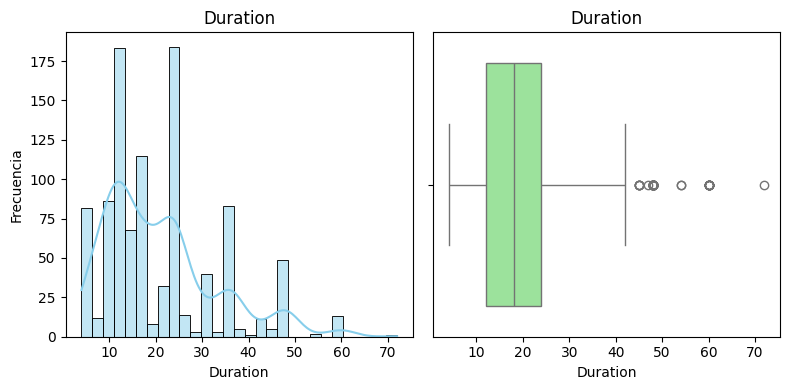

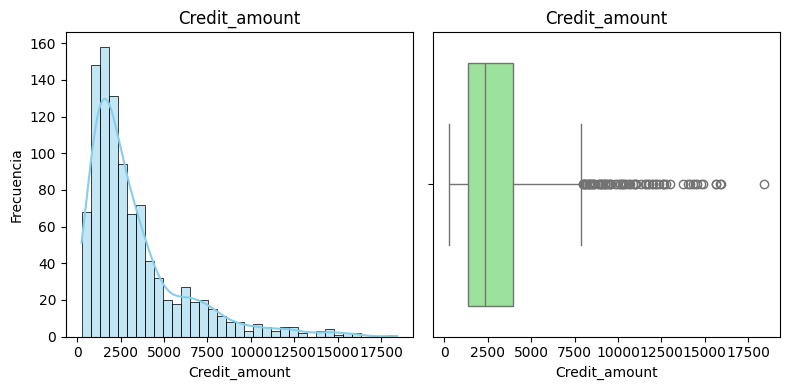

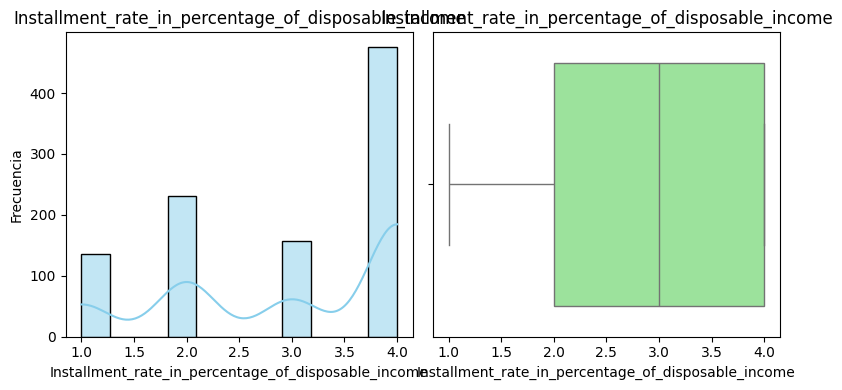

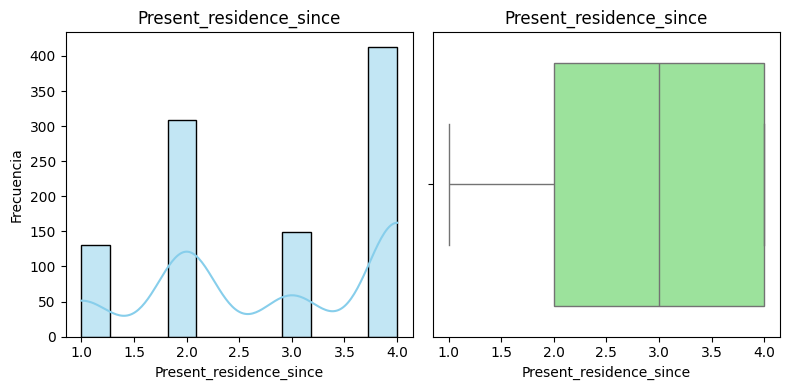

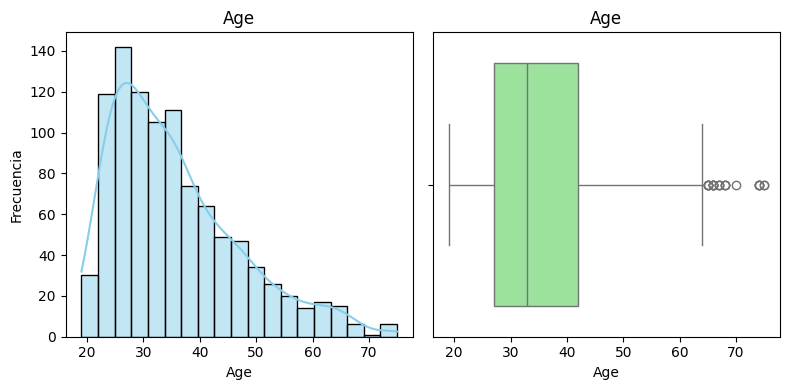

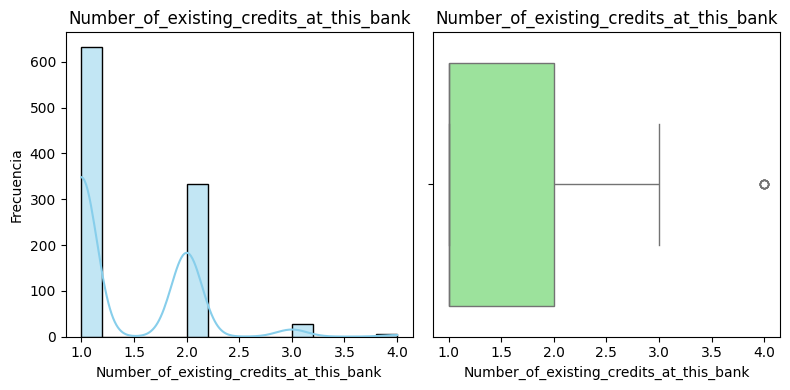

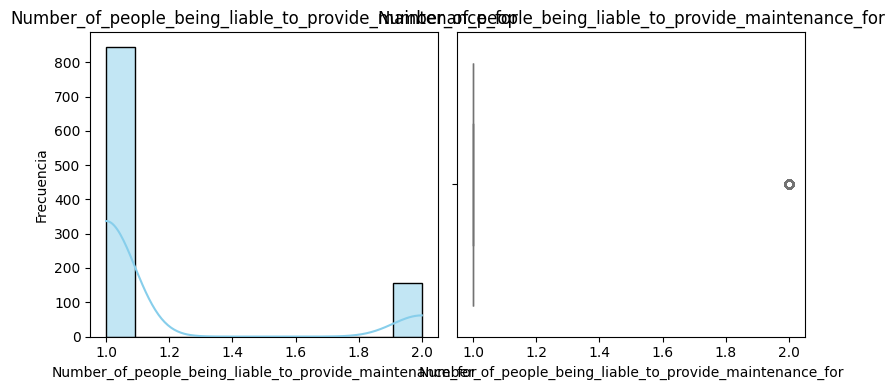

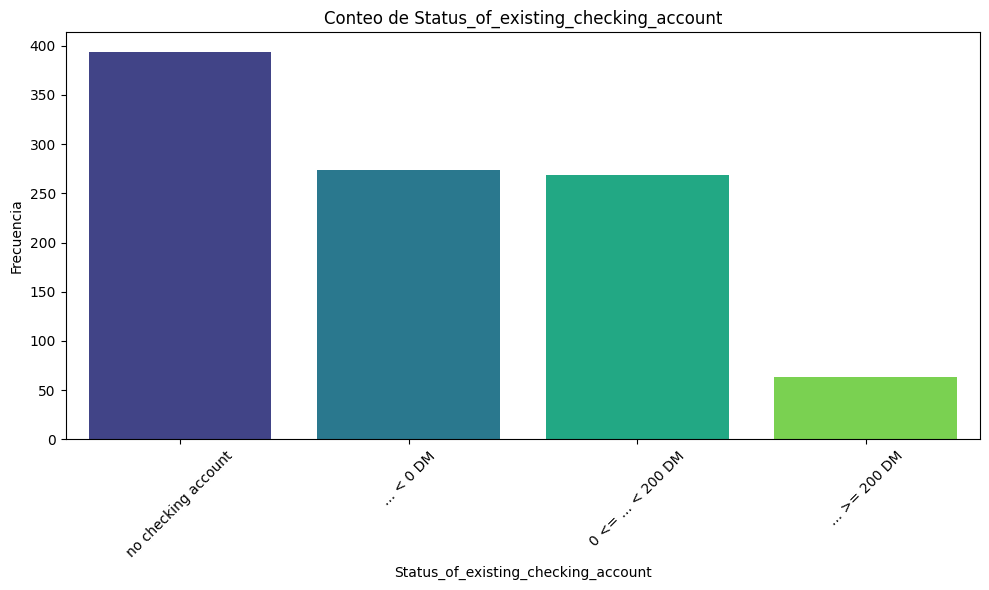

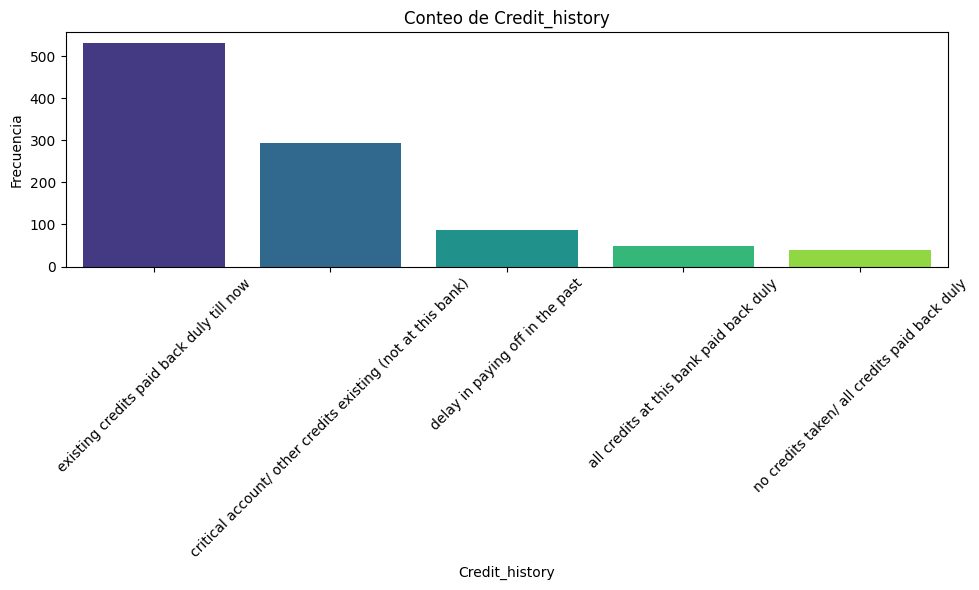

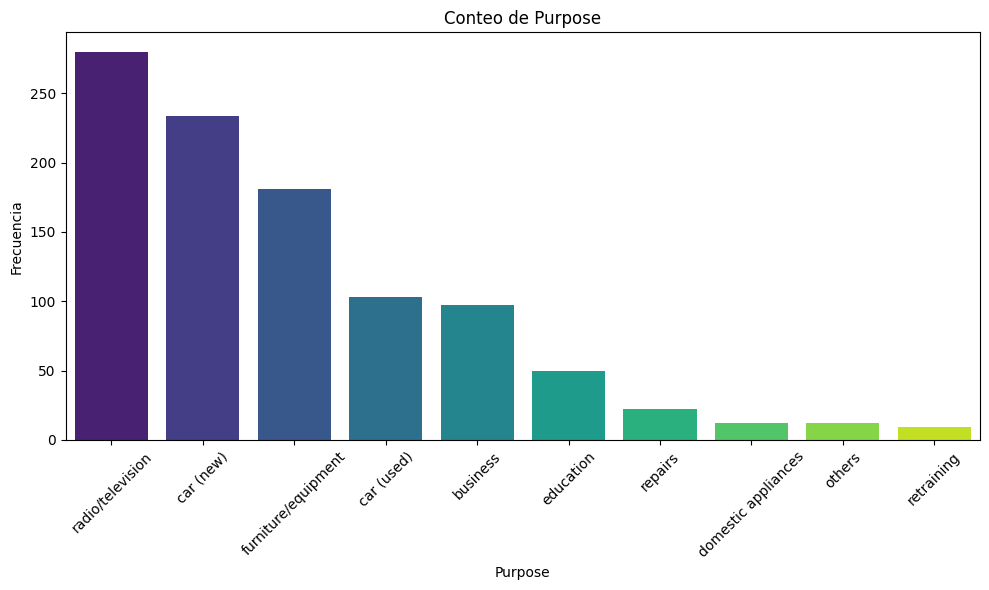

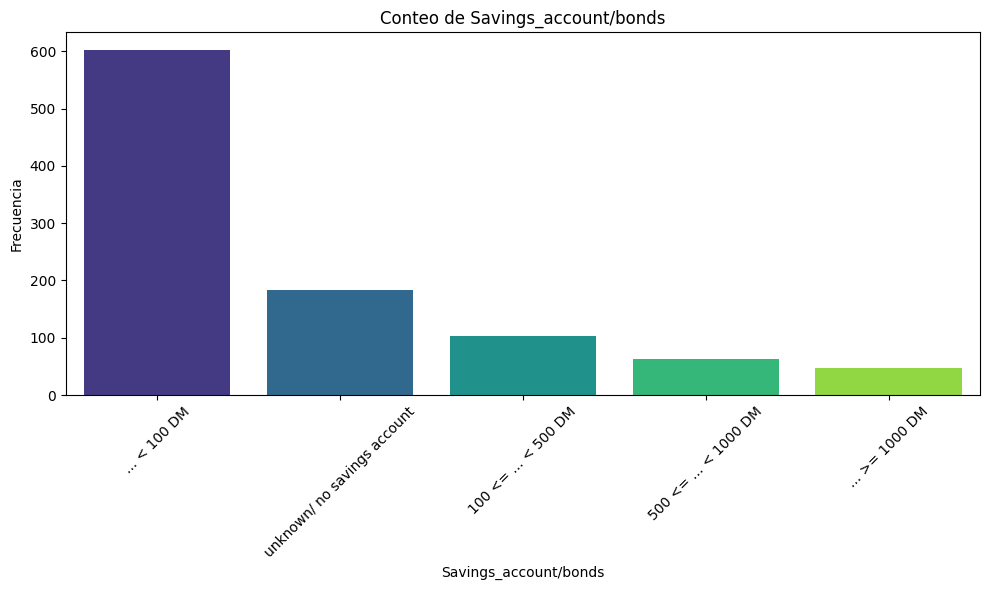

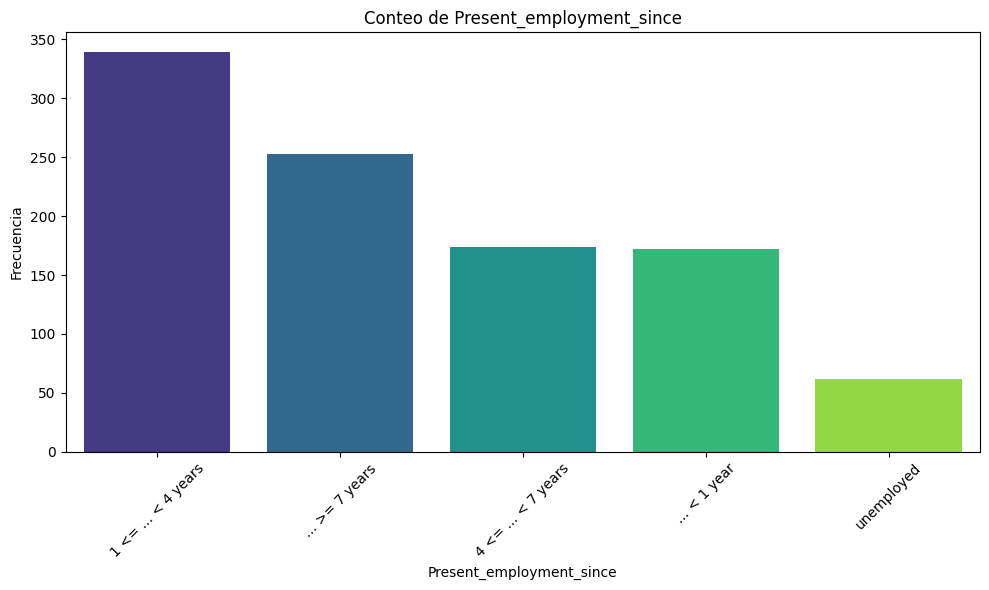

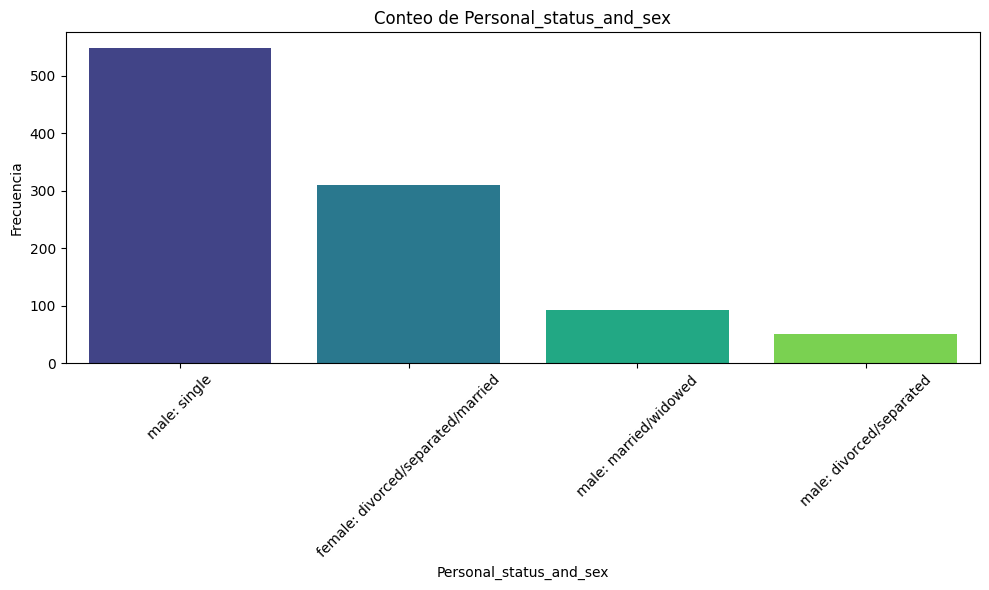

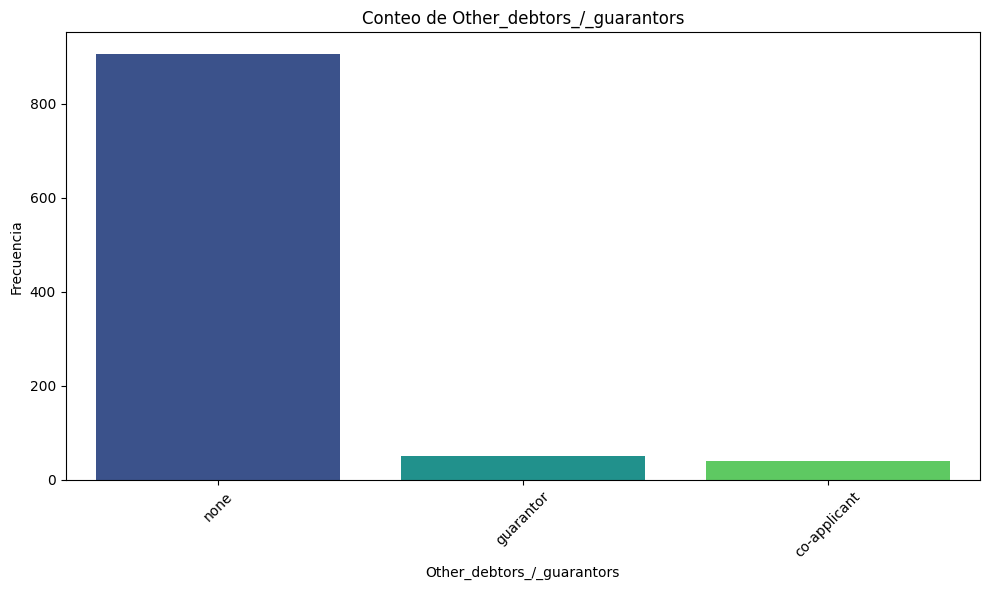

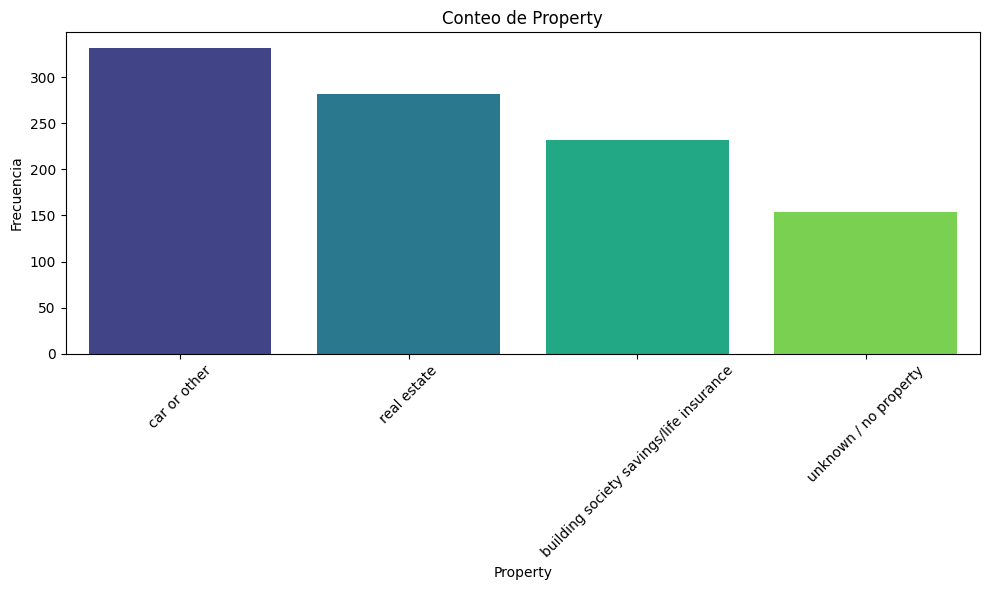

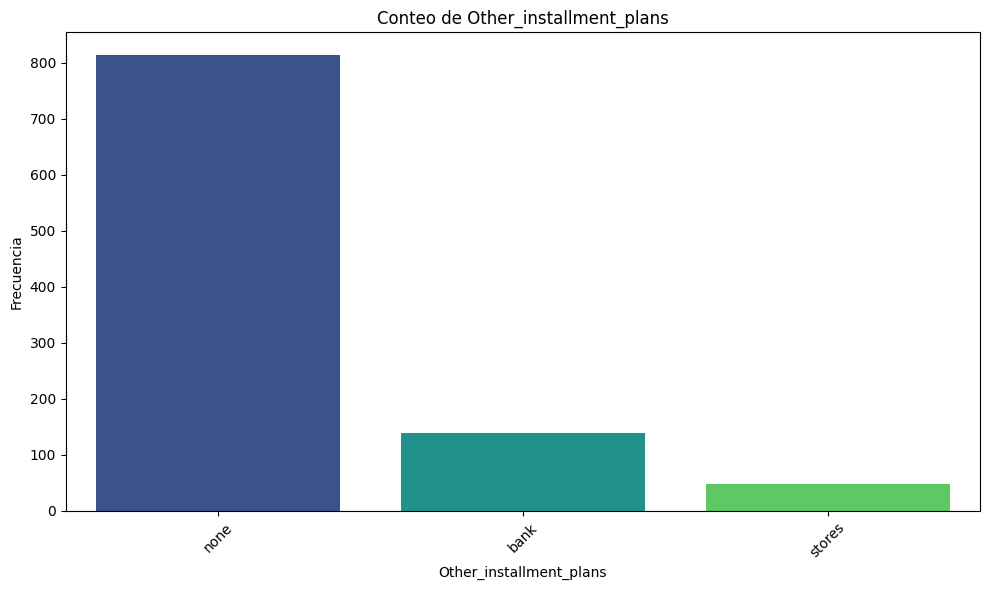

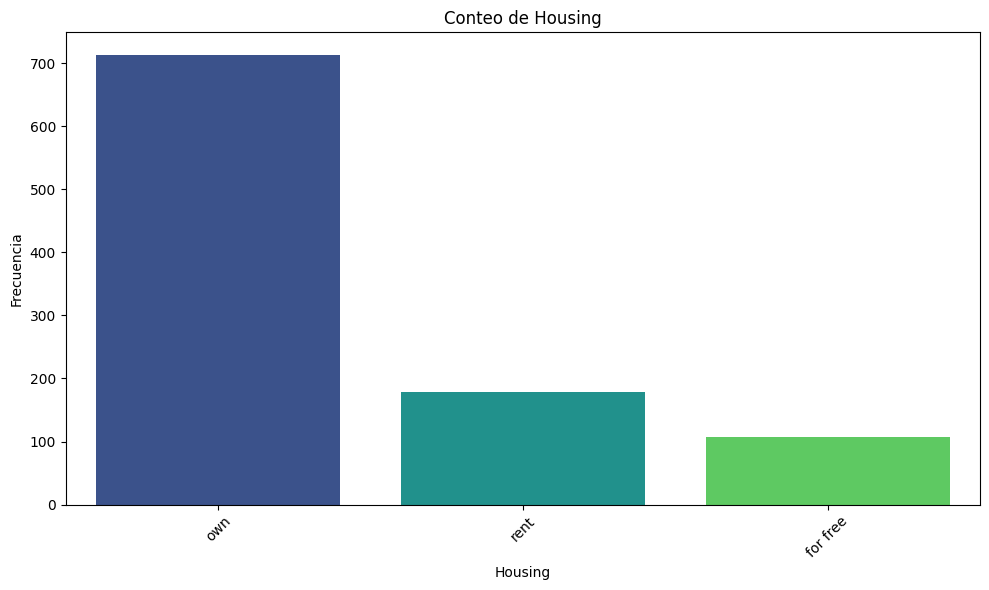

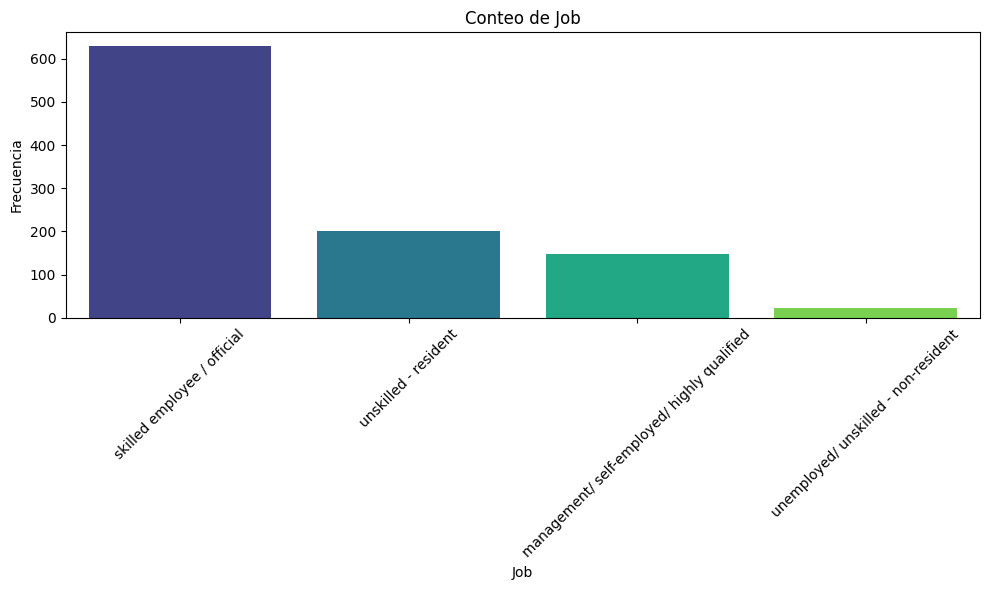

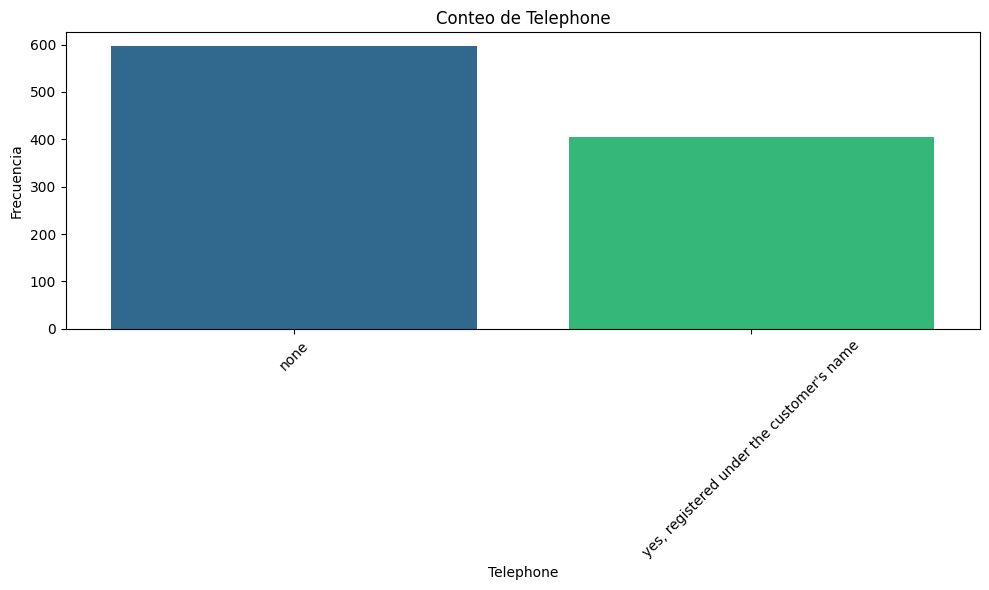

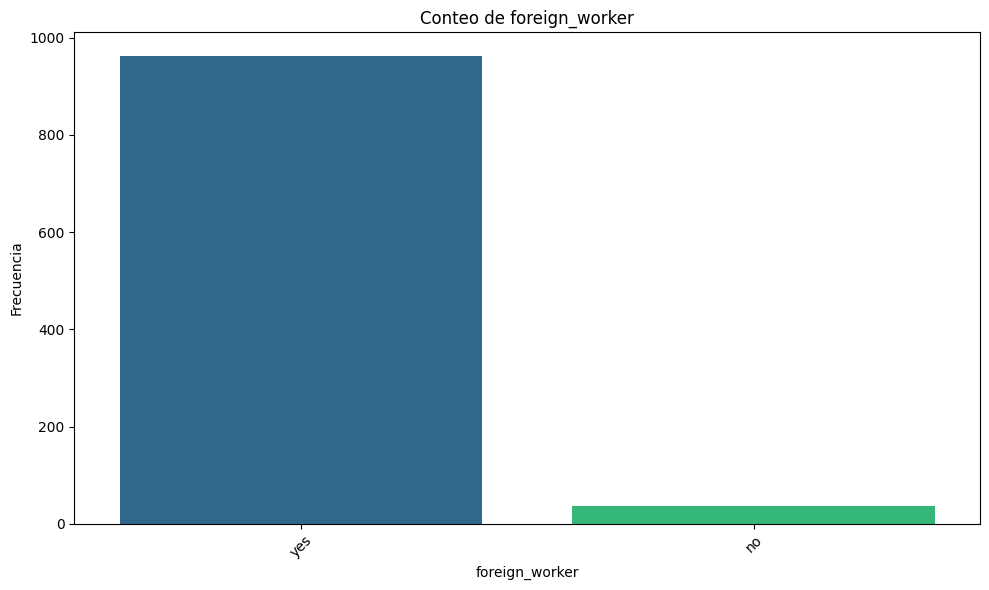

In [71]:
visualize_numerical(df, numerical_cols)
visualize_categorical(df, categorical_cols)

Al analizar la visualización de las variables numéricas, podemos confirmar que no se encuentran valores perdidos en el conjunto de datos, lo cual facilita el análisis y garantiza que todas las observaciones están completas. Asimismo, en los diagramas de caja no se observan valores atípicos o outliers significativos, lo cual sugiere que las características numéricas se distribuyen de manera consistente sin presencia de puntos extremos que puedan distorsionar el análisis.

Al examinar los histogramas de algunas variables, observamos que no siguen una distribución normal, lo cual es esperado dada la naturaleza de estas características. Por ejemplo, variables como el número de créditos existentes en el banco no presentan una curva simétrica, ya que se espera que esta variable esté concentrada en ciertos valores debido a las prácticas de crédito estándar. Esta falta de normalidad es común en datos financieros y no representa necesariamente un problema para el análisis.

En la visualización de las variables categóricas, observamos una distribución balanceada y desequilibrada en diferentes variables, que refleja la diversidad y características de los solicitantes de crédito. Mediante un tratamiento adecuado del desequilibrio en algunas categorías, podemos mejorar la capacidad del modelo para capturar patrones significativos y asegurar que aprenda de manera equilibrada y representativa de todo el conjunto de datos.

['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank', 'Number_of_people_being_liable_to_provide_maintenance_for']


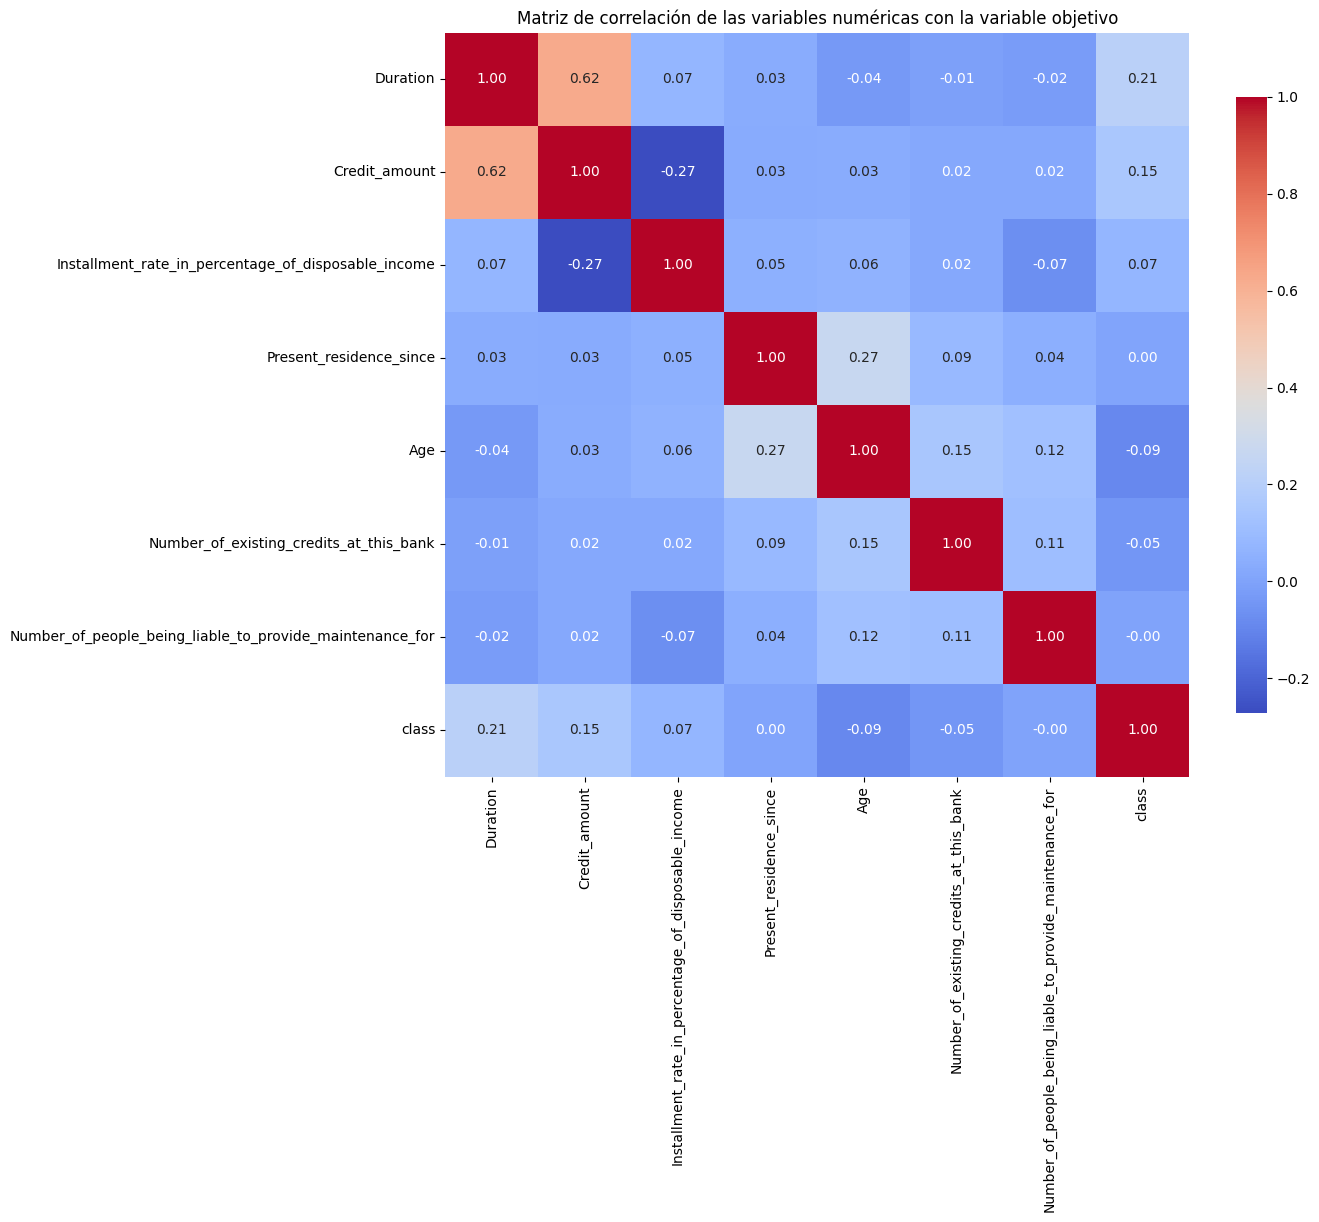

In [72]:

numerical_cols_with_target = numerical_cols + ['class']

print(numerical_cols)

corr_matrix_with_target = df[numerical_cols_with_target].corr()


plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_with_target, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de correlación de las variables numéricas con la variable objetivo')
plt.show()


Al observar la matriz de correlación de las variables numéricas, notamos que la mayoría de los coeficientes de correlación se encuentran muy cerca de 0. Esto sugiere que, en general, las variables numéricas del conjunto de datos no presentan relaciones lineales fuertes entre sí. Este bajo grado de correlación implica que cada variable aporta información relativamente independiente, lo cual puede ser beneficioso para el modelo, ya que no se corre el riesgo de redundancia o multicolinealidad significativa entre las variables numéricas.

Sin embargo, hay una excepción: encontramos una correlación de aproximadamente 0.62 entre las variables Duration y Credit Amount. Una correlación positiva en este caso tendría sentido: a medida que aumenta la cantidad solicitada, es probable que también se extienda la duración del préstamo para permitir pagos más asequibles.

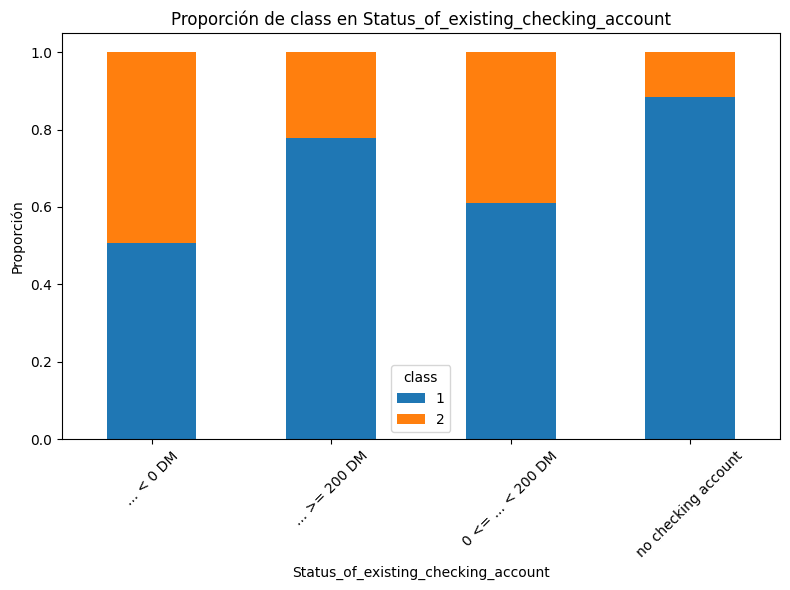

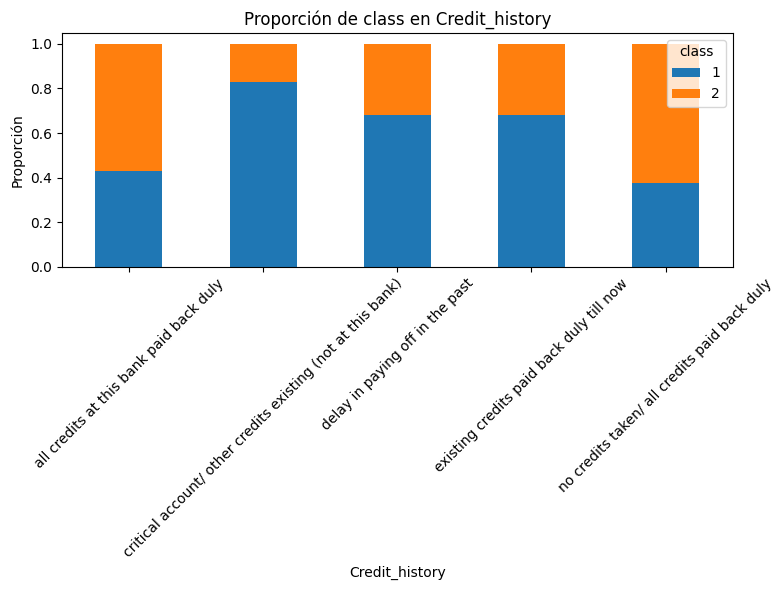

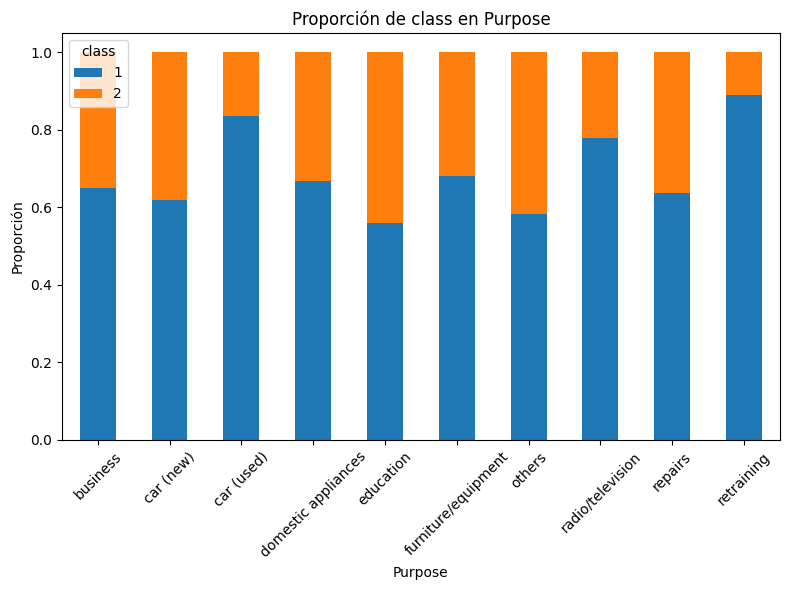

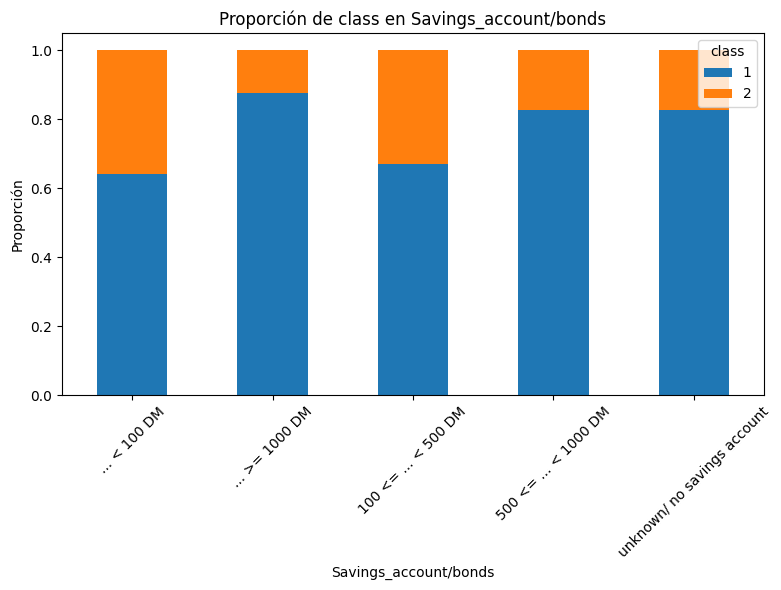

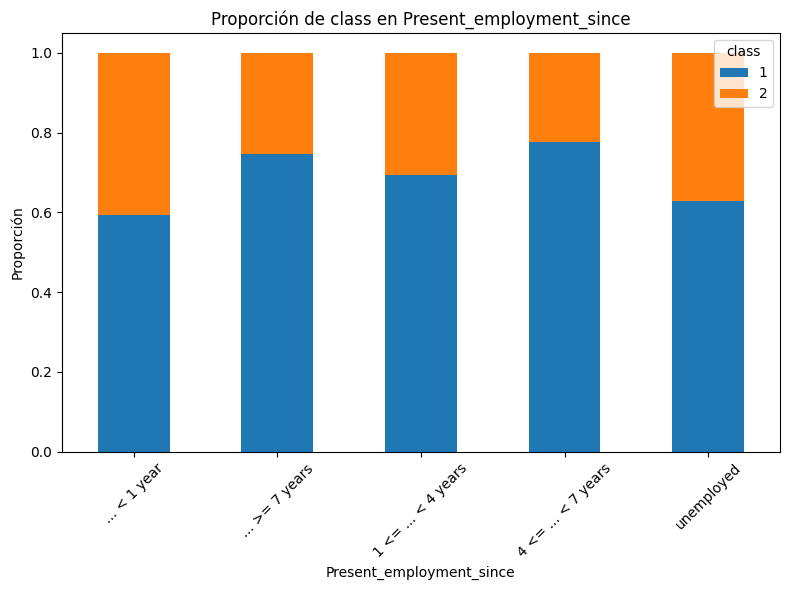

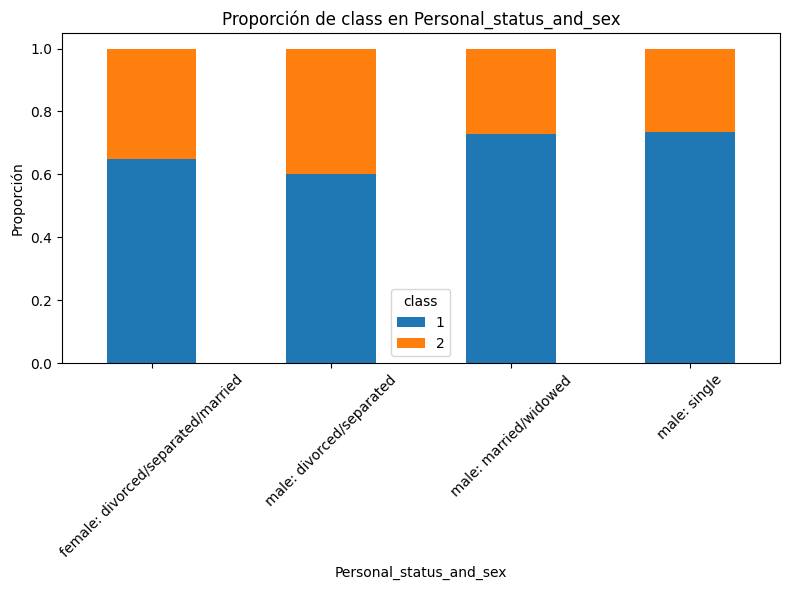

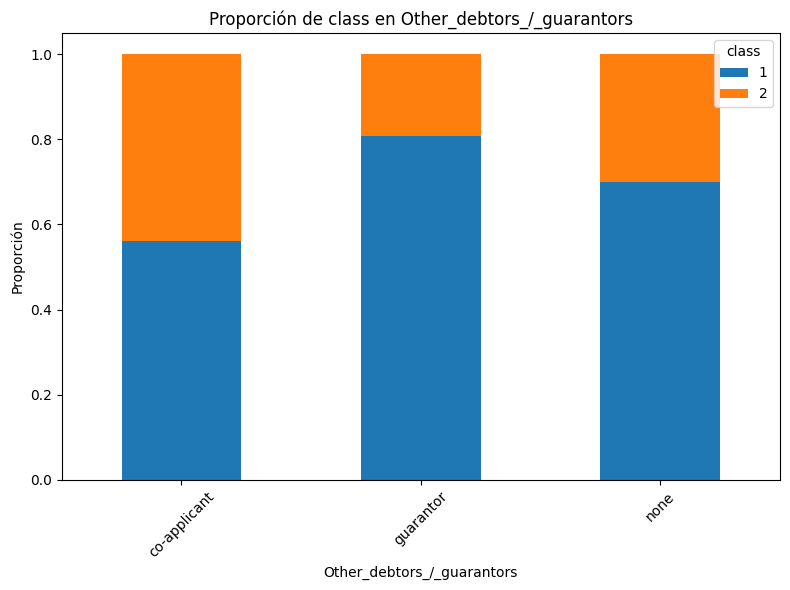

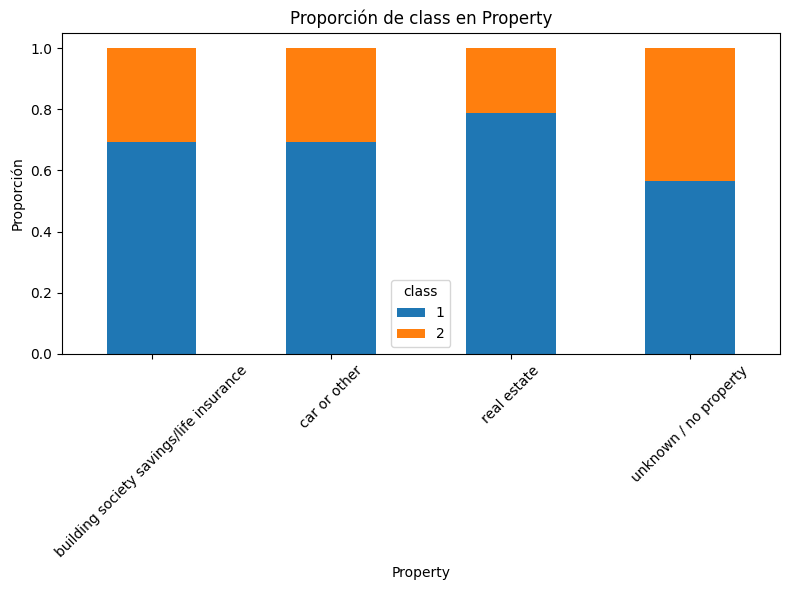

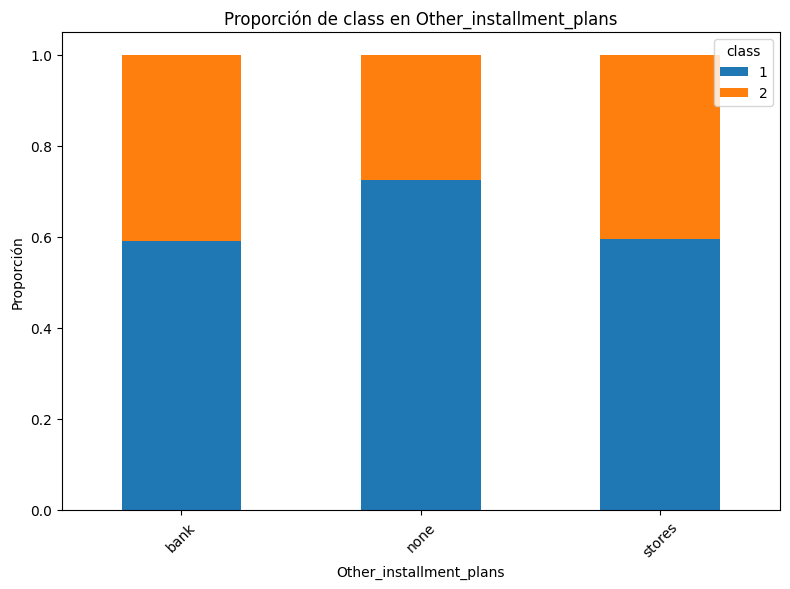

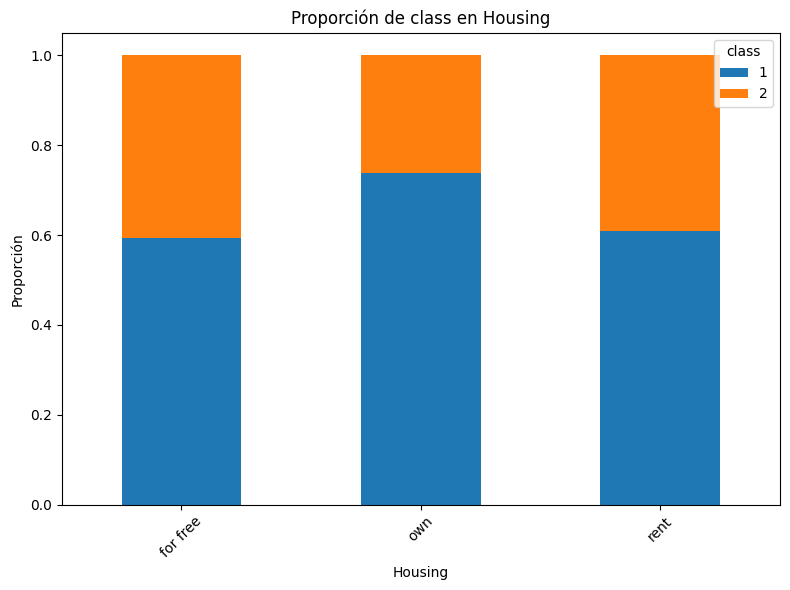

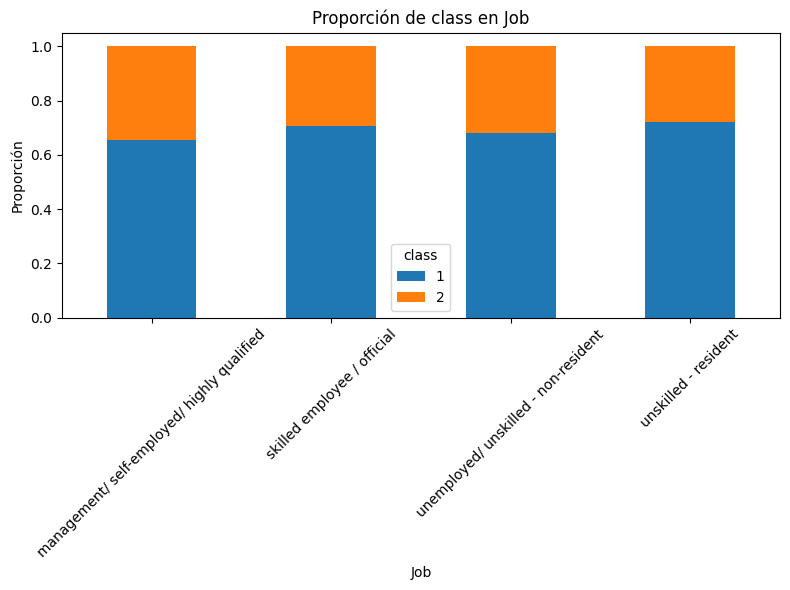

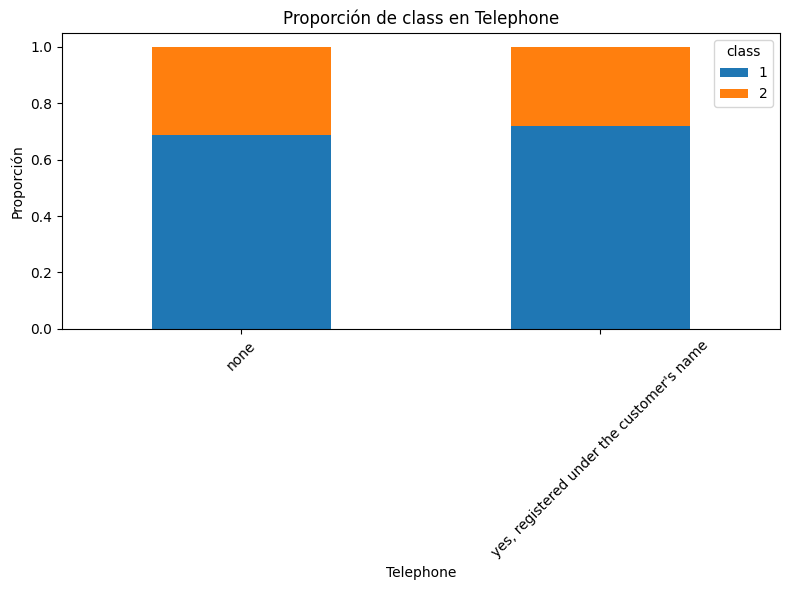

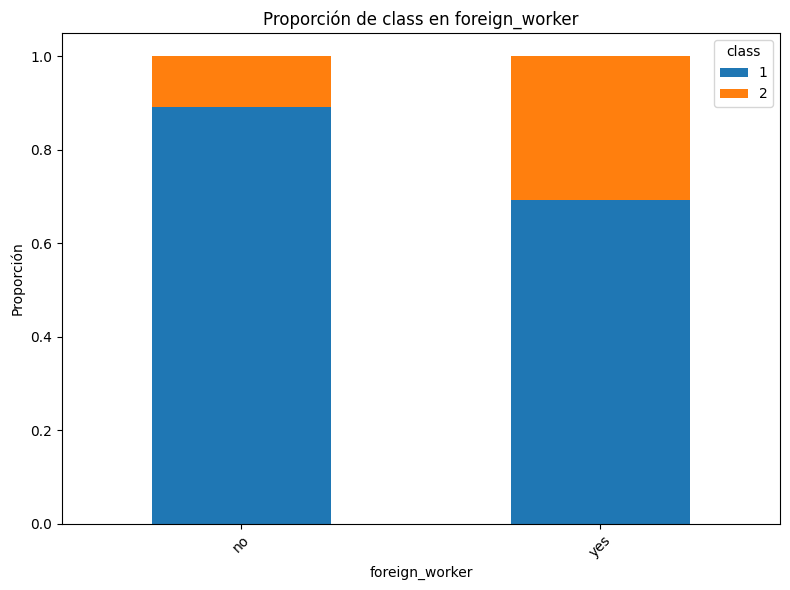

In [73]:
def visualize_categorical_vs_target_stacked(df, categorical_cols, target_col):

    figsize = (8,6)
    for col in categorical_cols:
        ct = pd.crosstab(df[col], df[target_col], normalize='index')
        ct.plot(kind='bar', stacked=True, figsize=figsize)
        plt.title(f'Proporción de {target_col} en {col}')
        plt.xlabel(col)
        plt.ylabel('Proporción')
        plt.legend(title=target_col)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


#class: 1 = good , 2 = bad
visualize_categorical_vs_target_stacked(df, categorical_cols, 'class')


Estos gráficos de barras apiladas nos permiten analizar la proporción de la variable objetivo (class) dentro de cada categoría de las variables categóricas. Este tipo de gráfico apilado muestra, para cada categoría, la distribución proporcional de las clases (en este caso, "Good" y "Bad"), permitiendo observar si alguna categoría está más asociada a una de las clases.

En este caso concreto, no parece que ninguna categoría muestre una tendencia claramente dominante hacia una u otra clase de riesgo. Esto sugiere que, al menos a primera vista, ninguna de las categorías se destaca significativamente como indicador del riesgo de un préstamo.

    Estas gráficas nos muestran además que será necesario estratificar los datos cuando los vayamos a dividir en entrenamiento y test ya que podemos observar como hay más ejemplos con la clase "good" que "bad" 

## Preprocesamiento

En este apartado aplicaremos el preprocesamiento a los datos según lo que hemos observado en las gráficas y según información adicional que miraremos durante este proceso.
### Missing Values
Observemos si existen missing values:

In [74]:
df.isnull().sum()

Status_of_existing_checking_account                         0
Duration                                                    0
Credit_history                                              0
Purpose                                                     0
Credit_amount                                               0
Savings_account/bonds                                       0
Present_employment_since                                    0
Installment_rate_in_percentage_of_disposable_income         0
Personal_status_and_sex                                     0
Other_debtors_/_guarantors                                  0
Present_residence_since                                     0
Property                                                    0
Age                                                         0
Other_installment_plans                                     0
Housing                                                     0
Number_of_existing_credits_at_this_bank                     0
Job     

No existen valores perdidos.   

### Outliers y valores incoherentes o incorrectos

Miremos si hay valores extremos que debamos tener en cuenta. Segun lo que hemos podido ver de los gráficos en la visualizacion inicial de los datos,
no hay valores perdidos codificados como valores extremos (podría ser que en vez de null los valores perdidos tuvieran un valor extremo para indicarse) y tampoco  
observamos que debieramos eliminar ninguna instancia por incoherente ya que todas tienen sus variables con valores dentro de los rangos y distribuciones que supondriamos.

Aún así vamos a aplicar un algoritmo como **LocalOutlierFactor** de scikit para ver que instancias considera outliers.

In [75]:

# Preparar datos numéricos
df_numerico = df[numerical_cols]

# Configurar y ajustar LOF
local_outlier_factor = LocalOutlierFactor(n_neighbors=20) # Número de vecinos a considerar
result = local_outlier_factor.fit_predict(df_numerico.values)

# Identificar outliers y puntos normales
outliers = result == -1
no_outliers = result == 1

# Ver número de outliers
print(f"Número de outliers detectados: {outliers.sum()}")

Número de outliers detectados: 4


Con 20 vecinos detecta 4 outliers veamos cuales son:

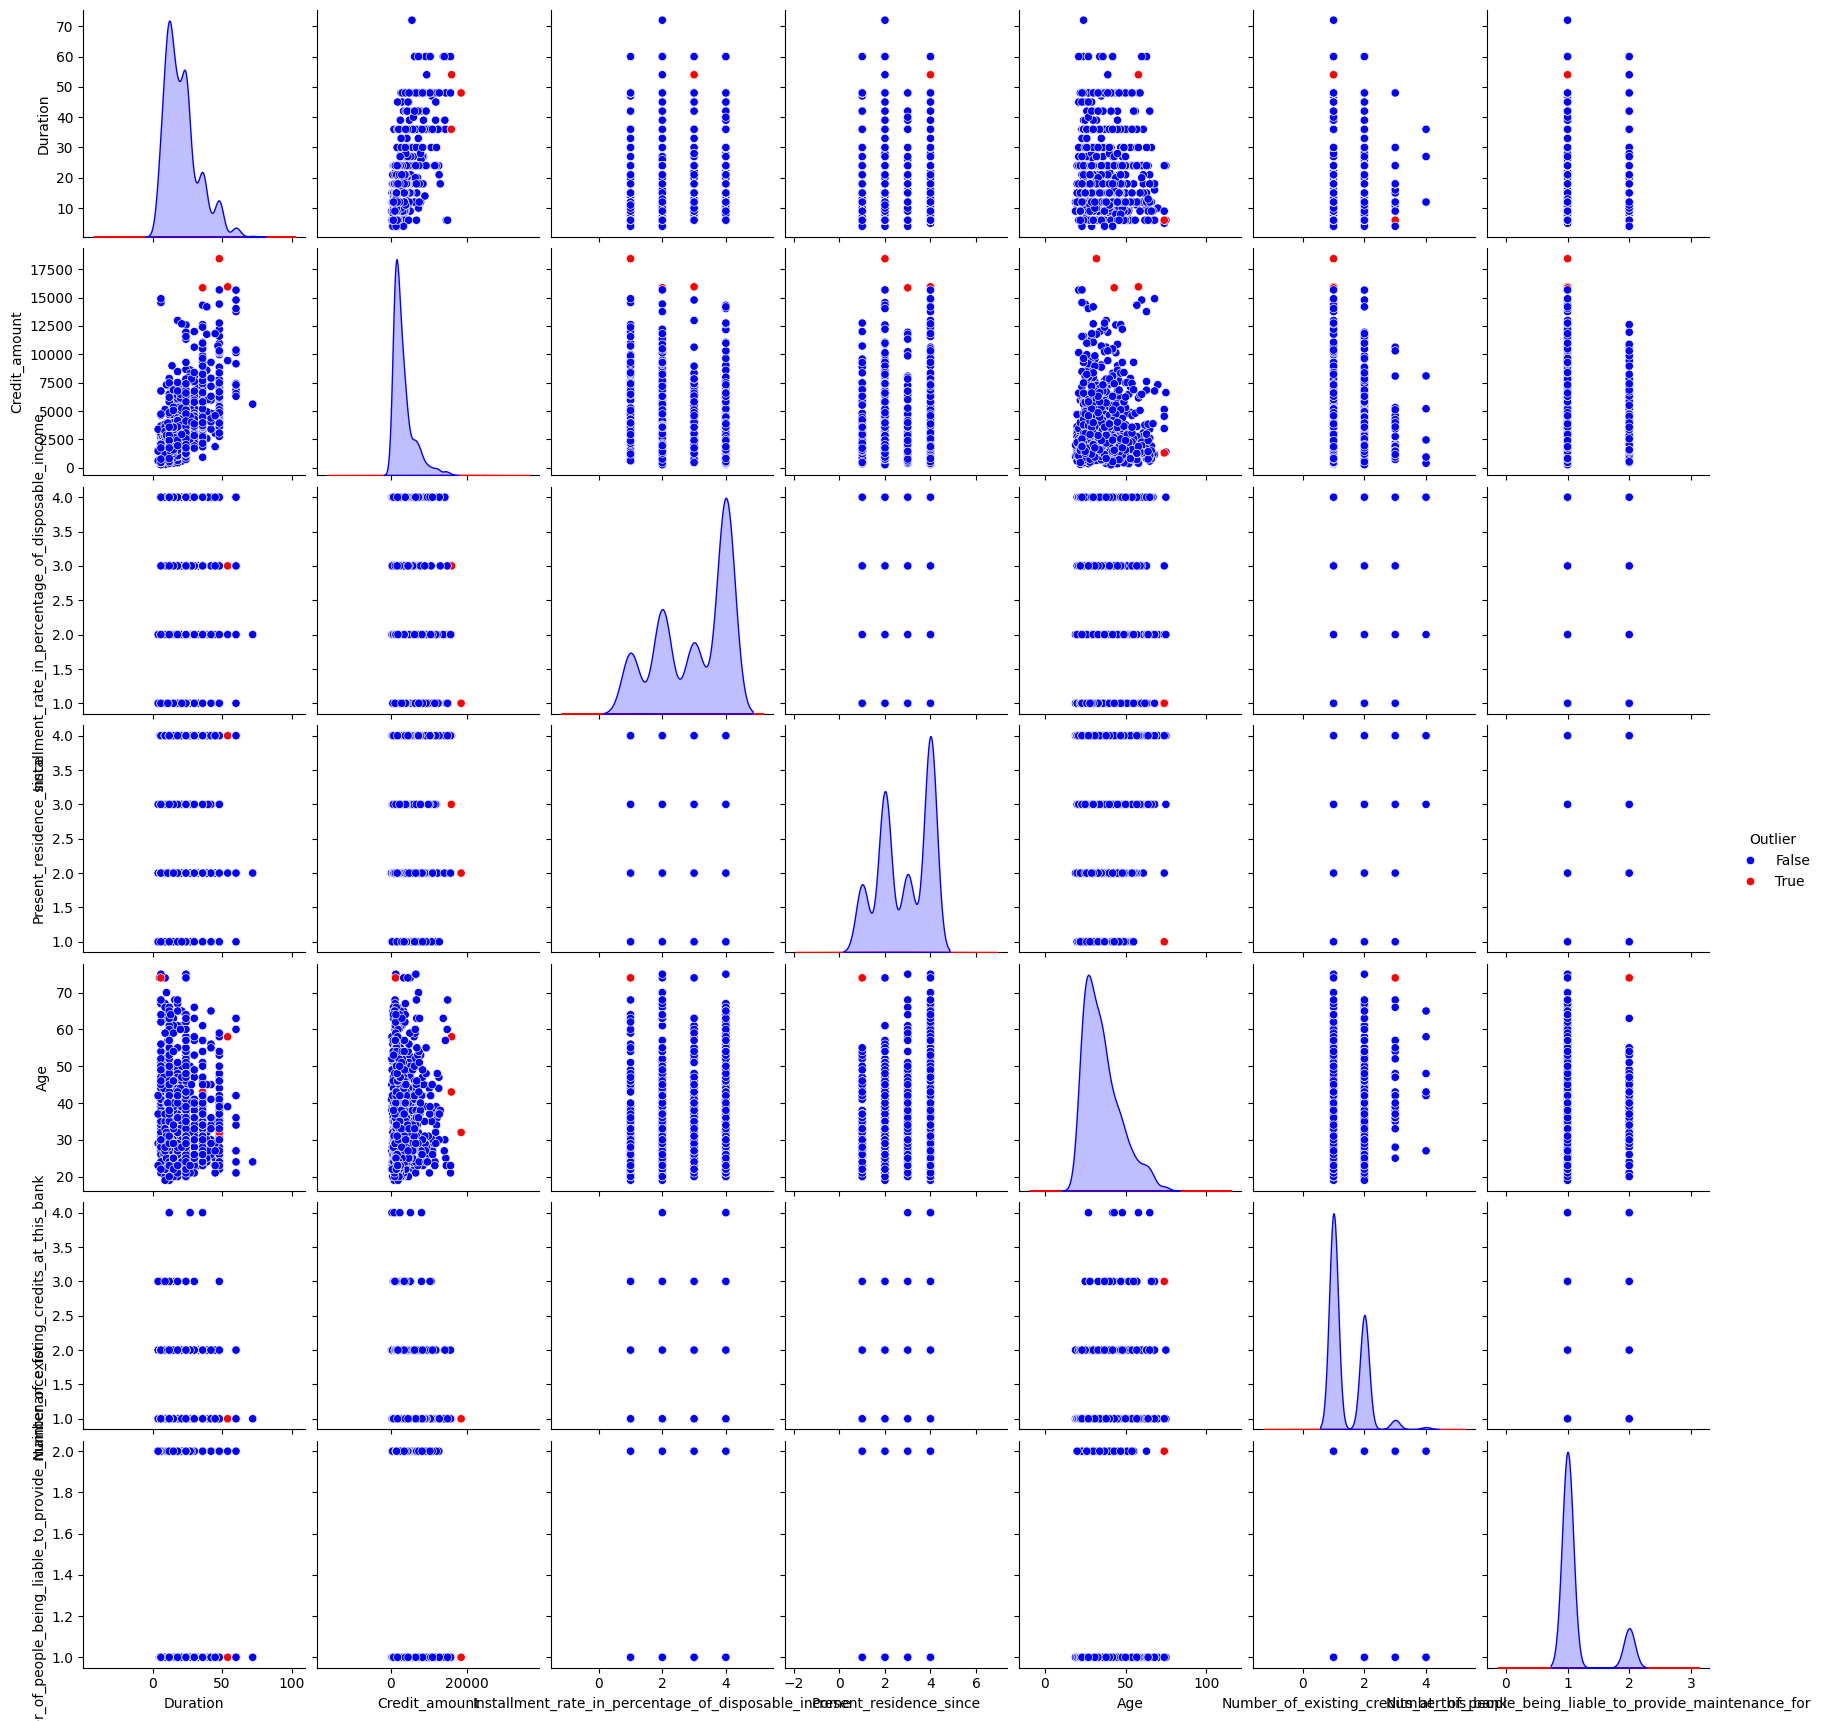

In [76]:
def plot_outliers(df_numerico, outliers):
    """
    Visualiza pares de variables numéricas, coloreando por outliers.

    Parámetros:
    - df: DataFrame que contiene los datos.
    - outliers: Array booleano que indica si cada instancia es un outlier.
    - numerical_cols: Lista de nombres de columnas numéricas.
    """
    df_plot = df_numerico.copy()
    df_plot["Outlier"] = outliers

    sns.pairplot(df_plot, hue="Outlier", palette={0: "blue", 1: "red"}, diag_kind="kde")
    plt.show()

plot_outliers(df_numerico, outliers)

Podemos observar como 3 de los 4 outliers coinciden con los valores de credit_amount más alto probablemente sea porque la escala es mucho mayor a la resta de variables.  
Probemos a estandarizar antes de hacer todo este proceso:

Tipos de datos en el DataFrame:
Primeras filas del DataFrame estandarizado:
   Duration  Credit_amount  \
0 -1.236478      -0.745131   
1  2.248194       0.949817   
2 -0.738668      -0.416562   
3  1.750384       1.634247   
4  0.256953       0.566664   

   Installment_rate_in_percentage_of_disposable_income  \
0                                           0.918477     
1                                          -0.870183     
2                                          -0.870183     
3                                          -0.870183     
4                                           0.024147     

   Present_residence_since       Age  Number_of_existing_credits_at_this_bank  \
0                 1.046987  2.766456                                 1.027079   
1                -0.765977 -1.191404                                -0.704926   
2                 0.140505  1.183312                                -0.704926   
3                 1.046987  0.831502                                -0

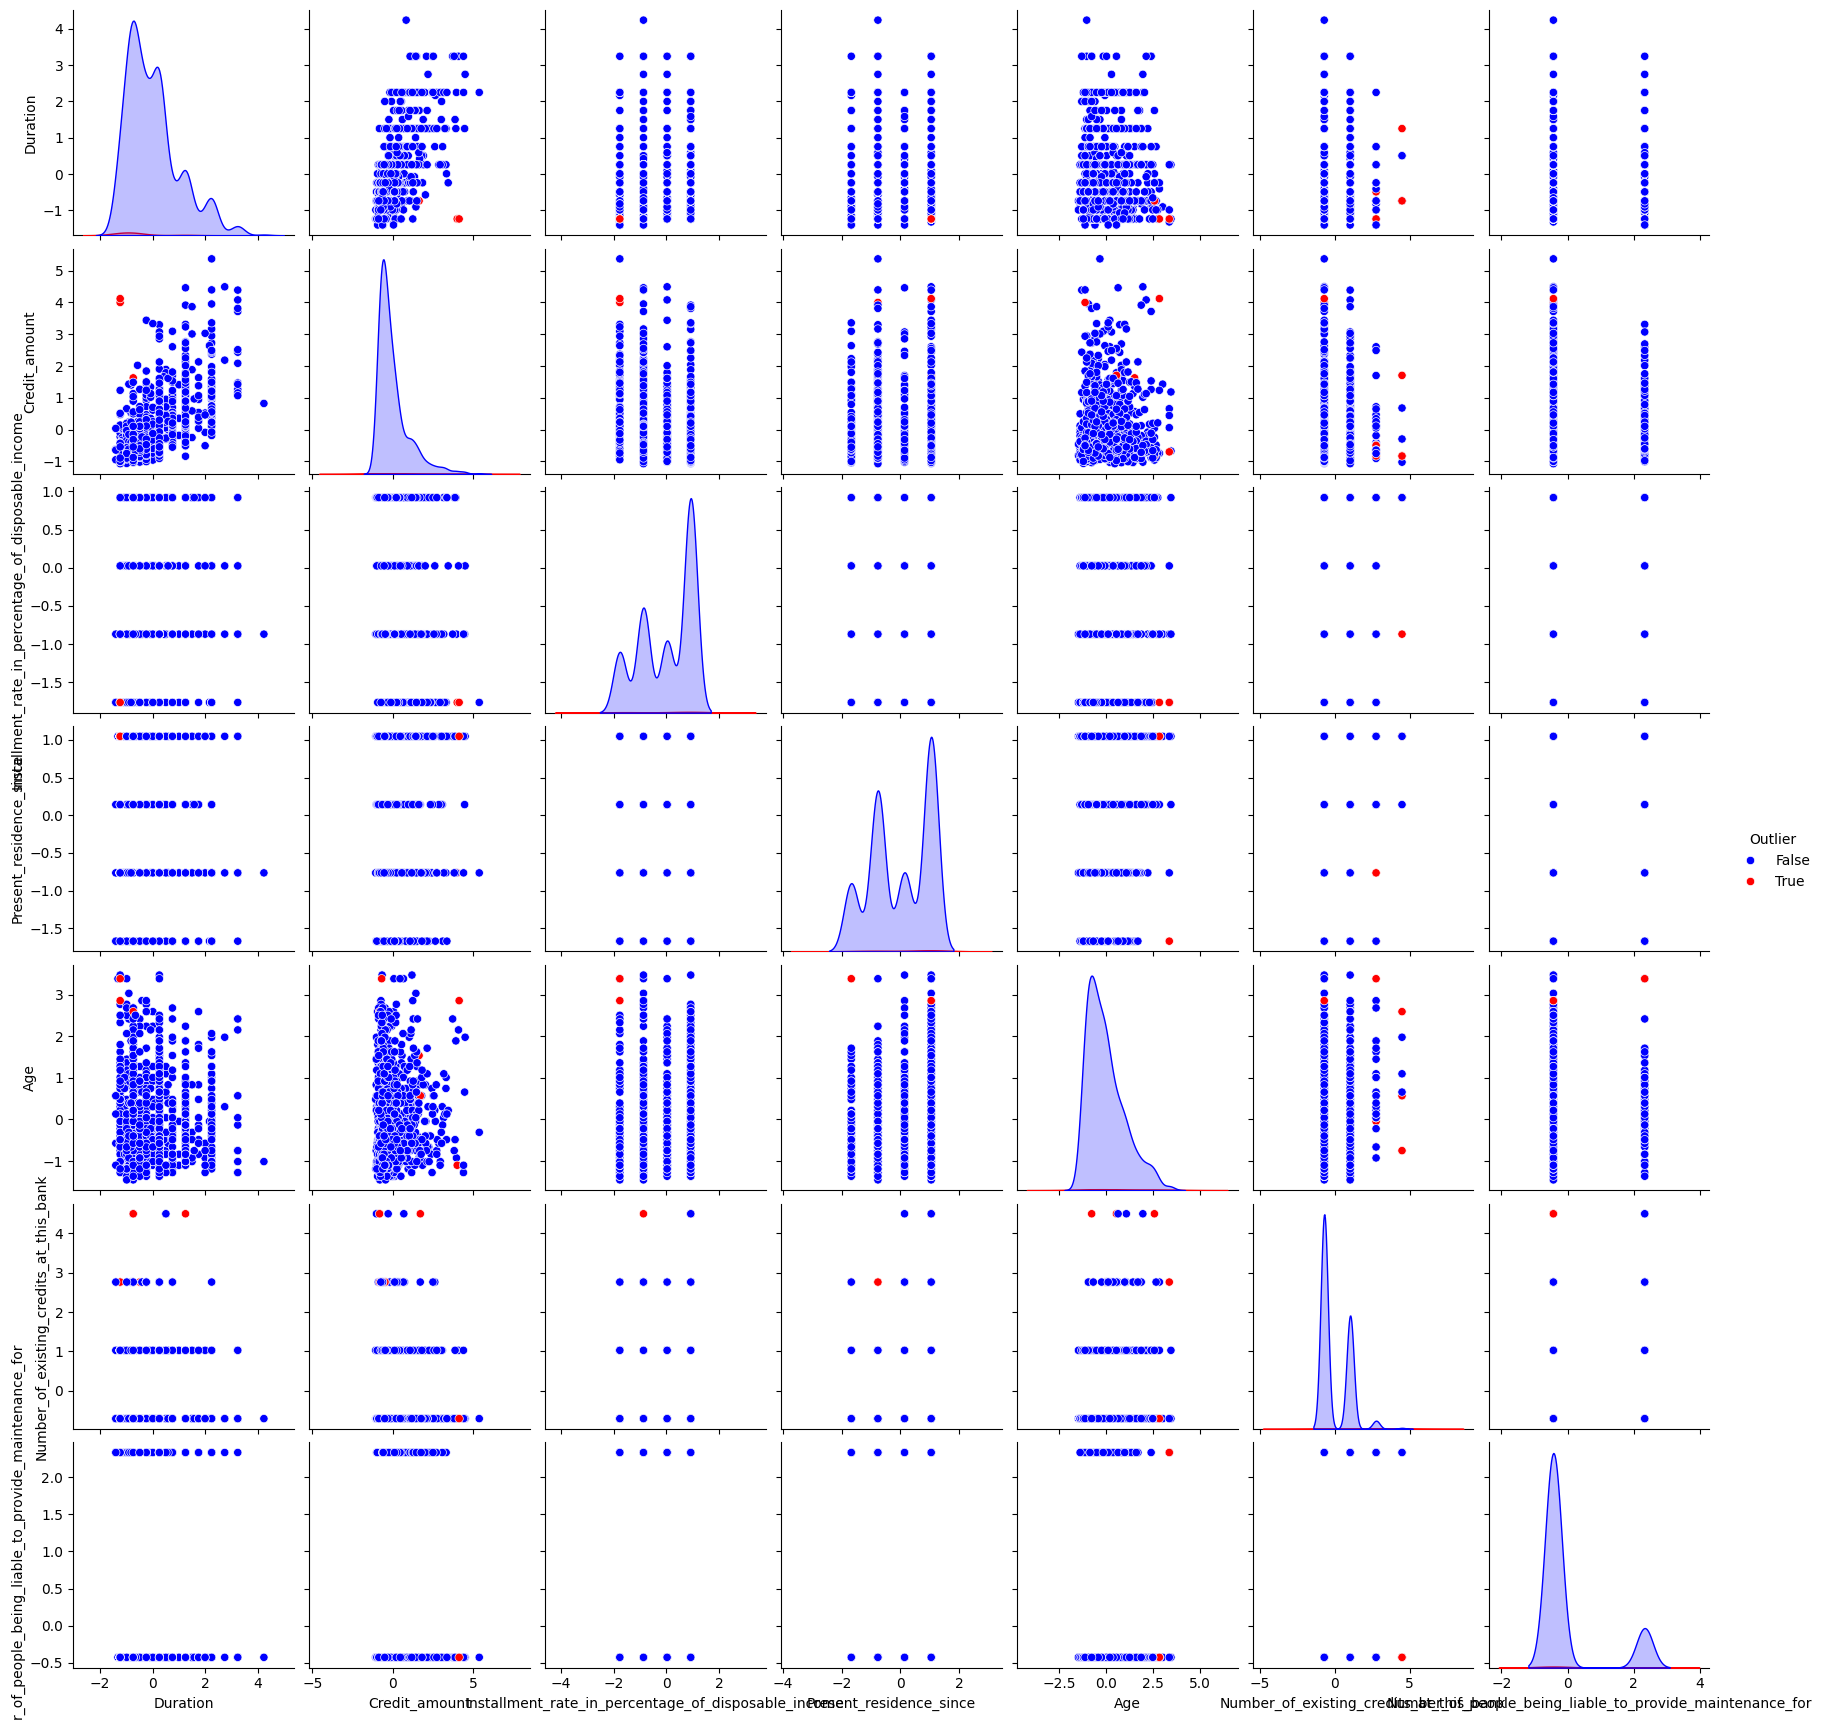

In [77]:
# Imprimir los tipos de datos
print("Tipos de datos en el DataFrame:")
#print(df.dtypes)

# Seleccionar columnas numéricas (solo int64 en este caso)

# Estandarizar los datos numéricos
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df[numerical_cols])

# Convertir los datos escalados en un DataFrame para facilitar el manejo
scaled_df = pd.DataFrame(scaled_values, columns=numerical_cols)

# Verificar los datos estandarizados
print("Primeras filas del DataFrame estandarizado:")
print(scaled_df.head())

# Configurar y ajustar LOF
local_outlier_factor = LocalOutlierFactor(n_neighbors=20)  # Número de vecinos
result = local_outlier_factor.fit_predict(scaled_df.values)

# Identificar outliers y puntos normales
outliers = result == -1
no_outliers = result == 1

# Ver número de outliers detectados
print(f"Número de outliers detectados: {outliers.sum()}")

# Llamar a la función de visualización
plot_outliers(scaled_df, outliers)

Observamos que ahora hay más outliers con el mismo numero de vecinos y estan distribuidos.  
Aún así podemos ver como estos valores tampoco se alejan exageradamente de la resta, como hemos dicho nosotros no consideraremos **de momento** que haya outliers.

### Posible eliminación de variables irrelevantes o redundantes (selección de características)

A continuación, observamos las correlaciones entre todas las variables, para identificar posibles candidatas a ser eliminadas.

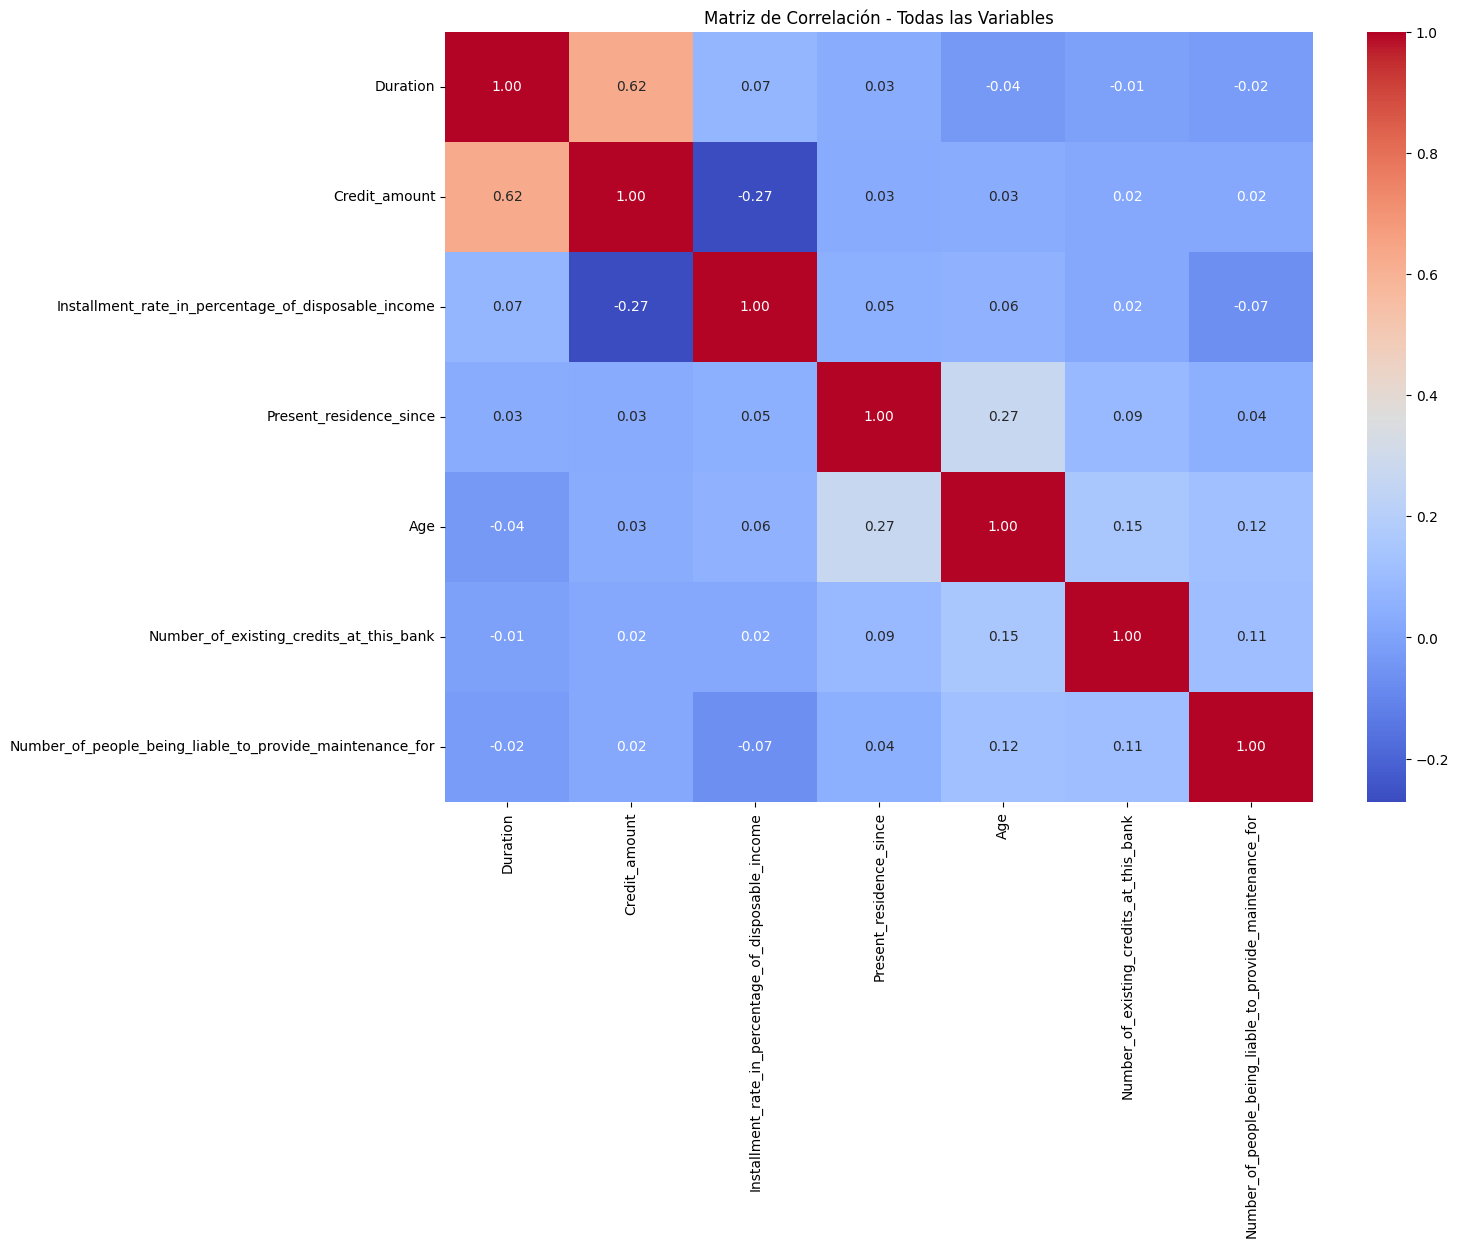

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt


# Verificar si hay variables numéricas
if len(numerical_cols) == 0:
    print("No hay columnas numéricas válidas para generar un mapa de calor.")
else:
    # Calcular la matriz de correlación para todas las variables numéricas
    combined_corr_matrix = df[numerical_cols].corr()

    # Visualizar el mapa de calor
    plt.figure(figsize=(14, 10))
    sns.heatmap(
        combined_corr_matrix,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        cbar=True
    )
    plt.title('Matriz de Correlación - Todas las Variables')
    plt.show()


El análisis del mapa de calor muestra que las correlaciones entre las variables son moderadas, con valores entre 0.62 y -0.27, y no se observan relaciones extremadamente altas que indiquen redundancia. Aunque algunas variables tienen correlaciones muy bajas con la variable objetivo, esto por sí solo no es suficiente para justificar su eliminación, ya que podrían aportar información relevante en combinación con otras variables. Por lo tanto, de momento no eliminaremos ninguna variable y procederemos con el preprocesamiento completo antes de tomar decisiones adicionales.

### Creación de nuevas variables que puedan ser útiles (extracción de características)

En este caso, considerando las variables disponibles, no se considera necesario crear nuevas características en este momento. Las variables ya proporcionan información clara y bien definida, como duración del crédito, historial crediticio, cantidad del crédito, edad, y otras que capturan distintos aspectos relevantes del problema.

## Método de Remuestreo 

Antes de la normalización haremos el remuestreo de los datos ya que el procedimiento correcto es dividir el conjunto en entramiento y test y aplicar solo el escalado a los datos de entrenamiento (fit_transform), y despues con el escalador ajustado a los datos de entrenamiento, escalar los de test.

Separamos las características y la variable objetivo, dividiendo el conjunto en entrenamiento (80%) y prueba (20%) de forma estratificada por lo que hemos comentado anteriormente después de observar las gráficas (que ahora afirmaremos en este apartado con y.value_counts()). stratify=y en train_test_split asegura que la proporción entre las clases de la variable objetivo se conserve en los conjuntos de entrenamiento y prueba. Esto es especialmente útil cuando las clases están desbalanceadas, que es nuestro caso, para garantizar que ambas particiones tengan representaciones proporcionales de todas las clases.  

 Utilizamos validación cruzada con 5 pliegues para evaluar el modelo de manera robusta.

In [79]:
# Separar las características (X) y la variable objetivo (y)
X = df.drop('class', axis=1)  
y = df['class']

print("Distribución de las etiquetas en el conjunto original:")
print(y.value_counts(), "\n")

# Dividir los datos en conjunto de entrenamiento y prueba (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random, stratify=y
)

# Configurar la validación cruzada estratificada con 5 pliegues (SE UTILIZARA PARA LOS MODELOS)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random)

# Imprimir las dimensiones de los conjuntos
print("Dimensiones de los conjuntos:\n")
print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")
print("\n")
print("Distribución en el conjunto de entrenamiento:")
print(y_train.value_counts())

# Contar las instancias de cada etiqueta en y_test
print("\nDistribución en el conjunto de prueba:")
print(y_test.value_counts())
X_train[:2]

Distribución de las etiquetas en el conjunto original:
class
1    700
2    300
Name: count, dtype: int64 

Dimensiones de los conjuntos:

Conjunto de entrenamiento: (800, 20)
Conjunto de prueba: (200, 20)


Distribución en el conjunto de entrenamiento:
class
1    560
2    240
Name: count, dtype: int64

Distribución en el conjunto de prueba:
class
1    140
2     60
Name: count, dtype: int64


Status_of_existing_checking_account  Duration  \
882                   0 <= ... < 200 DM        30   
719                   0 <= ... < 200 DM        20   

                                        Credit_history     Purpose  \
882  critical account/ other credits existing (not ...   car (new)   
719       no credits taken/ all credits paid back duly  car (used)   

     Credit_amount        Savings_account/bonds Present_employment_since  \
882           2181  unknown/ no savings account           ... >= 7 years   
719           6148          100 <= ... < 500 DM           ... >= 7 years   

     Installment_rate_in_percentage_of_disposable_income  \
882                                                  4     
719                                                  3     

    Personal_status_and_sex Other_debtors_/_guarantors  \
882            male: single                       none   
719   male: married/widowed                       none   

     Present_residence_since      Property  Age Other_installment_plans  \
882                        4   real estate   36                    none   
719                        4  car or other   31                    bank   

    Housing  Number_of_existing_credits_at_this_bank  \
882     own                                        2   
719     own                                        2   

                             Job  \
882  skilled employee / official   
719  skilled employee / official   

     Number_of_people_being_liable_to_provide_maintenance_for  \
882                                                  1          
719                                                  1          

                                     Telephone foreign_worker  
882                                       none            yes  
719  yes, registered under the customer's name            yes

### Codificación de variables no continuas o no ordenadas y Normalización de la variables (e.g. estandarización)

En nuestro conjunto de datos hace falta cambiar los valores de las variables categóricas de strings a numeros:
Utilizaremos One-Hot Encoding ya que estas las clases de estas variables categóricas no representan un orden.

La normalización de las variables es un paso clave en el preprocesamiento, especialmente para modelos que son sensibles a las escalas de los datos. Este proceso garantiza que todas las variables numéricas tengan una escala comparable, evitando que aquellas con rangos más grandes dominen el análisis. En este caso, se realizará la estandarización, transformando las variables numéricas para que tengan una media de 0 y una desviación estándar de 1. Esto facilita la convergencia de los modelos y mejora la interpretabilidad de los resultados.



In [80]:
from sklearn.preprocessing import OneHotEncoder
#Identificar numéricas y categóricas
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Crear ColumnTransformer 
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_features)
])

# Crear pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

#Ajustar pipeline en entrenamiento
X_train_transformed = pipeline.fit_transform(X_train)  # y_train se usaría si tuvieras un step supervisado
X_test_transformed = pipeline.transform(X_test)

#Reconstruir DataFrame si deseas visualizar
num_col_names = num_features
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
ohe_col_names = ohe.get_feature_names_out(cat_features)
final_col_names = list(num_col_names) + list(ohe_col_names) # Lista de nombres de columnas finales

X_train_transformed_df = pd.DataFrame(X_train_transformed, 
                                      columns=final_col_names,
                                      index=X_train.index)
X_test_transformed_df = pd.DataFrame(X_test_transformed, 
                                     columns=final_col_names,
                                     index=X_test.index)

display(X_train.head(2))

display(X_train_transformed_df.head(2))



Status_of_existing_checking_account  Duration  \
882                   0 <= ... < 200 DM        30   
719                   0 <= ... < 200 DM        20   

                                        Credit_history     Purpose  \
882  critical account/ other credits existing (not ...   car (new)   
719       no credits taken/ all credits paid back duly  car (used)   

     Credit_amount        Savings_account/bonds Present_employment_since  \
882           2181  unknown/ no savings account           ... >= 7 years   
719           6148          100 <= ... < 500 DM           ... >= 7 years   

     Installment_rate_in_percentage_of_disposable_income  \
882                                                  4     
719                                                  3     

    Personal_status_and_sex Other_debtors_/_guarantors  \
882            male: single                       none   
719   male: married/widowed                       none   

     Present_residence_since      Property  Age Other_installment_plans  \
882                        4   real estate   36                    none   
719                        4  car or other   31                    bank   

    Housing  Number_of_existing_credits_at_this_bank  \
882     own                                        2   
719     own                                        2   

                             Job  \
882  skilled employee / official   
719  skilled employee / official   

     Number_of_people_being_liable_to_provide_maintenance_for  \
882                                                  1          
719                                                  1          

                                     Telephone foreign_worker  
882                                       none            yes  
719  yes, registered under the customer's name            yes

Duration  Credit_amount  \
882  0.754215      -0.379305   
719 -0.089898       1.060270   

     Installment_rate_in_percentage_of_disposable_income  \
882                                           0.925948     
719                                           0.032391     

     Present_residence_since       Age  \
882                 1.045269  0.021988   
719                 1.045269 -0.413415   

     Number_of_existing_credits_at_this_bank  \
882                                  1.01522   
719                                  1.01522   

     Number_of_people_being_liable_to_provide_maintenance_for  \
882                                          -0.444528          
719                                          -0.444528          

     Status_of_existing_checking_account_... >= 200 DM  \
882                                                0.0   
719                                                0.0   

     Status_of_existing_checking_account_0 <= ... < 200 DM  \
882                                                1.0       
719                                                1.0       

     Status_of_existing_checking_account_no checking account  ...  \
882                                                0.0        ...   
719                                                0.0        ...   

     Property_unknown / no property  Other_installment_plans_none  \
882                             0.0                           1.0   
719                             0.0                           0.0   

     Other_installment_plans_stores  Housing_own  Housing_rent  \
882                             0.0          1.0           0.0   
719                             0.0          1.0           0.0   

     Job_skilled employee / official  \
882                              1.0   
719                              1.0   

     Job_unemployed/ unskilled - non-resident  Job_unskilled - resident  \
882                                       0.0                       0.0   
719                                       0.0                       0.0   

     Telephone_yes, registered under the customer's name  foreign_worker_yes  
882                                                0.0                   1.0  
719                                                1.0                   1.0  

[2 rows x 48 columns]

### Transformación de las variables (e.g. corrección de asimetrías graves y/o curtosis en los valores de los datos)

Para mejorar la calidad de nuestros datos, aplicaremos transformaciones a las variables numéricas con distribuciones altamente asimétricas o curtosis extrema. Estas transformaciones buscan acercar las distribuciones a una forma más normal, lo que es especialmente útil para algoritmos sensibles a estas características.

In [81]:
"""
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import PowerTransformer
import numpy as np

# Calcular asimetría y curtosis de las columnas numéricas (excluyendo 'class')
for col in numerical_cols:
    if col == 'class':
        continue  # Saltar la variable objetivo

    skewness = skew(df[col])
    curt = kurtosis(df[col])
    print(f"{col}: Asimetría = {skewness:.2f}, Curtosis = {curt:.2f}")

    # Aplicar transformación solo si la asimetría es significativa (e.g., |skewness| > 1)
    if abs(skewness) > 1:
        print(f"Aplicando transformación a {col}...")
        if (df[col] > 0).all():  # Asegurarse de que no haya valores <= 0 (para log)
            df[col] = np.log1p(df[col])  # Transformación logarítmica
        else:
            transformer = PowerTransformer(method='yeo-johnson', standardize=False)
            df[col] = transformer.fit_transform(df[col].values.reshape(-1, 1))

# Verificar nuevamente las distribuciones
for col in numerical_cols:
    if col == 'class':
        continue  # Saltar la variable objetivo

    skewness = skew(df[col])
    curt = kurtosis(df[col])
    print(f"{col} después de la transformación: Asimetría = {skewness:.2f}, Curtosis = {curt:.2f}")
"""

'\nfrom scipy.stats import skew, kurtosis\nfrom sklearn.preprocessing import PowerTransformer\nimport numpy as np\n\n# Calcular asimetría y curtosis de las columnas numéricas (excluyendo \'class\')\nfor col in numerical_cols:\n    if col == \'class\':\n        continue  # Saltar la variable objetivo\n\n    skewness = skew(df[col])\n    curt = kurtosis(df[col])\n    print(f"{col}: Asimetría = {skewness:.2f}, Curtosis = {curt:.2f}")\n\n    # Aplicar transformación solo si la asimetría es significativa (e.g., |skewness| > 1)\n    if abs(skewness) > 1:\n        print(f"Aplicando transformación a {col}...")\n        if (df[col] > 0).all():  # Asegurarse de que no haya valores <= 0 (para log)\n            df[col] = np.log1p(df[col])  # Transformación logarítmica\n        else:\n            transformer = PowerTransformer(method=\'yeo-johnson\', standardize=False)\n            df[col] = transformer.fit_transform(df[col].values.reshape(-1, 1))\n\n# Verificar nuevamente las distribuciones\nfor c

Tras aplicar las transformaciones a diversas variables, las distribuciones de las variables han mostrado una reducción significativa en asimetría y curtosis, logrando una mayor simetría en la mayoría de los casos.











## PCA

Para reducir la dimensionalidad de nuestros datos y facilitar su análisis, hemos aplicado un Análisis de Componentes Principales (PCA). Este método transforma las variables originales en un conjunto de componentes principales que explican la mayor cantidad de varianza posible en los datos. El objetivo es capturar al menos el 95% de la varianza total con el menor número de componentes principales, asegurando que la mayor parte de la información relevante se conserve mientras reducimos la complejidad del modelo.

Varianza explicada por cada componente principal:
[0.236572   0.20026425 0.16313891 0.13607517 0.12523053 0.1005337 ]
El número de componentes seleccionados para explicar el 95% de la varianza es: 6


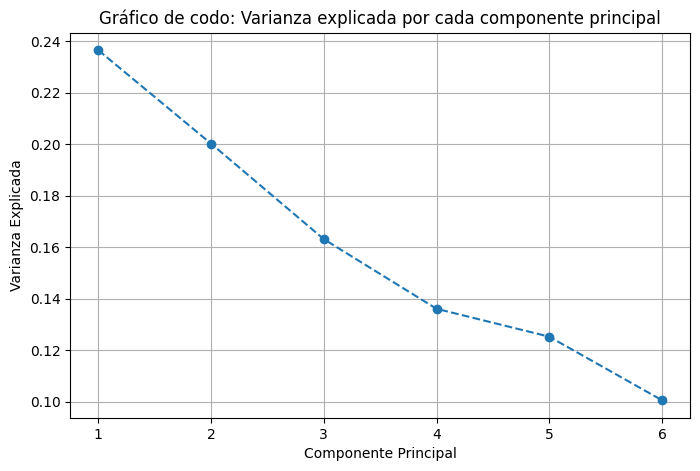

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Inicializar el PCA para capturar el 95% de la varianza
pca = PCA(n_components=0.95)

# Aplicar PCA a las variables numéricas ya estandarizadas
pca_transformed = pca.fit_transform(X_train_transformed_df[numerical_cols]) 

# Crear un DataFrame con las componentes principales
pca_df = pd.DataFrame(pca_transformed, columns=[f'PC{i+1}' for i in range(pca_transformed.shape[1])])

# Imprimir el porcentaje de varianza explicada por cada componente
print("Varianza explicada por cada componente principal:")
print(pca.explained_variance_ratio_)

# Imprimir el número de componentes seleccionados
print(f"El número de componentes seleccionados para explicar el 95% de la varianza es: {pca.n_components_}")

# Visualización: Gráfico de codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Gráfico de codo: Varianza explicada por cada componente principal')
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.grid()
plt.show()


El análisis de componentes principales (PCA) redujo la dimensionalidad del conjunto de datos a seis componentes, que explican el 95% de la varianza total. Las primeras componentes capturan la mayor parte de la información, mientras que las adicionales tienen poca contribución. Esto podría permitir simplificar el modelo sin perder información clave, mejorando la eficiencia en el procesamiento y el rendimiento predictivo.

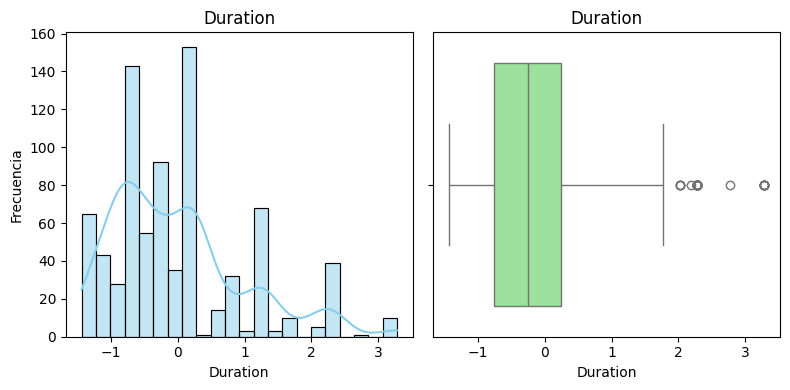

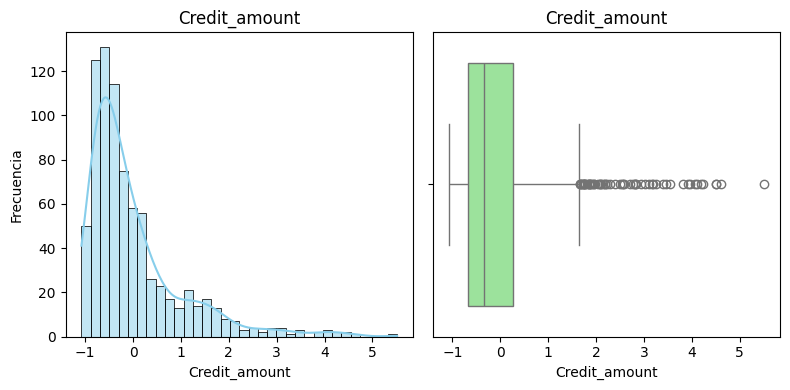

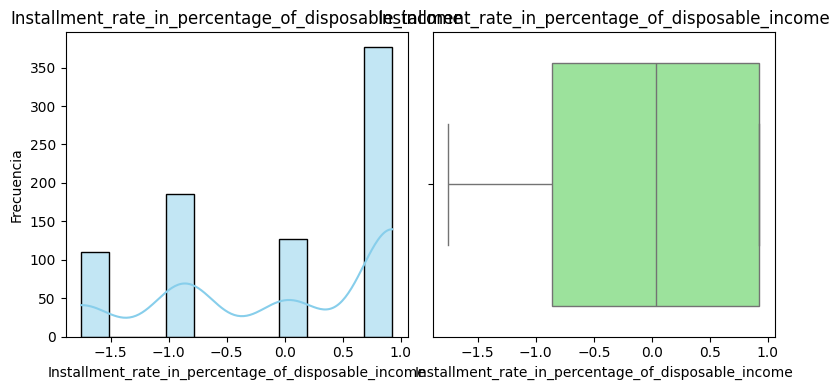

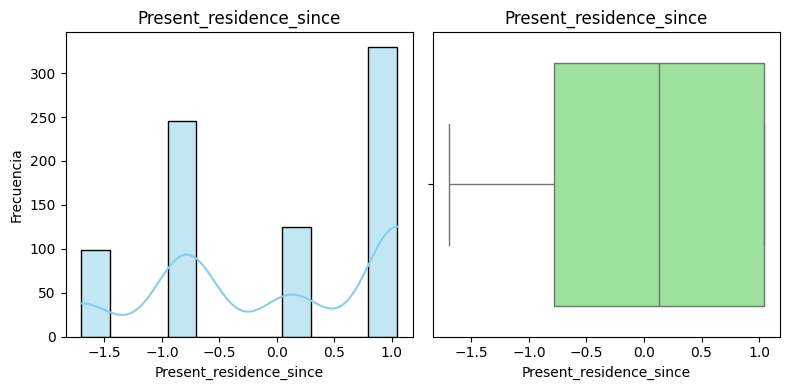

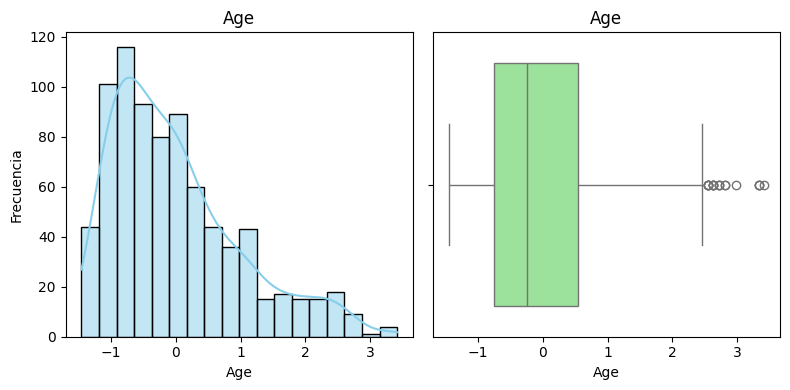

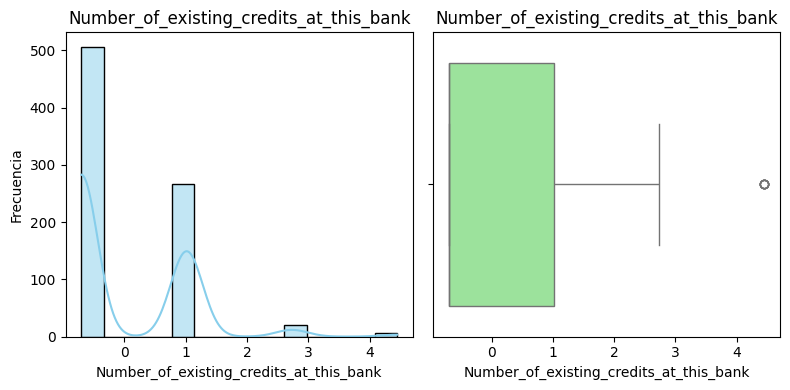

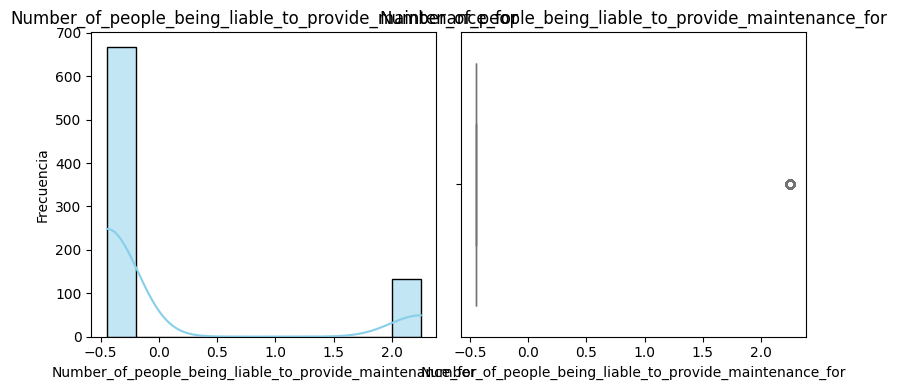

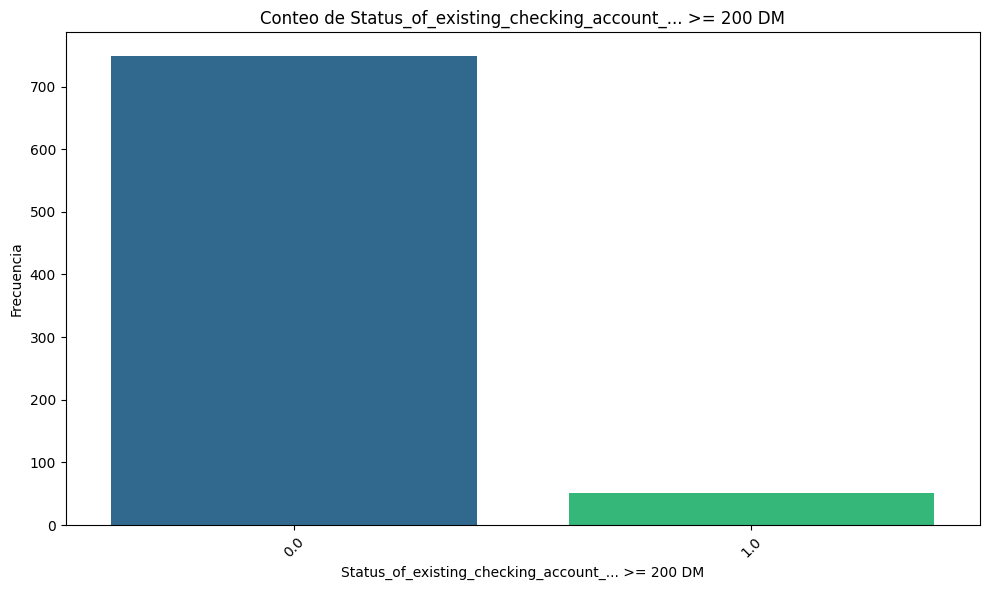

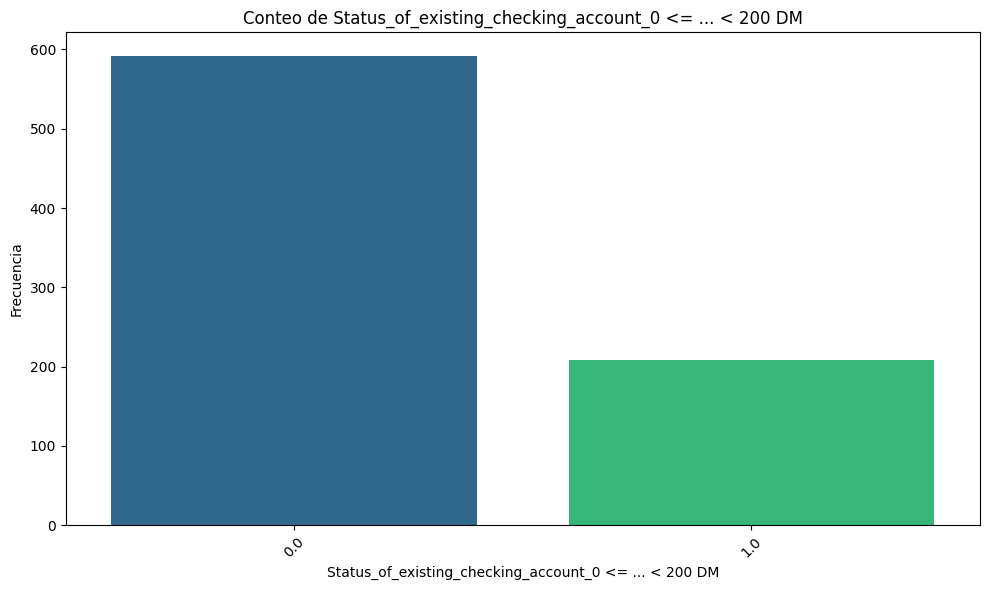

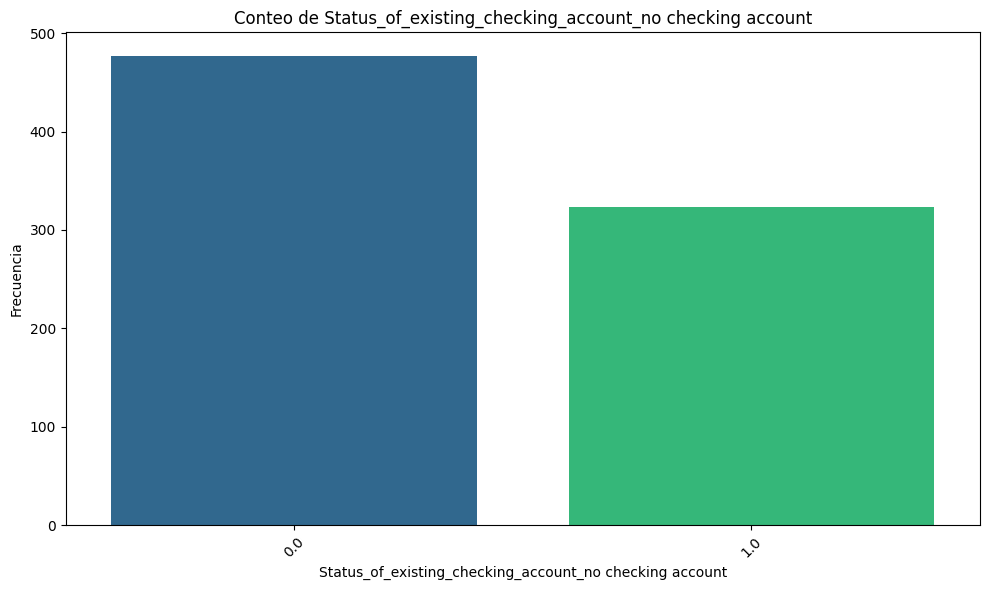

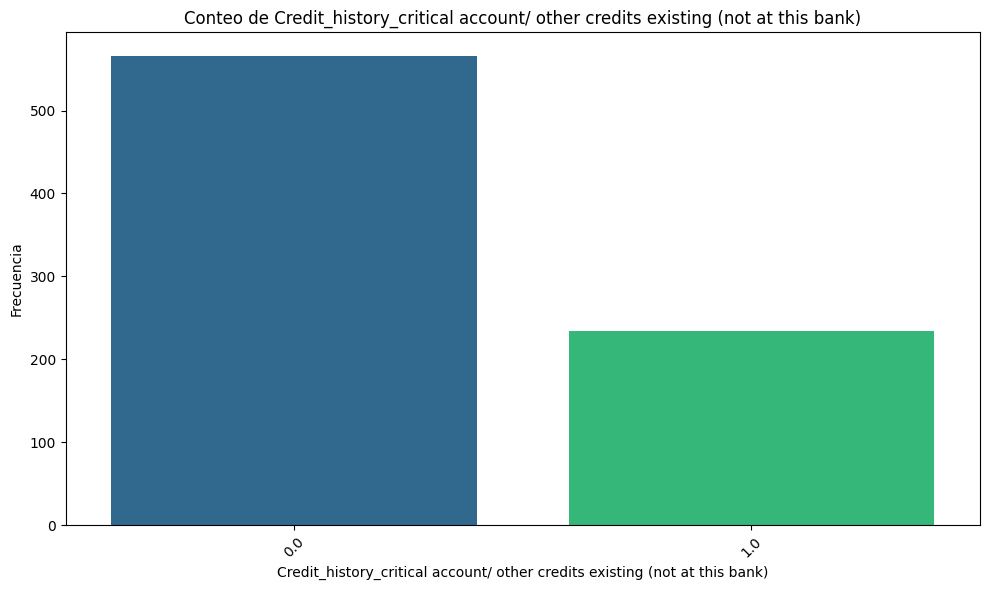

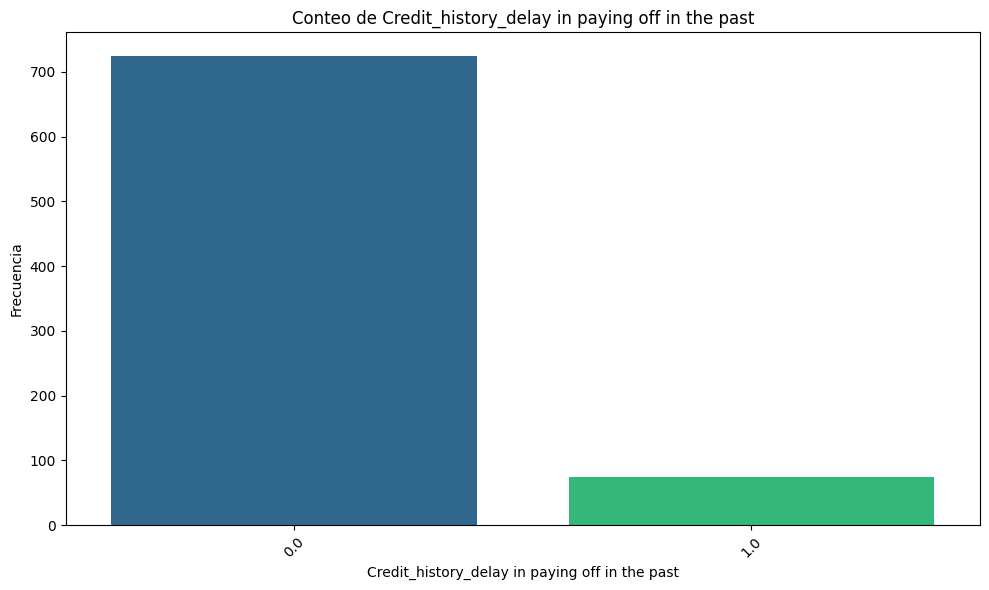

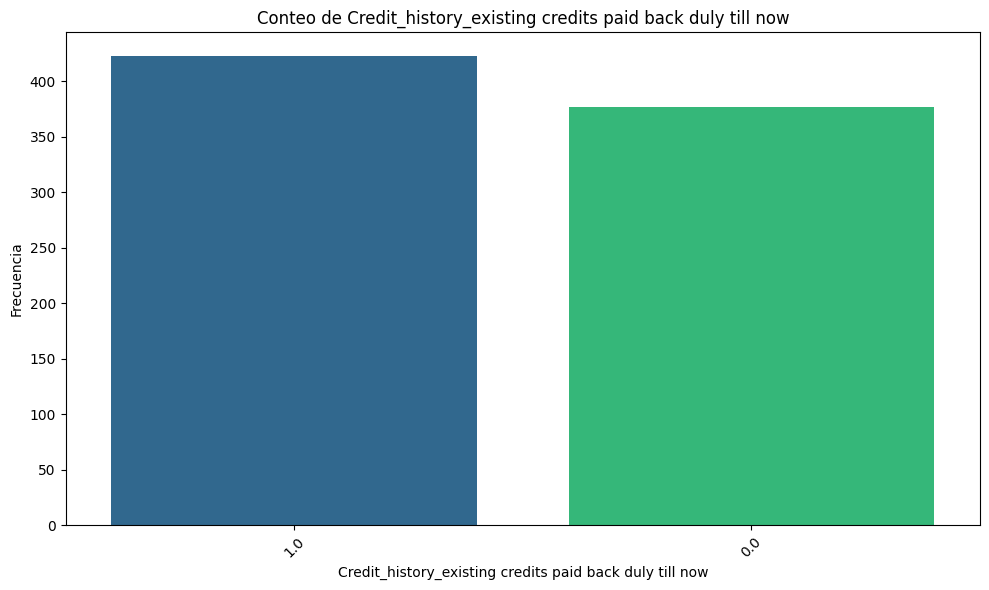

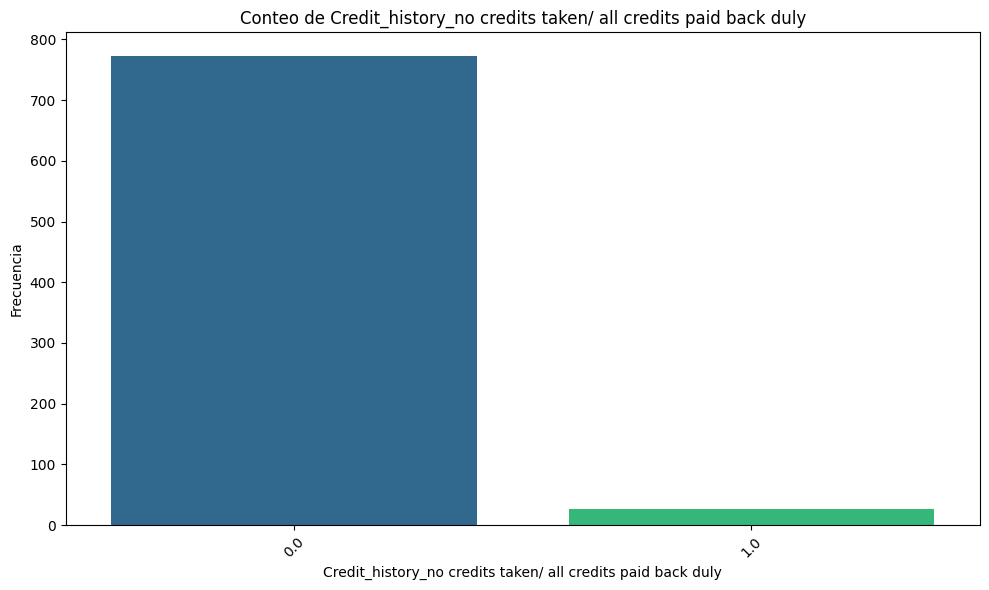

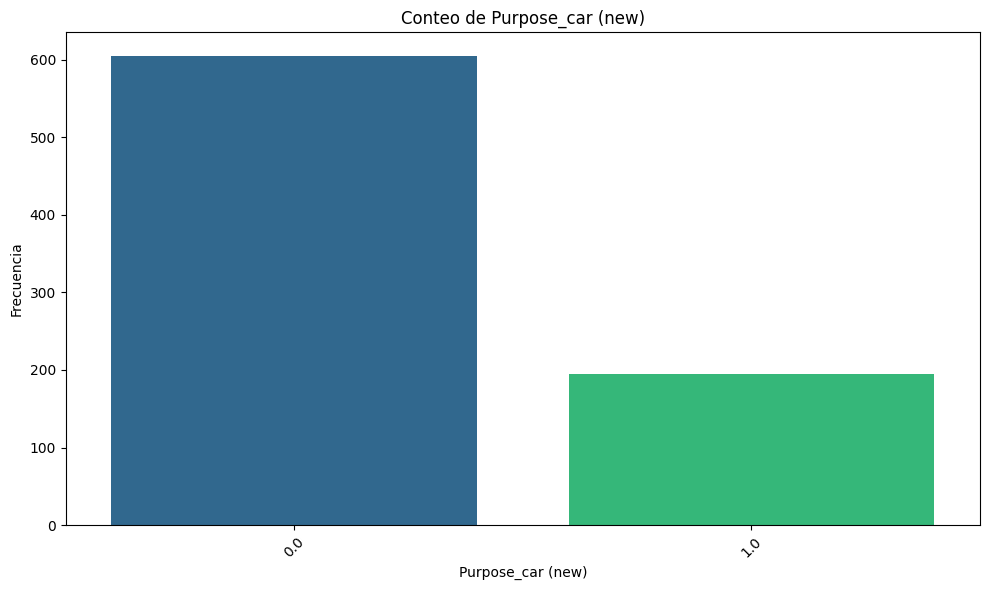

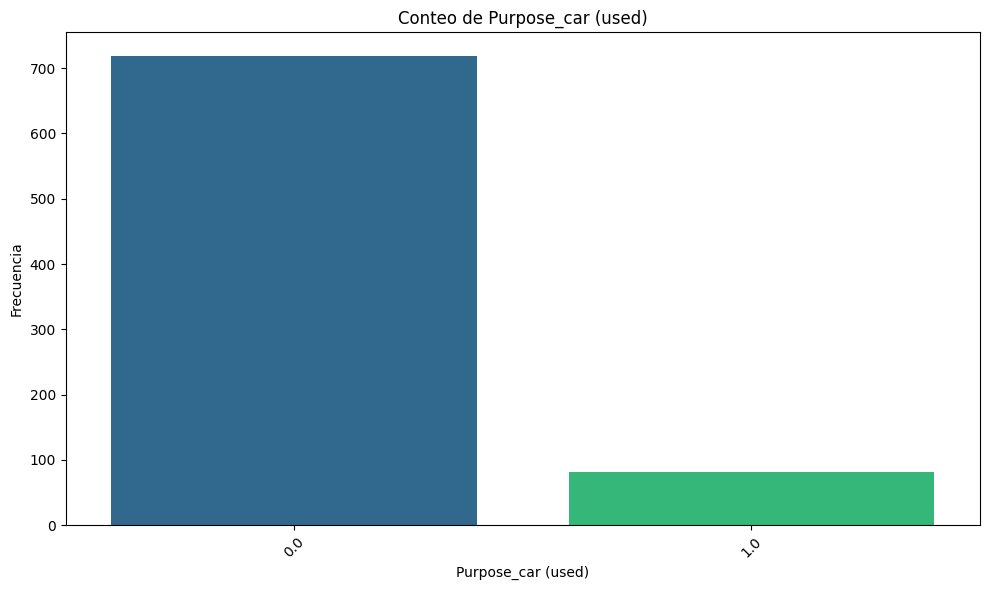

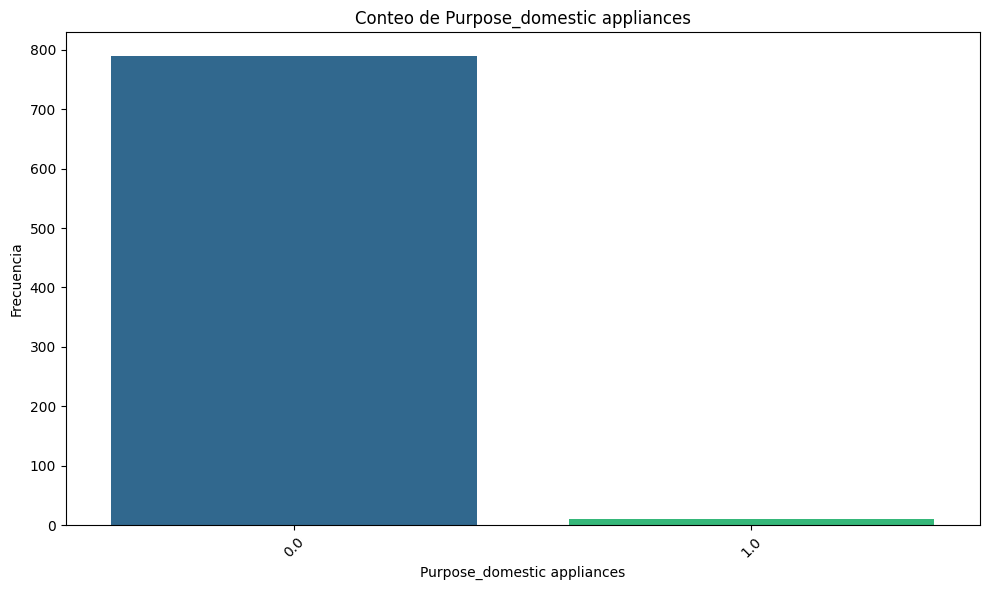

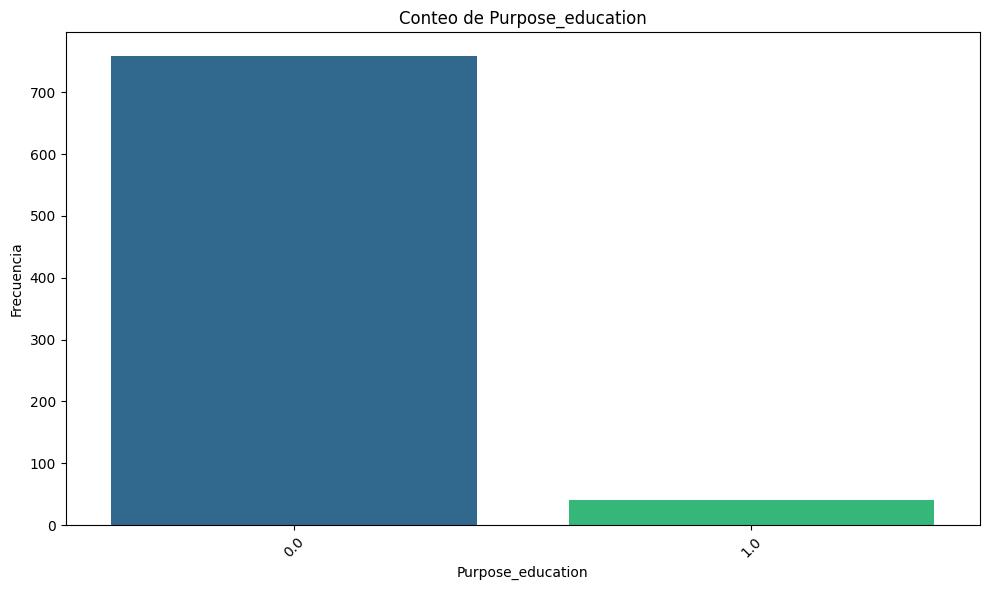

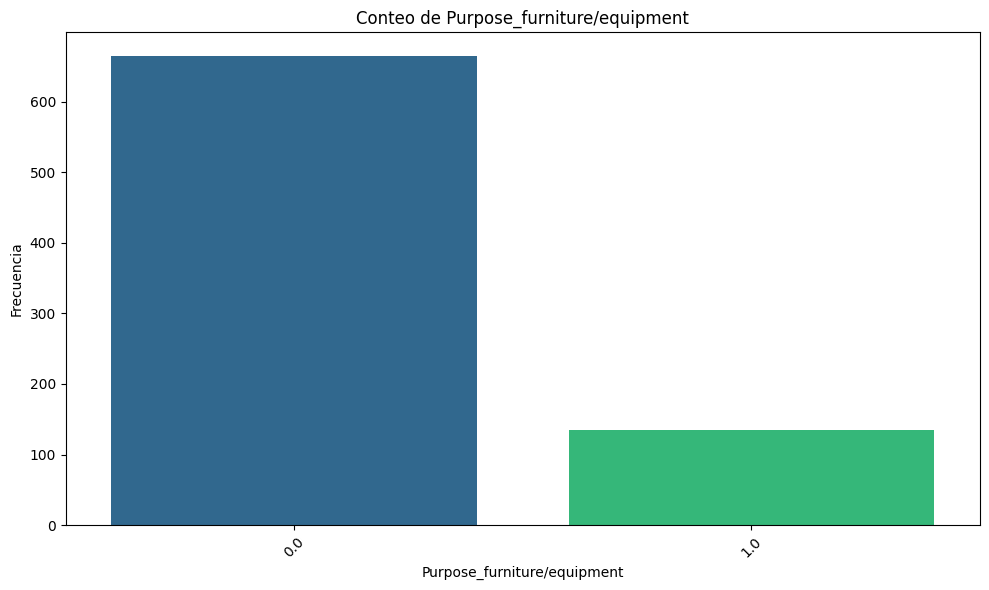

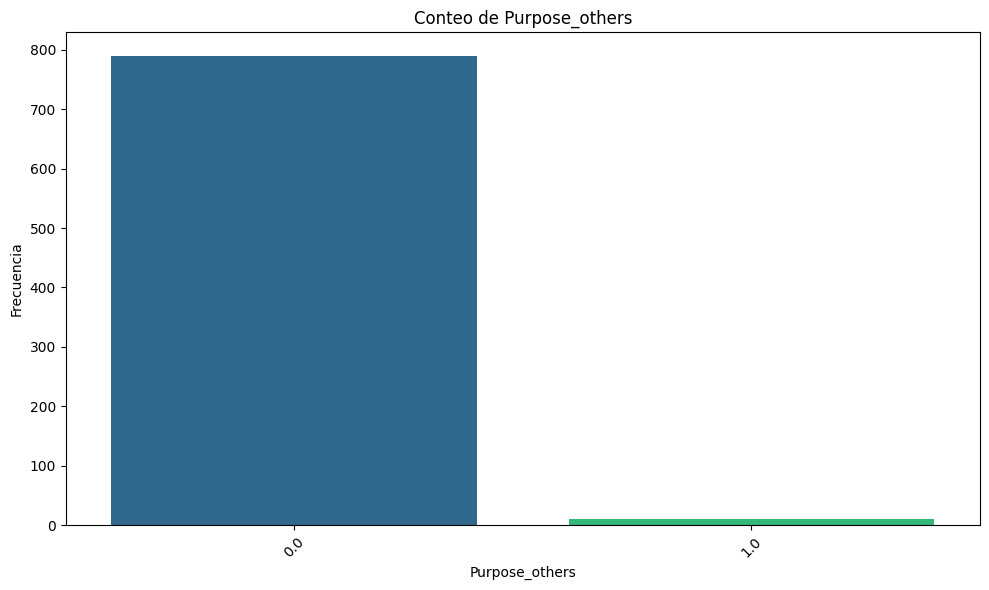

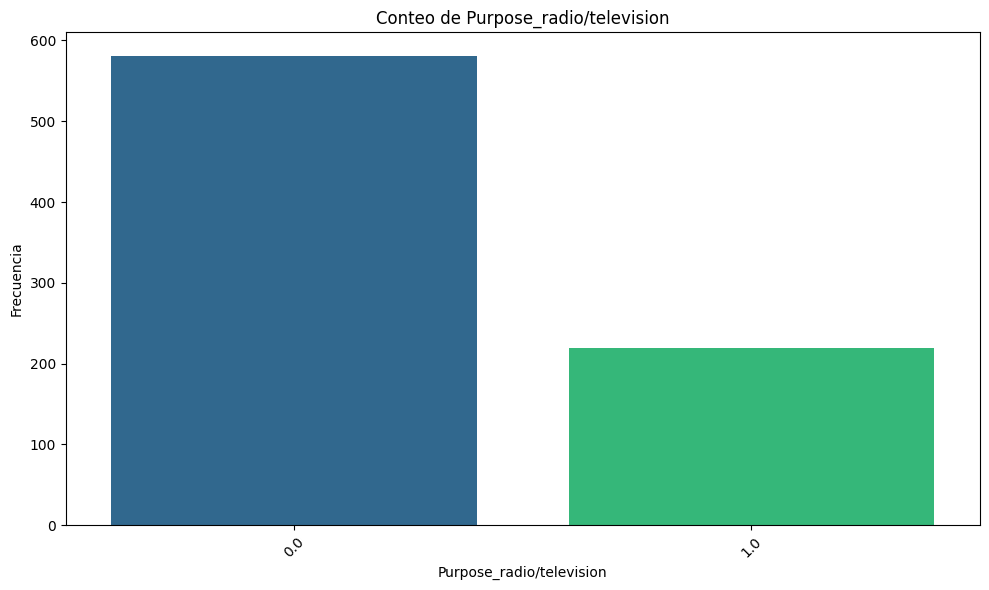

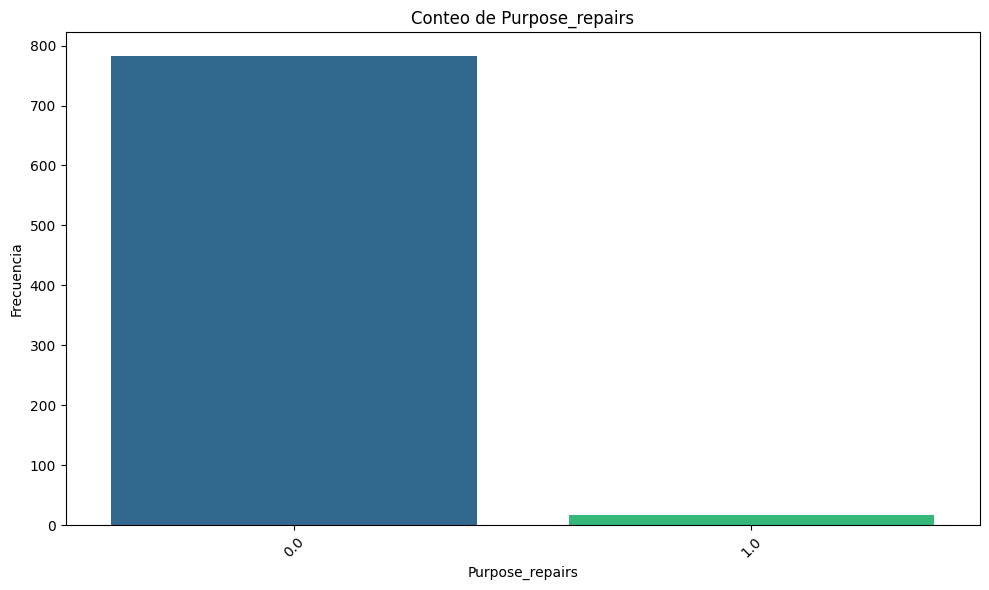

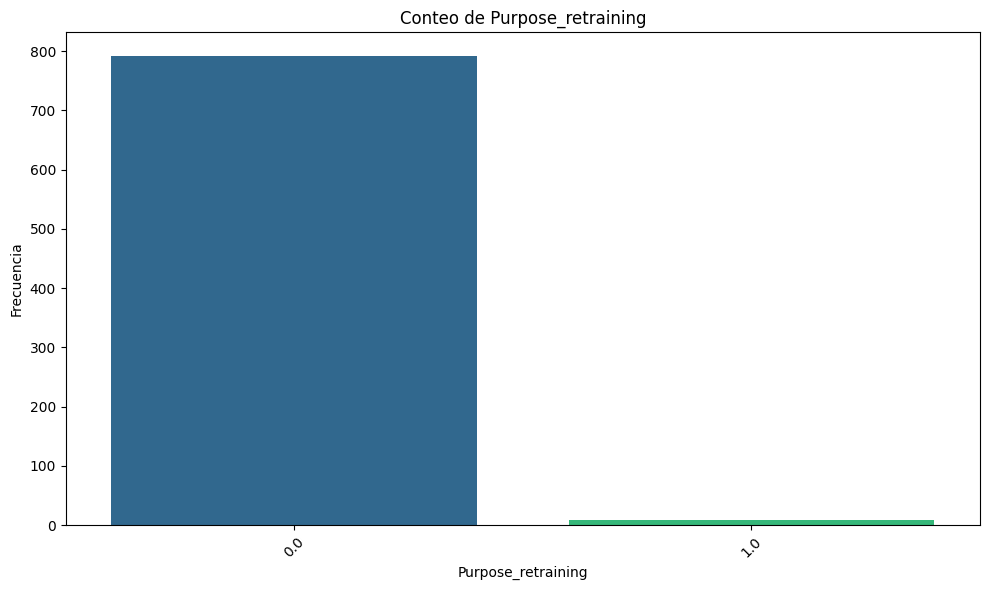

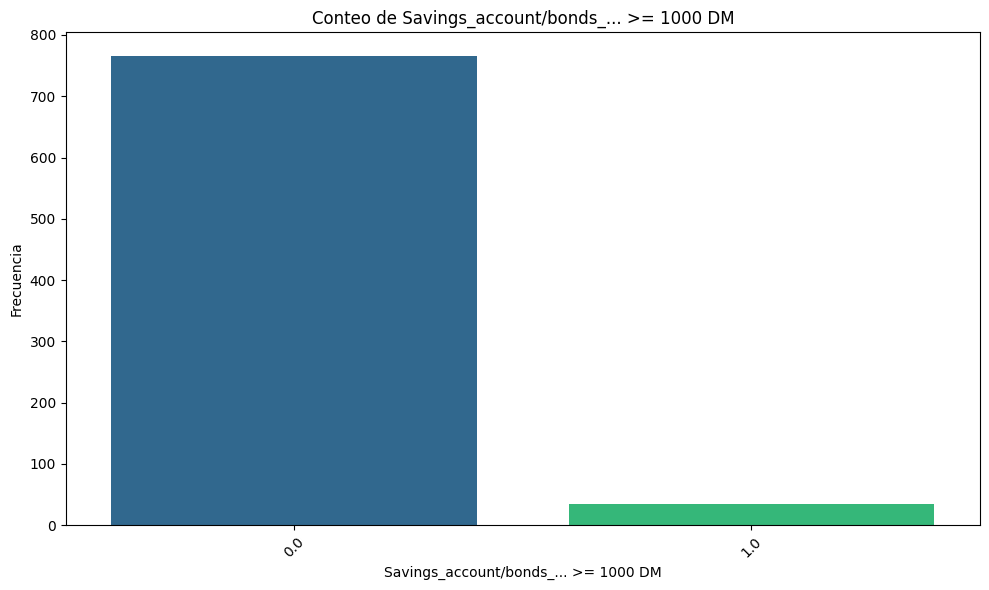

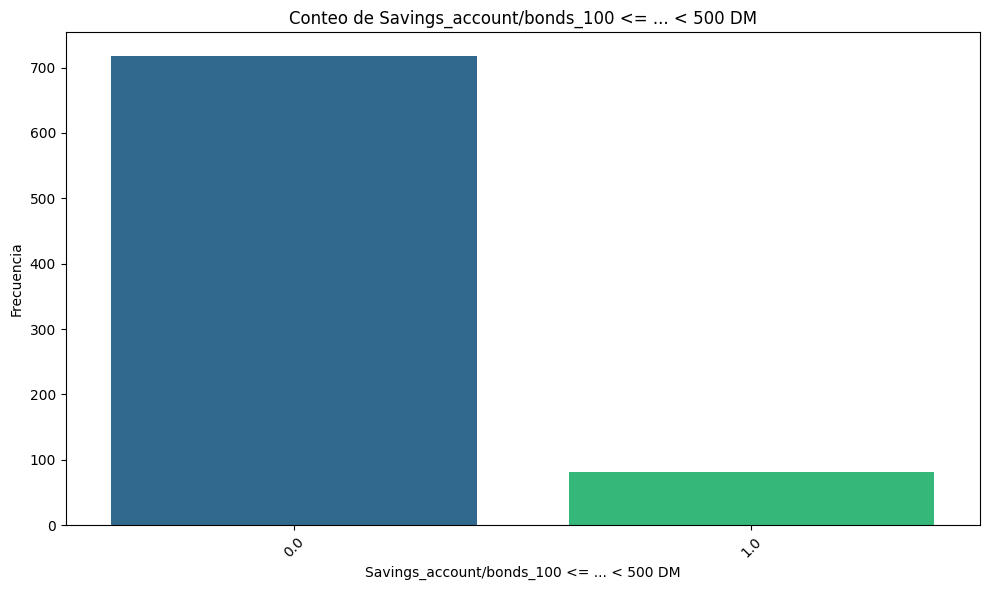

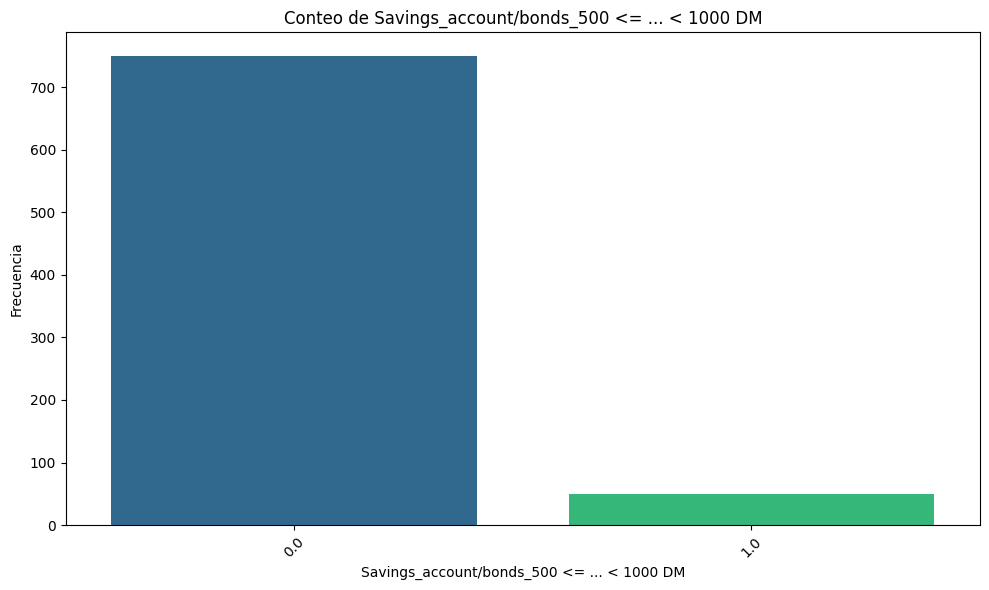

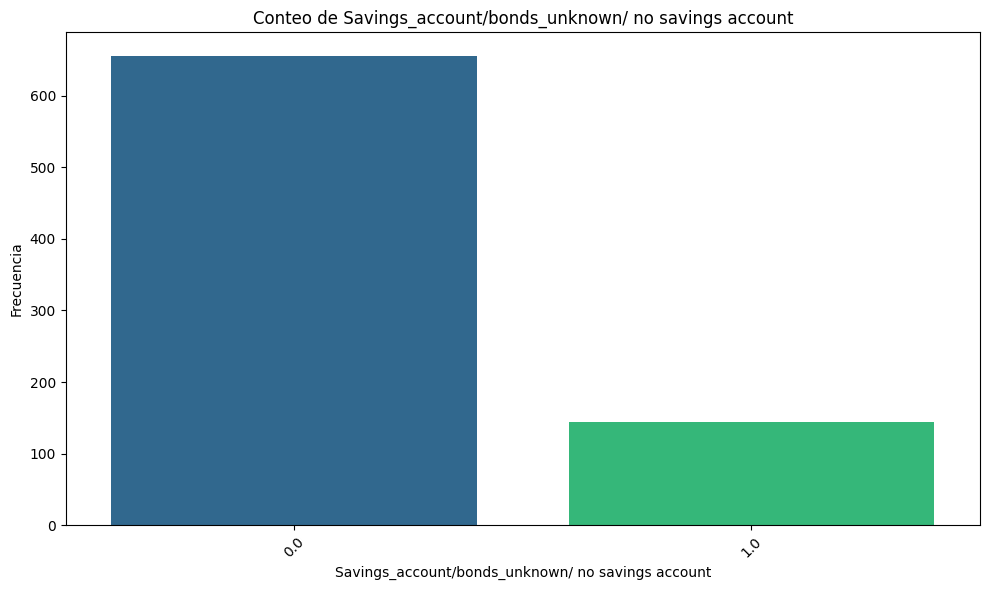

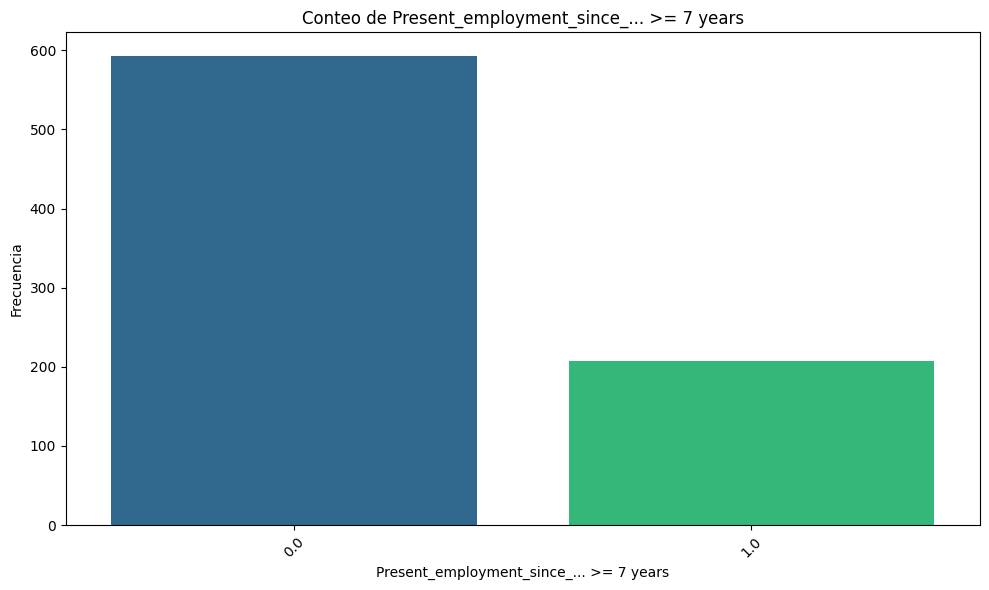

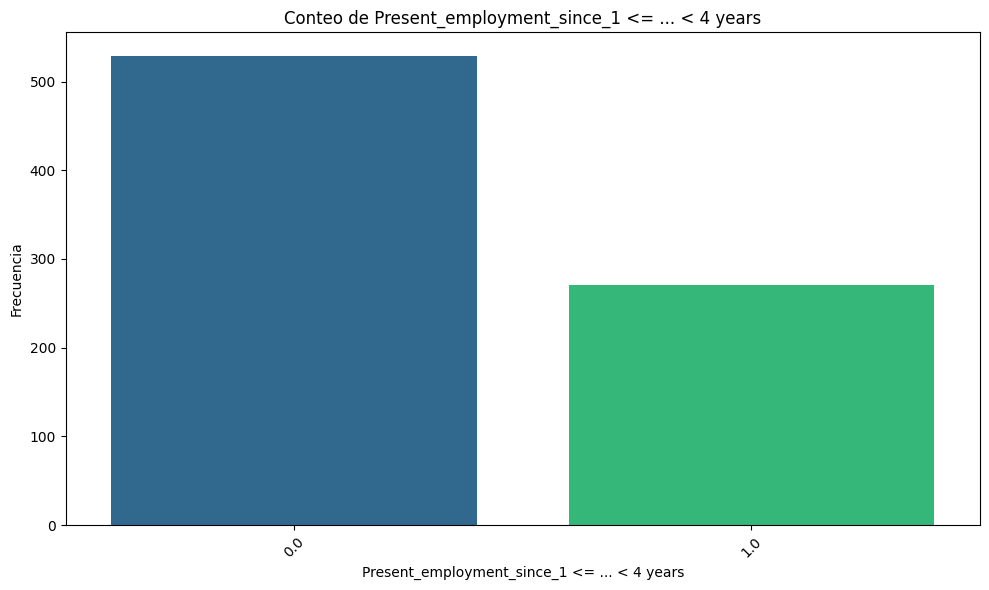

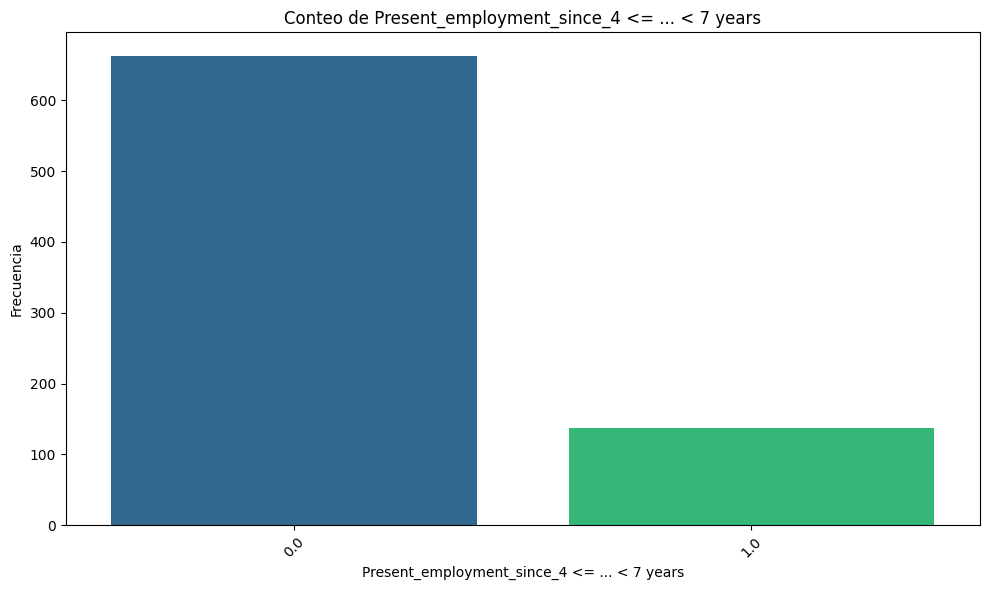

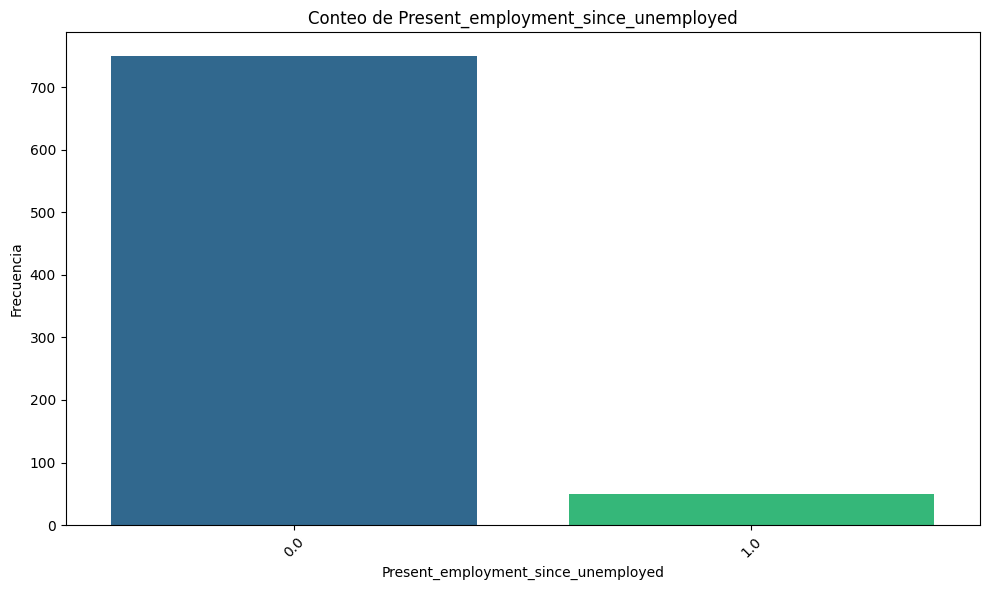

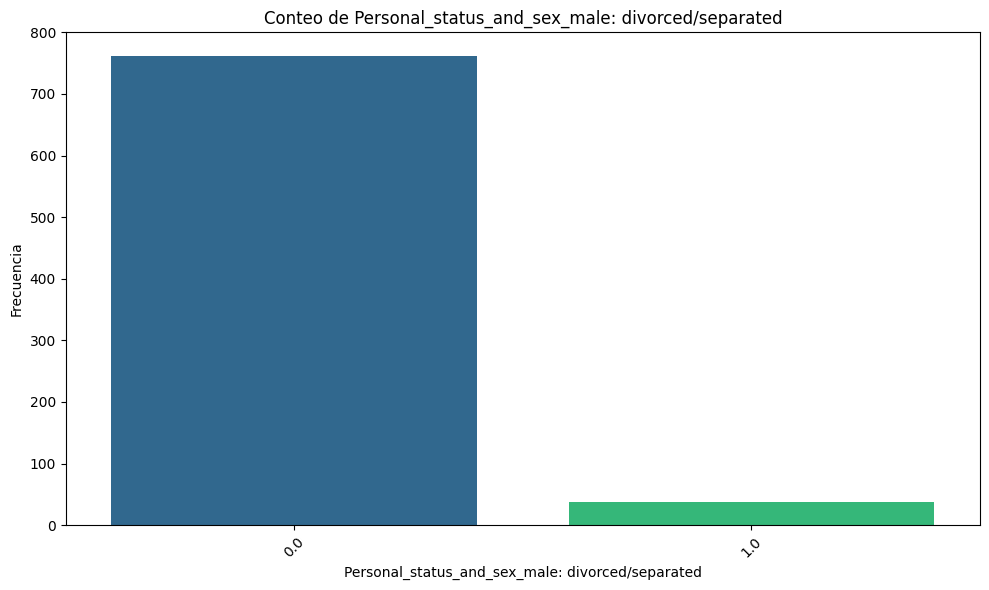

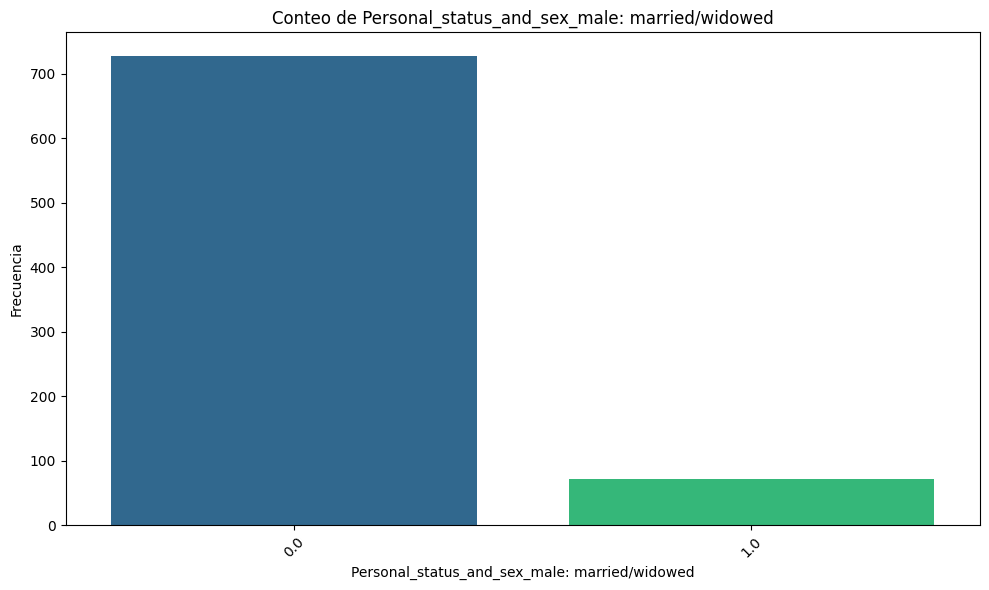

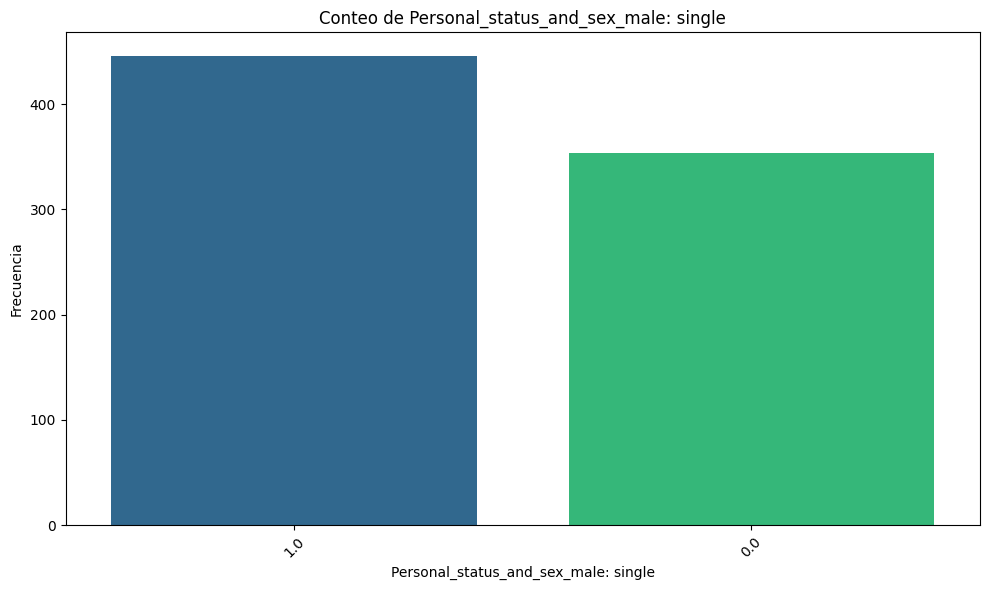

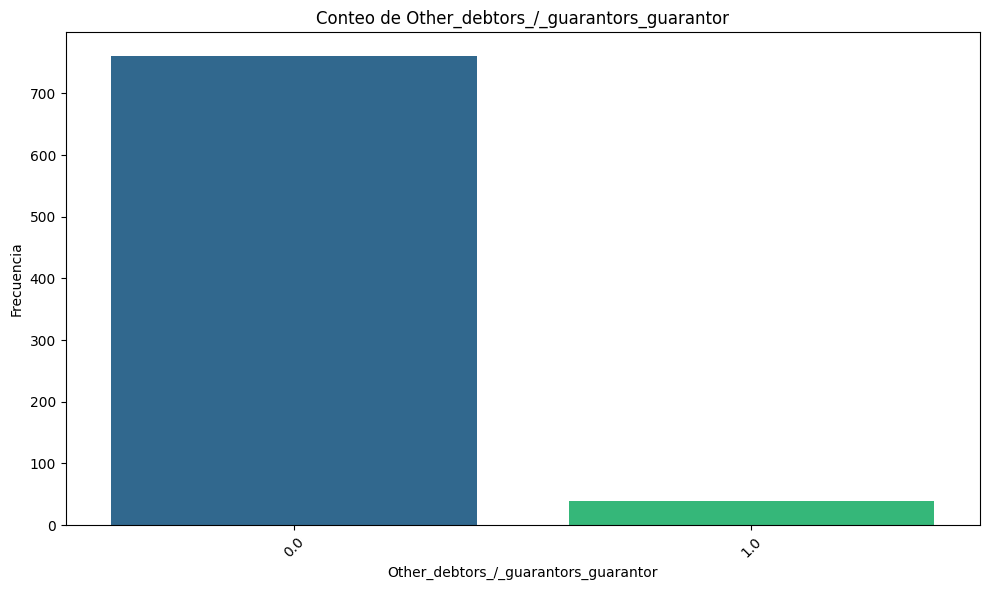

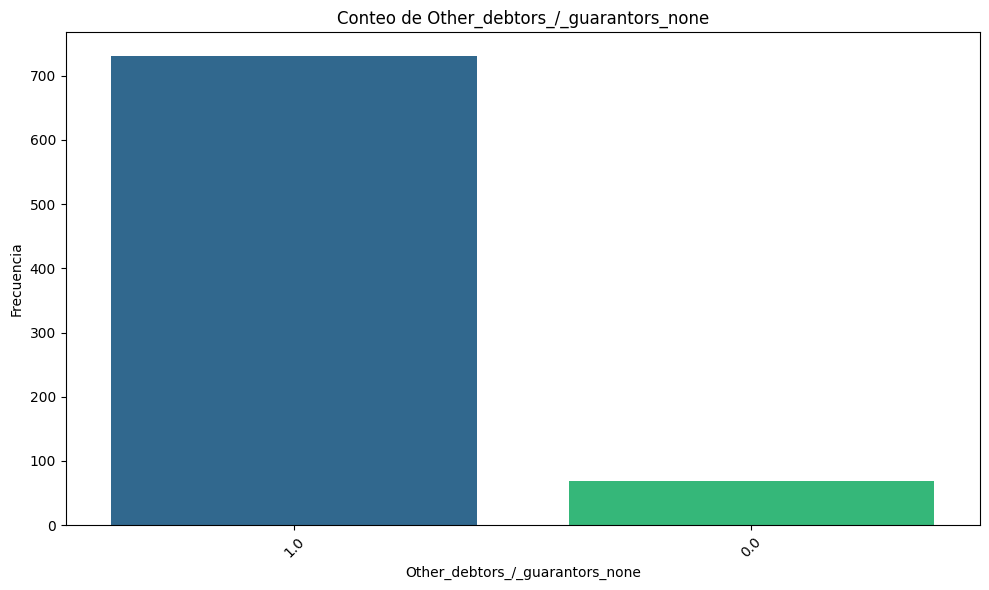

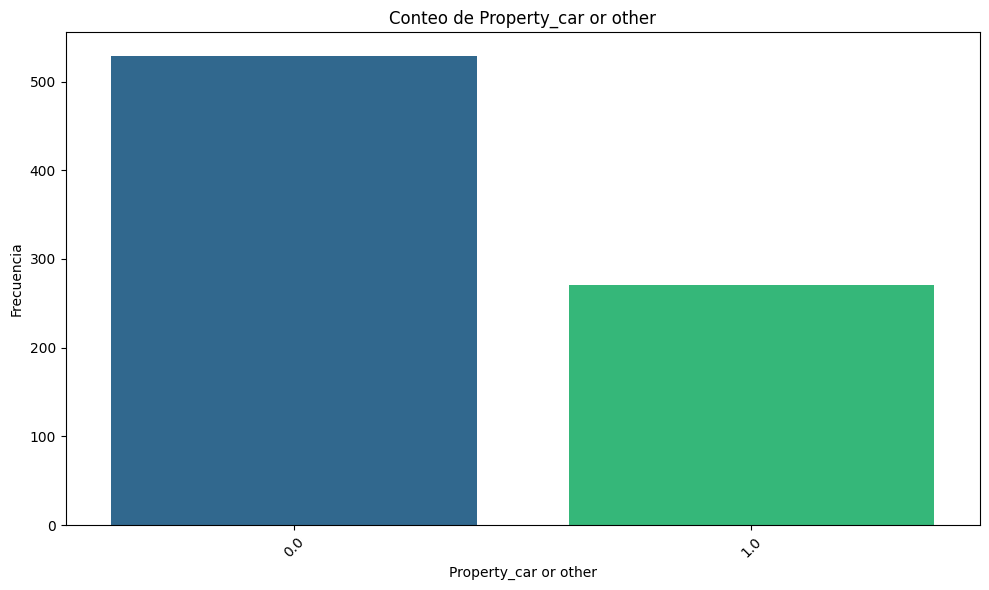

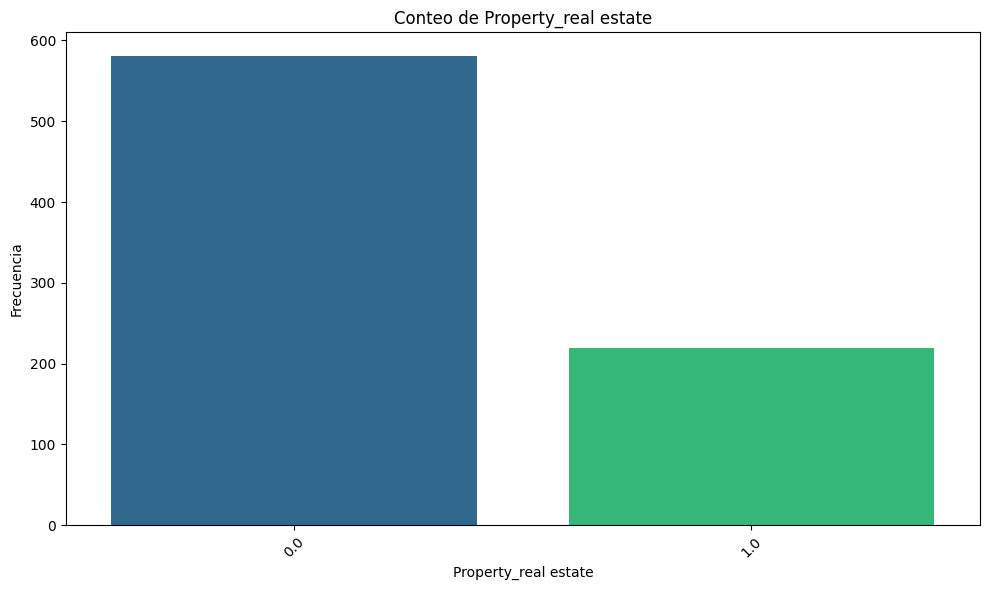

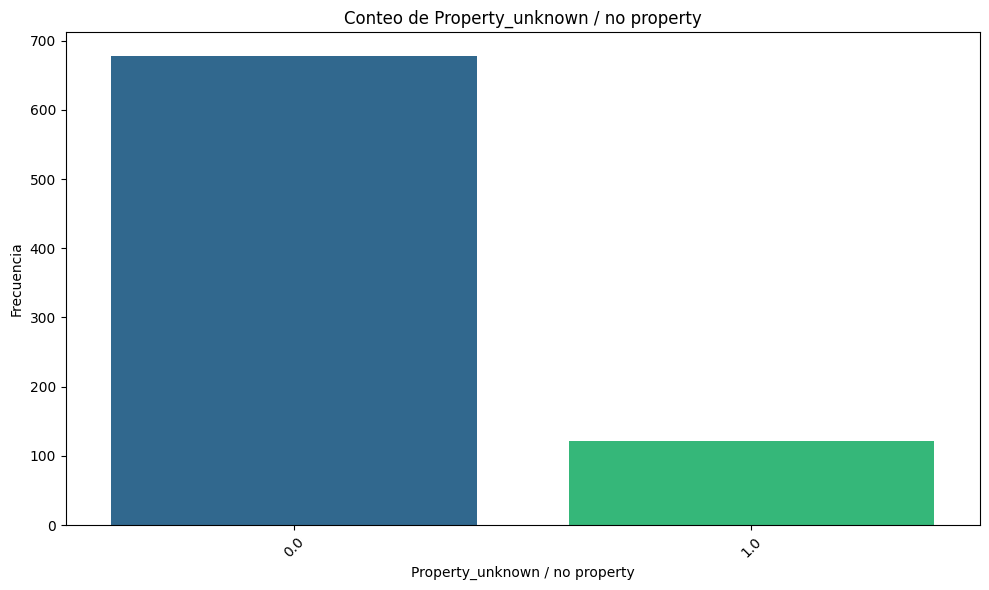

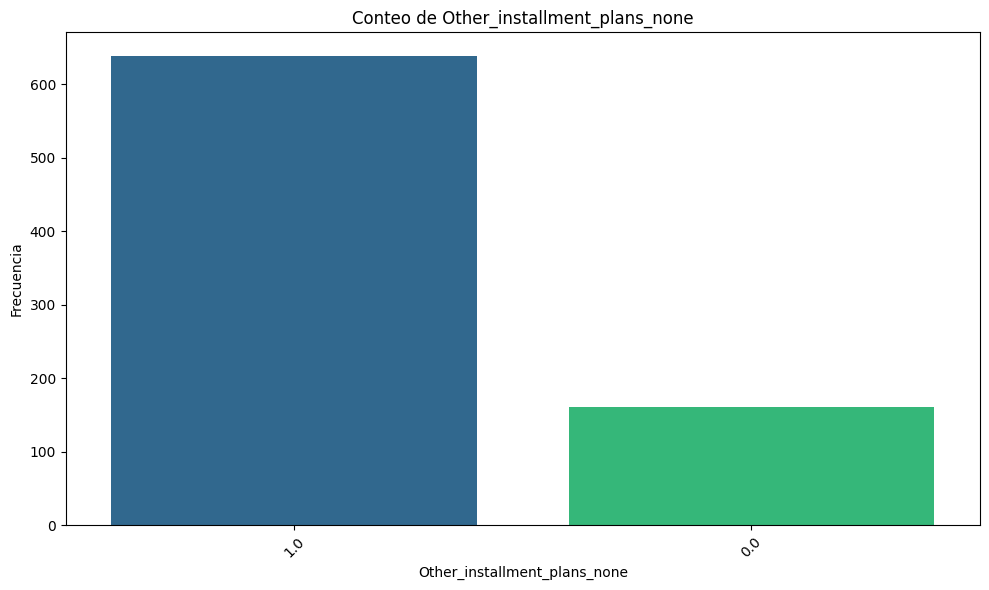

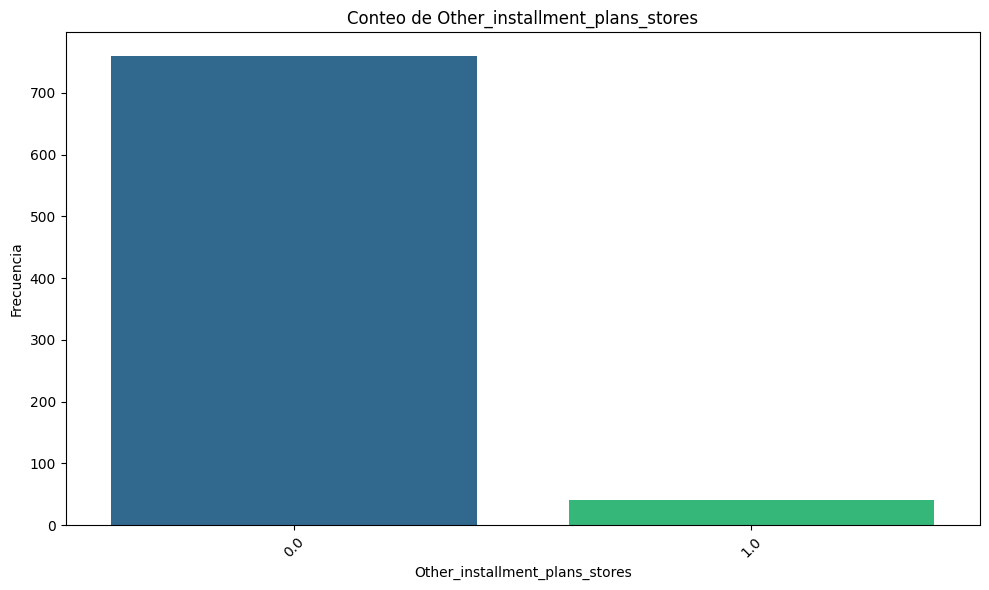

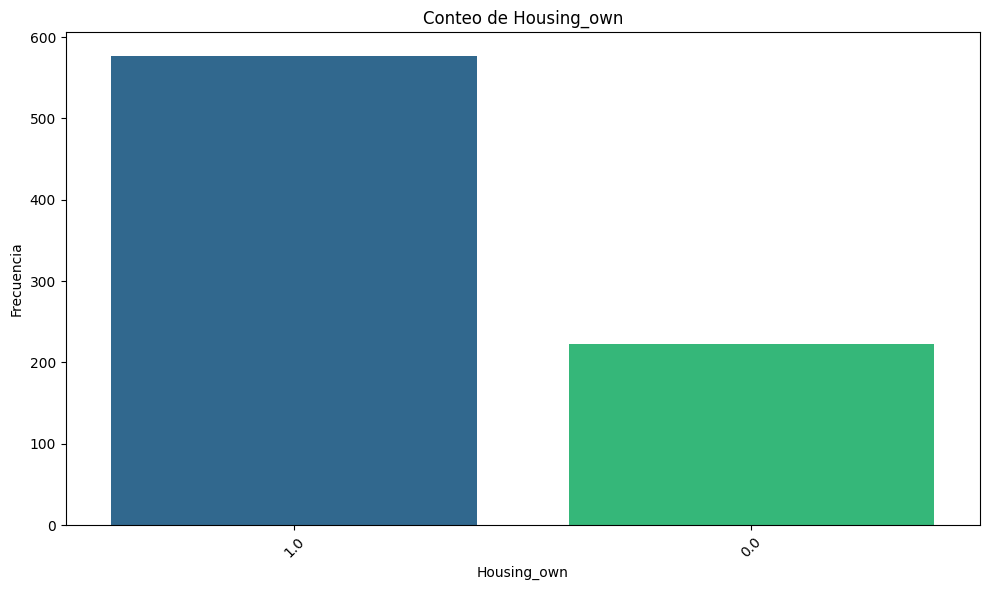

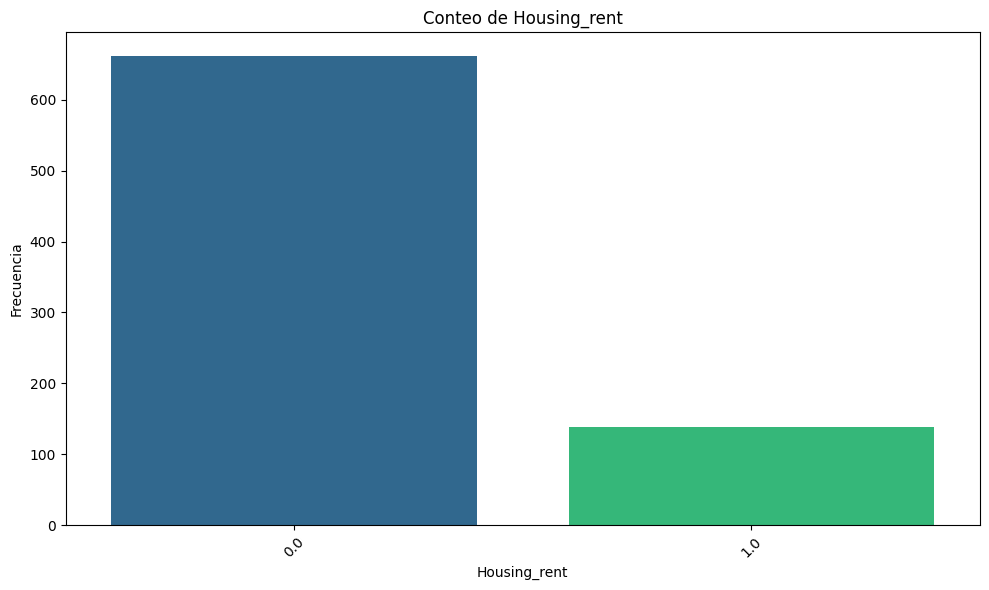

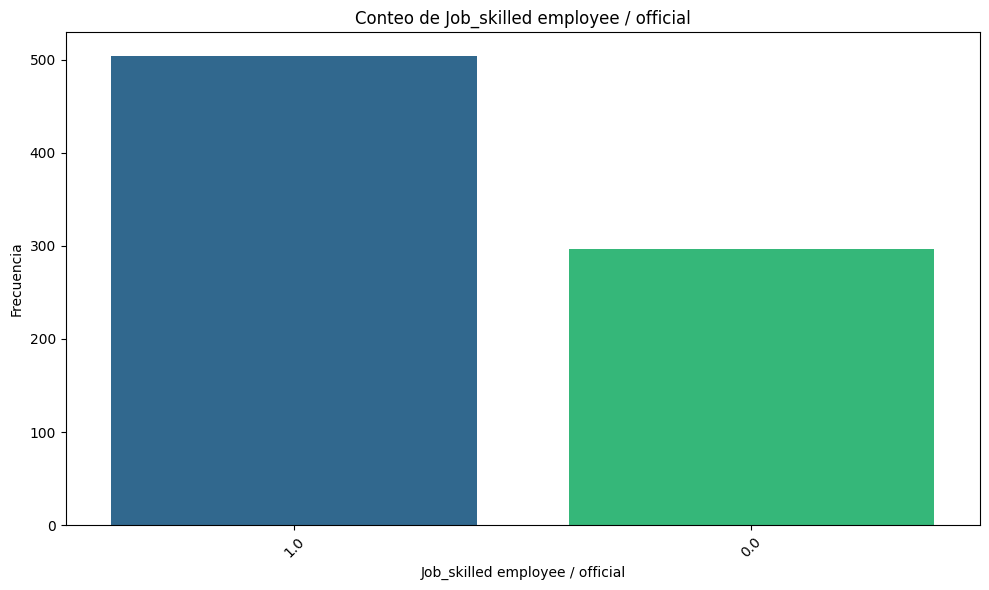

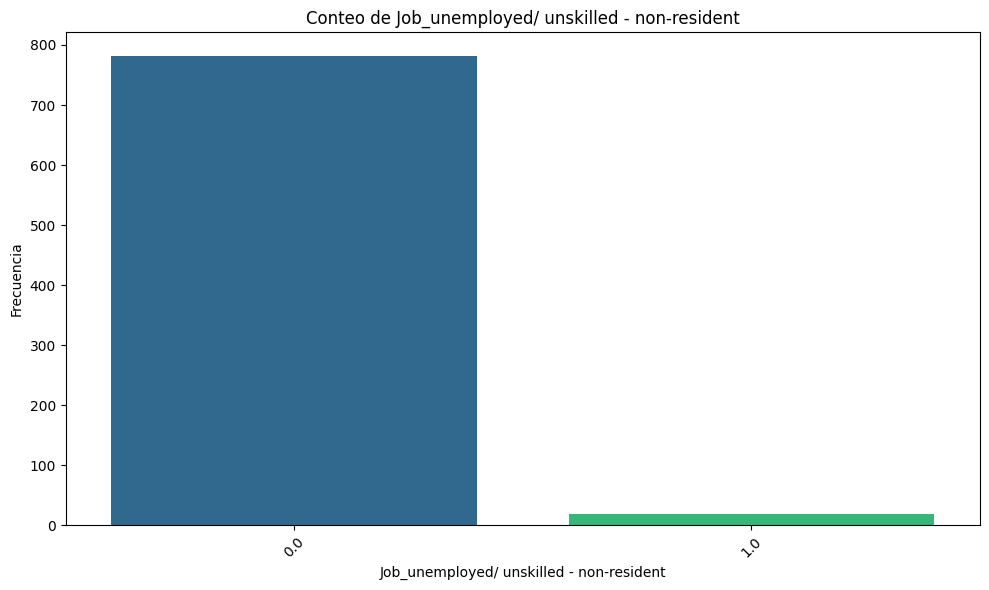

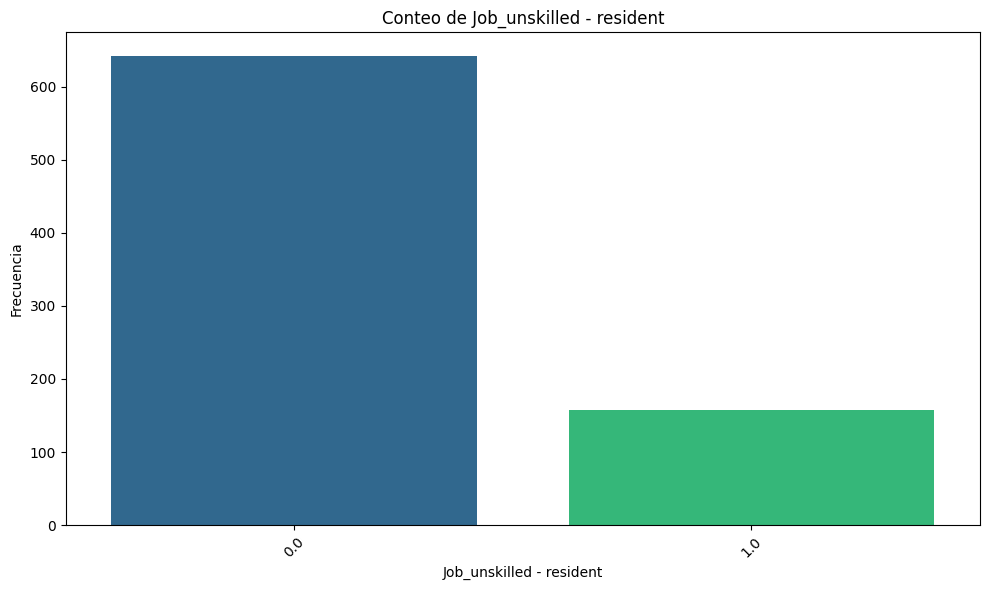

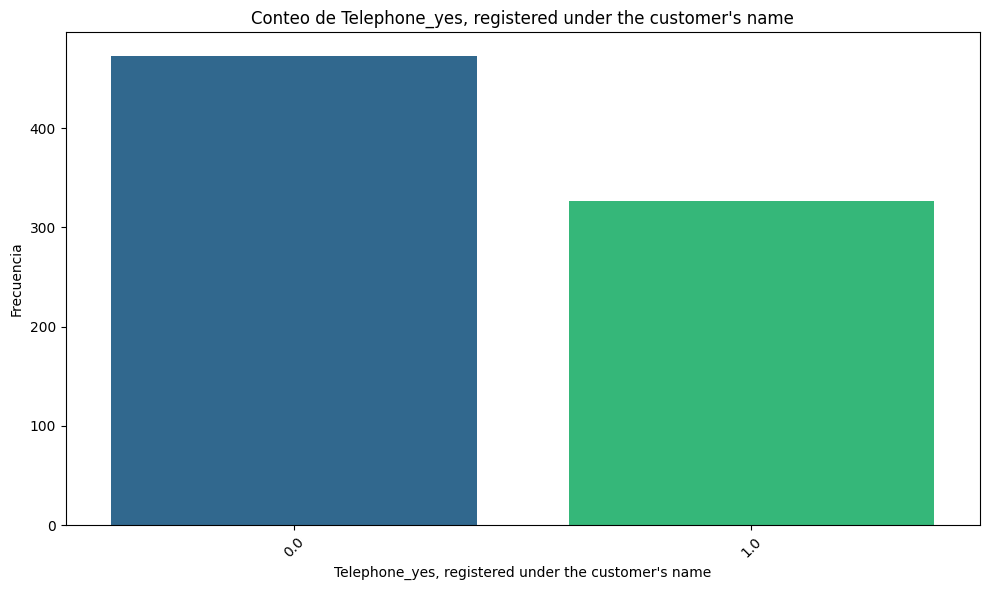

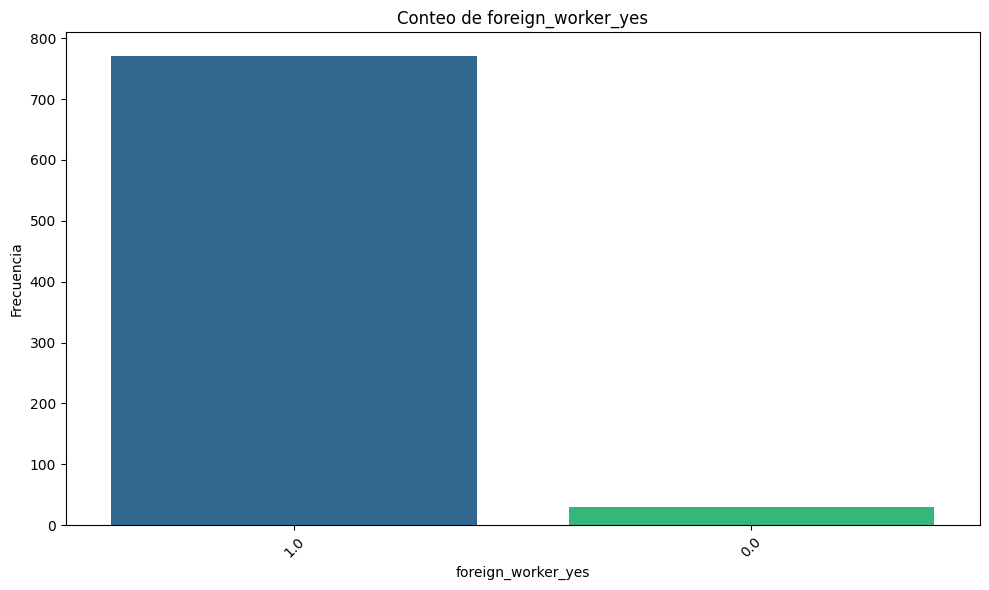

In [83]:
visualize_numerical(X_train_transformed_df, numerical_cols)
visualize_categorical(X_train_transformed_df, ohe_col_names)

# Métodos lineales/cuadráticos

En esta parte del análisis aplicaremos modelos lineales y cuadráticos, como Regresión Logística, Análisis Discriminante Lineal (LDA) y Análisis Discriminante Cuadrático (QDA), para abordar nuestro problema de clasificación. Dado que las clases en nuestro conjunto de datos están desbalanceadas, evaluaremos el rendimiento utilizando métricas como el balanced_accuracy_score, que considera el balance entre las clases calculando el promedio de las tasas de sensibilidad (recall) para cada una. Esto nos permite garantizar que el modelo sea eficaz tanto para la clase mayoritaria como para la minoritaria, proporcionando una evaluación más justa y robusta en este contexto.

## Regresión logística

Ajustando hiperparámetros para Regresión Logística...
Mejores hiperparámetros para Regresión Logística: {'C': 100, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy promedio en validación cruzada: 0.6929

Regresión Logística:
Accuracy en el conjunto de prueba: 0.7300
F1-Score: 0.4808
AUC-ROC: 0.7862

Matriz de confusión:
[[121  19]
 [ 35  25]]

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.78      0.86      0.82       140
           2       0.57      0.42      0.48        60

    accuracy                           0.73       200
   macro avg       0.67      0.64      0.65       200
weighted avg       0.71      0.73      0.72       200



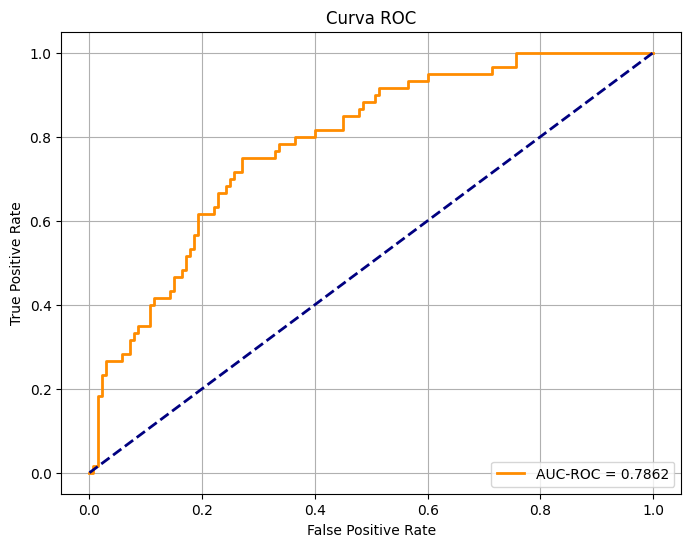

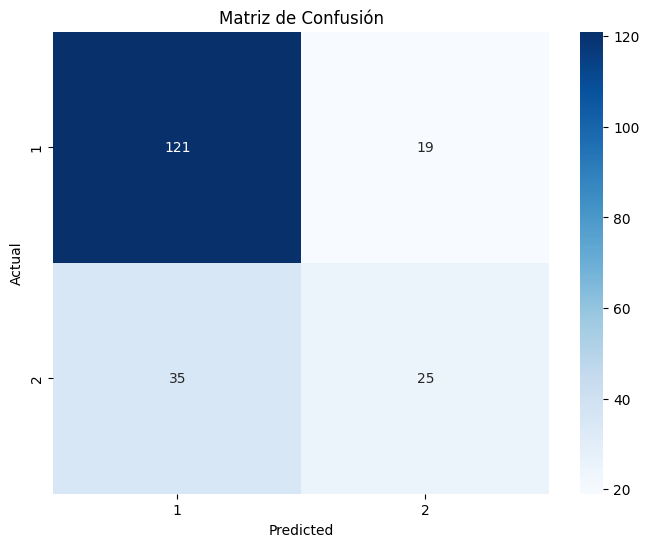

In [84]:
# Configuración de hiperparámetros para la Regresión Logística
param_grid_lr = [
    {
        "penalty": ["l2"],
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ["lbfgs"],
        "max_iter": [500, 1000],
    },
    {
        "penalty": ["l1"],
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ["liblinear", "saga"],
        "max_iter": [500, 1000],
    },
    {
        "penalty": ["elasticnet"],
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ["saga"],
        "l1_ratio": [0.5],
        "max_iter": [500, 1000],
    },
]

# Búsqueda en malla para Regresión Logística
print("Ajustando hiperparámetros para Regresión Logística...")
model_lr = LogisticRegression()
grid_search_lr = GridSearchCV(
    model_lr, 
    param_grid_lr, 
    cv=cv, 
    scoring="balanced_accuracy", 
    n_jobs=-1, 
    verbose=0
)
grid_search_lr.fit(X_train_transformed, y_train)

# Mejor modelo y evaluación
best_lr = grid_search_lr.best_estimator_
print(f"Mejores hiperparámetros para Regresión Logística: {grid_search_lr.best_params_}")
print(f"Accuracy promedio en validación cruzada: {grid_search_lr.best_score_:.4f}")

# Evaluación en el conjunto de prueba
y_pred_lr = best_lr.predict(X_test_transformed)
y_pred_prob = best_lr.predict_proba(X_test_transformed)[:, 1]  # Probabilidad de la clase positiva

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr, pos_label=2)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("\nRegresión Logística:")
print(f"Accuracy en el conjunto de prueba: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred_lr))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_lr))

# Visualización de la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=2)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC-ROC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Visualización de la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2], yticklabels=[1, 2])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de Confusión")
plt.show()


El modelo de Regresión Logística, optimizado con los mejores hiperparámetros, obtuvo un accuracy del 73.50 % en el conjunto de prueba, lo que indica un desempeño global moderado. Sin embargo, el análisis por clase revela una notable disparidad en el rendimiento. La clase mayoritaria (1) tiene un recall del 87 % y un F1-Score de 0.82, lo que demuestra que el modelo identifica con alta precisión a los clientes que no deberían recibir un préstamo. Por otro lado, la clase minoritaria (2) presenta un recall del 42 % y un F1-Score de 0.49, reflejando dificultades para clasificar correctamente a los clientes que deberían recibir un préstamo.

El AUC-ROC de 0.7514 sugiere que el modelo tiene una capacidad moderada para distinguir entre ambas clases, aunque persisten problemas en la identificación de la clase minoritaria. La matriz de confusión confirma que 35 clientes de la clase 2 fueron clasificados incorrectamente como no aptos (falsos negativos), mientras que 18 clientes de la clase 1 fueron clasificados erróneamente como aptos (falsos positivos).

## LDA

In [85]:

# Ajustar el modelo LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_transformed, y_train)

# Predicción en el conjunto de prueba
y_pred_lda = lda.predict(X_test_transformed)
y_proba_lda = lda.predict_proba(X_test_transformed)[:, 1]  # Probabilidad para la clase positiva


# Evaluación del modelo LDA
accuracy_lda = accuracy_score(y_test, y_pred_lda)
balanced_acc_lda = balanced_accuracy_score(y_test, y_pred_lda)  # Balanced Accuracy
f1_lda = classification_report(y_test, y_pred_lda, output_dict=True)["2"]["f1-score"]
auc_roc_lda = roc_auc_score(y_test, y_proba_lda)

# Imprimir resultados
print("Linear Discriminant Analysis (LDA):")
print(f"Accuracy: {accuracy_lda:.4f}")
print(f"Balanced Accuracy: {balanced_acc_lda:.4f}")
print(f"F1-Score: {f1_lda:.4f}")
print(f"AUC-ROC: {auc_roc_lda:.4f}")
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred_lda))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_lda))



Linear Discriminant Analysis (LDA):
Accuracy: 0.7450
Balanced Accuracy: 0.6607
F1-Score: 0.5143
AUC-ROC: 0.7900

Matriz de confusión:
[[122  18]
 [ 33  27]]

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.79      0.87      0.83       140
           2       0.60      0.45      0.51        60

    accuracy                           0.74       200
   macro avg       0.69      0.66      0.67       200
weighted avg       0.73      0.74      0.73       200



El modelo de Análisis Discriminante Lineal (LDA) alcanzó un accuracy de 72.50 %, un resultado ligeramente inferior al de la Regresión Logística. Similarmente, el modelo muestra un desempeño desigual entre las clases. Para la clase mayoritaria (1), el recall fue del 86 %, mientras que para la clase minoritaria (2), este valor fue de solo 42 %. Esto se traduce en un F1-Score de 0.81 para la clase 1 y de 0.48 para la clase 2.

El AUC-ROC de 0.7492 es comparable al de la Regresión Logística, lo que indica que el modelo también tiene una capacidad moderada para distinguir entre ambas clases. La matriz de confusión revela que el modelo clasificó incorrectamente a 35 clientes de la clase 2 como no aptos (falsos negativos) y a 20 clientes de la clase 1 como aptos (falsos positivos). Estos resultados sugieren que LDA, al igual que la Regresión Logística, enfrenta desafíos significativos para identificar correctamente la clase minoritaria, probablemente debido a su enfoque lineal y el desbalance en los datos.

## QDA


Quadratic Discriminant Analysis (QDA):
Accuracy en el conjunto de prueba: 0.6900
Balanced Accuracy en el conjunto de prueba: 0.6357
F1-Score: 0.4918
AUC-ROC: 0.7246

Matriz de confusión:
[[108  32]
 [ 30  30]]

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.78      0.77      0.78       140
           2       0.48      0.50      0.49        60

    accuracy                           0.69       200
   macro avg       0.63      0.64      0.63       200
weighted avg       0.69      0.69      0.69       200



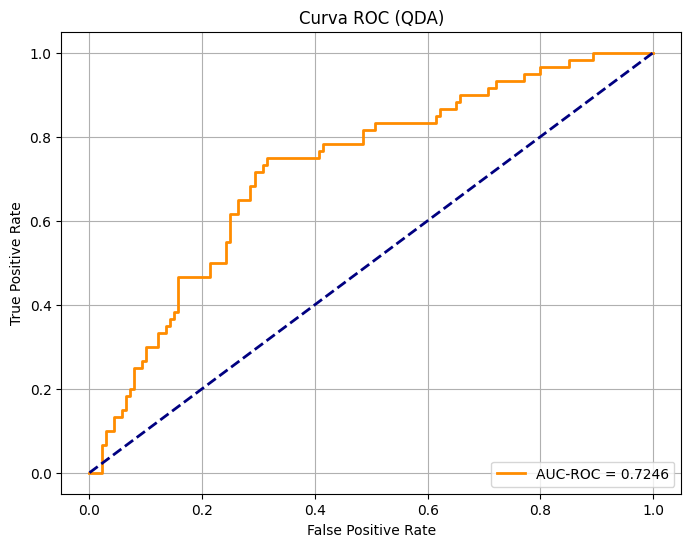

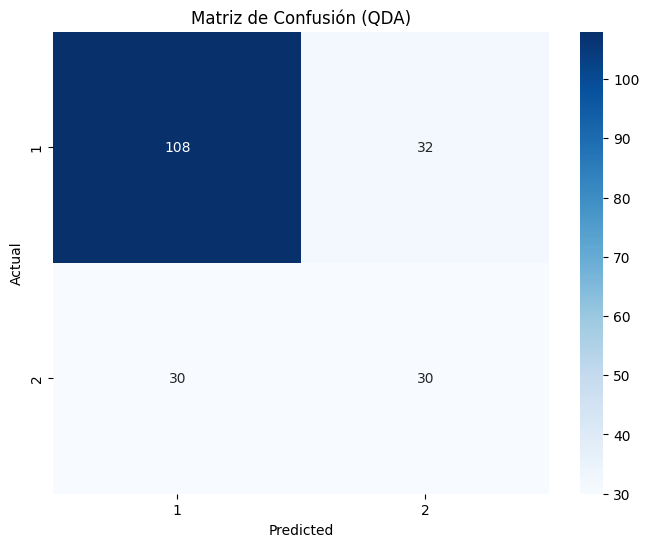

In [86]:

# Crear y entrenar el modelo QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_transformed, y_train)

# Predicciones en el conjunto de prueba
y_pred_qda = qda.predict(X_test_transformed)
y_pred_prob_qda = qda.predict_proba(X_test_transformed)[:, 1]  # Probabilidad de la clase positiva

# Calcular métricas
accuracy_qda = accuracy_score(y_test, y_pred_qda)
balanced_acc_qda = balanced_accuracy_score(y_test, y_pred_qda)  # Balanced Accuracy
f1_qda = f1_score(y_test, y_pred_qda, pos_label=2)
roc_auc_qda = roc_auc_score(y_test, y_pred_prob_qda)

print("\nQuadratic Discriminant Analysis (QDA):")
print(f"Accuracy en el conjunto de prueba: {accuracy_qda:.4f}")
print(f"Balanced Accuracy en el conjunto de prueba: {balanced_acc_qda:.4f}")
print(f"F1-Score: {f1_qda:.4f}")
print(f"AUC-ROC: {roc_auc_qda:.4f}")


# Matriz de confusión
conf_matrix_qda = confusion_matrix(y_test, y_pred_qda)
print("\nMatriz de confusión:")
print(conf_matrix_qda)

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_qda))

# Visualización de la curva ROC
fpr_qda, tpr_qda, thresholds_qda = roc_curve(y_test, y_pred_prob_qda, pos_label=2)
plt.figure(figsize=(8, 6))
plt.plot(fpr_qda, tpr_qda, color="darkorange", lw=2, label=f"AUC-ROC = {roc_auc_qda:.4f}")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC (QDA)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_qda, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2], yticklabels=[1, 2])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de Confusión (QDA)")
plt.show()


# **Análisis de Resultados**

Los tres modelos (**Regresión Logística**, **LDA**, y **QDA**) presentan resultados variados en términos de desempeño global (**accuracy**) y en métricas específicas como **precision**, **recall** y **f1-score**. A continuación, el análisis detallado:

---

## **1. Regresión Logística**

- **Accuracy**: **0.7300** (intermedio entre los modelos lineales).  
- **Clase 1**:  
  - **Precision**: **0.78** → Buen desempeño al evitar falsos positivos.  
  - **Recall**: **0.86** → Detecta correctamente la mayoría de los ejemplos de la clase mayoritaria.  
  - **F1-score**: **0.82** → Excelente balance entre precision y recall.  
- **Clase 2**:  
  - **Precision**: **0.57** → Moderada, muestra problemas para evitar falsos positivos.  
  - **Recall**: **0.42** → Bajo, no detecta correctamente muchos ejemplos de la clase minoritaria.  
  - **F1-score**: **0.48** → Limitado, debido al bajo recall.  
- **Comentario**:  
  - Regresión Logística tiene buen desempeño en la **clase mayoritaria**, pero dificultades significativas en la **clase minoritaria**. Es adecuada para problemas donde el enfoque está en la clase más representada.

---

## **2. Linear Discriminant Analysis (LDA)**

- **Accuracy**: **0.7450** (el mejor entre los modelos lineales).  
- **Balanced Accuracy**: **0.6607** → Buen balance general entre las clases.  
- **Clase 1**:  
  - **Precision**: **0.79** → Buen manejo de falsos positivos.  
  - **Recall**: **0.87** → Excelente detección de ejemplos en la clase mayoritaria.  
  - **F1-score**: **0.83** → Desempeño robusto.  
- **Clase 2**:  
  - **Precision**: **0.60** → Mejor que en los otros modelos lineales.  
  - **Recall**: **0.45** → Moderado, aunque superior al de Regresión Logística.  
  - **F1-score**: **0.51** → El mejor entre los tres modelos lineales.  
- **Comentario**:  
  - LDA es el modelo más balanceado entre clases, mostrando el mejor desempeño en términos de **balanced accuracy** y métricas asociadas a la **clase minoritaria**.

---

## **3. Quadratic Discriminant Analysis (QDA)**

- **Accuracy**: **0.6900** (el más bajo de los modelos lineales).  
- **Balanced Accuracy**: **0.6357** → Menor que LDA, pero aún aceptable.  
- **Clase 1**:  
  - **Precision**: **0.78** → Similar a los otros modelos.  
  - **Recall**: **0.77** → Competitivo, aunque inferior a LDA.  
  - **F1-score**: **0.78** → Sólido desempeño.  
- **Clase 2**:  
  - **Precision**: **0.48** → Limitada en evitar falsos positivos.  
  - **Recall**: **0.50** → Ligeramente mejor que la Regresión Logística.  
  - **F1-score**: **0.49** → Competitivo con los otros modelos lineales.  
- **Comentario**:  
  - QDA muestra un desempeño más equilibrado que la Regresión Logística en la **clase minoritaria**, pero es menos consistente que LDA en términos generales.

---

## **4. Análisis Global**

### **Clase mayoritaria (1 = "good"):**
- Todos los modelos tienen un desempeño adecuado, con **LDA** mostrando el mejor recall (**0.87**).  
- **Regresión Logística** y **QDA** ofrecen precisión competitiva, pero su recall es inferior al de LDA.

### **Clase minoritaria (2 = "bad"):**
- **LDA** se destaca como el modelo con mejor desempeño en **recall** (**0.45**) y **f1-score** (**0.51**), mostrando un balance razonable.  
- **Regresión Logística** tiene el peor recall (**0.42**), limitando su utilidad para esta clase.  
- **QDA** tiene un desempeño intermedio, con un f1-score de **0.49**.

---

## **Modelo recomendado:**
- **LDA** es la mejor opción si buscamos un desempeño balanceado entre ambas clases, especialmente si priorizamos la **clase minoritaria**.  
- **Regresión Logística** es útil para maximizar la precisión global, pero tiene dificultades con la clase minoritaria.  
- **QDA** puede ser competitivo en entornos donde un modelo cuadrático pueda capturar mejor la relación entre variables, pero es superado por LDA en general.


## Métodos No Lineales

En este apartado usaremos métodos no lineales para intentar predecir los valores, nosotros vamos a escoger SVC, Random Forest y GradientBoostingClassifier.
Como nuestros datos estan desbalanceados en relación a la variable objetivo la métrica que utilizaremos en los modelos será balanced_accuracy ya que esta da igual importancia a las clases mayoritarias y minoritarias y penaliza los modelos que ignoran la clase minoritaria.

In [87]:
# 1) SVM con kernel RBF
svm = SVC(kernel='rbf', probability=True)  # probability=True para obtener probabilidades (para ROC)
param_svm = {
    'C': 10**np.linspace(-3, 3, 101),          
    'gamma': [0.001, 0.01, 0.1, 1],              
    'degree': [2, 3, 4],                        
    'class_weight': [None, 'balanced'],       
    'shrinking': [True, False],
}

# 2) Random Forest
rf = RandomForestClassifier(random_state=random)
param_rf = {
    'n_estimators': [5,10,25,40, 50, 75,100, 200], 
    'criterion':['gini', 'entropy'], 
    'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
    'min_samples_leaf':[1,2,3,5,10]
}

# 3) Gradient Boosting
gb = GradientBoostingClassifier(random_state=random)
param_gb = {
    'n_estimators': [25, 50, 75, 100], 
    'loss':['log_loss', 'exponential'], 
    'criterion':['friedman_mse', 'squared_error'], 
    'max_depth':[None, 2, 5, 8, 10, 15],
    'min_samples_leaf':[1,2,3,5,10], 
    'learning_rate':[0.1, 1, 10]
}

# GridSearchCV para SVM
grid_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_svm,
    cv=cv,
    scoring='balanced_accuracy',
    n_jobs=-1
)

# GridSearchCV para Random Forest
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_rf,
    cv=cv,
    scoring='balanced_accuracy',
    n_jobs=-1
)

# GridSearchCV para Gradient Boosting
grid_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_gb,
    cv=cv,
    scoring='balanced_accuracy',
    n_jobs=-1
)



NameError: name 'np' is not defined

In [155]:
grid_svm.fit(X_train_transformed, y_train)
grid_rf.fit(X_train_transformed, y_train)
grid_gb.fit(X_train_transformed, y_train)

# Extraer los mejores modelos (ya entrenados con sus mejores hiperparámetros)
best_svm = grid_svm.best_estimator_
best_rf = grid_rf.best_estimator_
best_gb = grid_gb.best_estimator_

print("Mejores hiperparámetros para SVM:", grid_svm.best_params_)
print("Mejor score de validación cruzada para SVM:", grid_svm.best_score_)

print("\nMejores hiperparámetros para Random Forest:", grid_rf.best_params_)
print("Mejor score de validación cruzada para Random Forest:", grid_rf.best_score_)

print("\nMejores hiperparámetros para Gradient Boosting:", grid_gb.best_params_)
print("Mejor score de validación cruzada para Gradient Boosting:", grid_gb.best_score_)


# Predicciones
y_pred_svm = best_svm.predict(X_test_transformed)
y_pred_rf = best_rf.predict(X_test_transformed)
y_pred_gb = best_gb.predict(X_test_transformed)

# Métricas de clasificación (accuracy, precision, recall, f1, etc.)
print("=== SVM (RBF) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

print("\n=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

print("\n=== Gradient Boosting ===")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))


Mejores hiperparámetros para SVM: {'C': np.float64(12.02264434617413), 'class_weight': 'balanced', 'degree': 2, 'gamma': 0.01, 'shrinking': True}
Mejor score de validación cruzada para SVM: 0.7321428571428571

Mejores hiperparámetros para Random Forest: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 75}
Mejor score de validación cruzada para Random Forest: 0.6523809523809524

Mejores hiperparámetros para Gradient Boosting: {'criterion': 'squared_error', 'learning_rate': 1, 'loss': 'exponential', 'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 100}
Mejor score de validación cruzada para Gradient Boosting: 0.705357142857143
=== SVM (RBF) ===
Accuracy: 0.715
              precision    recall  f1-score   support

           1       0.85      0.72      0.78       140
           2       0.52      0.70      0.60        60

    accuracy                           0.71       200
   macro avg       0.68      0.71      0.69       200
weighted avg       0.


ROC AUC Scores:
SVM (RBF): 0.7766666666666667
Random Forest: 0.7611904761904762
Gradient Boosting: 0.7511904761904762


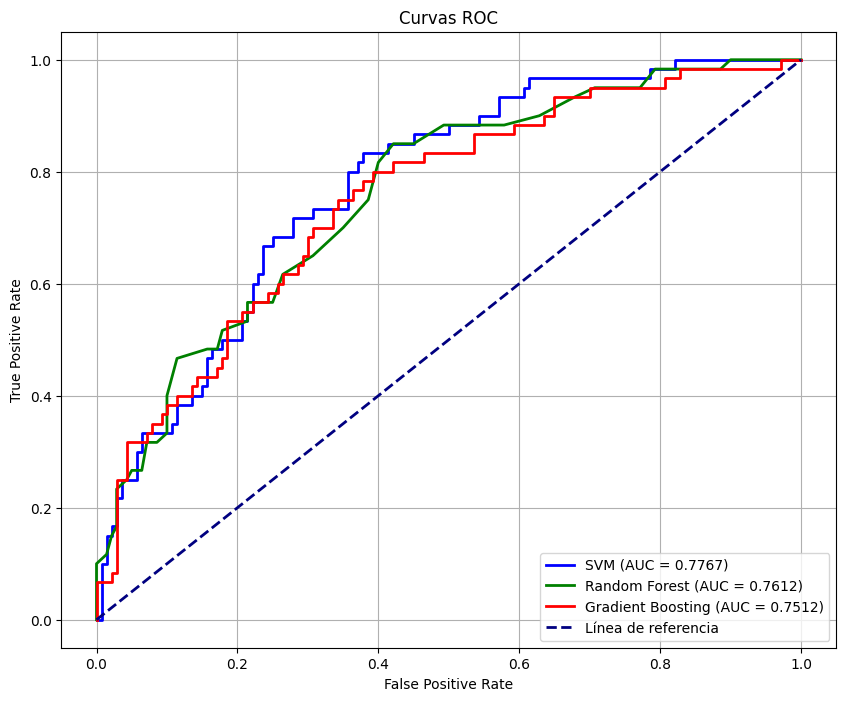

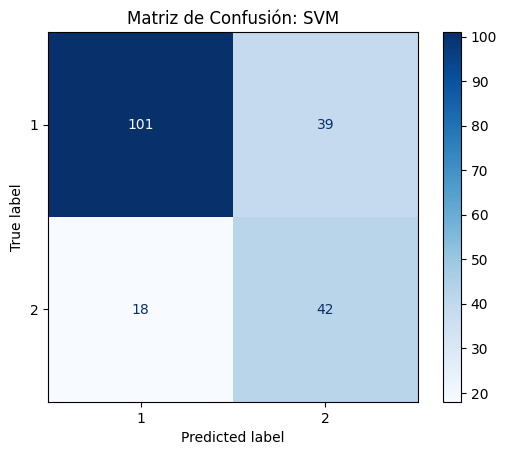

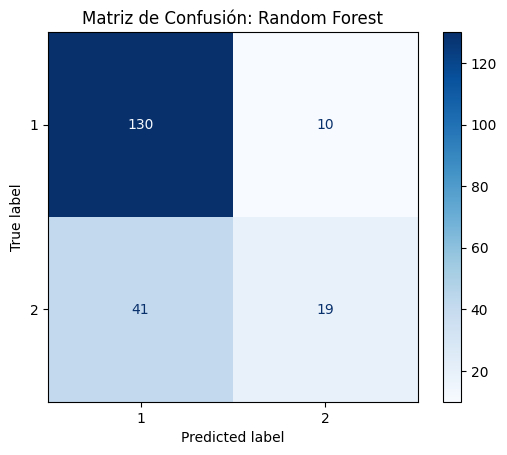

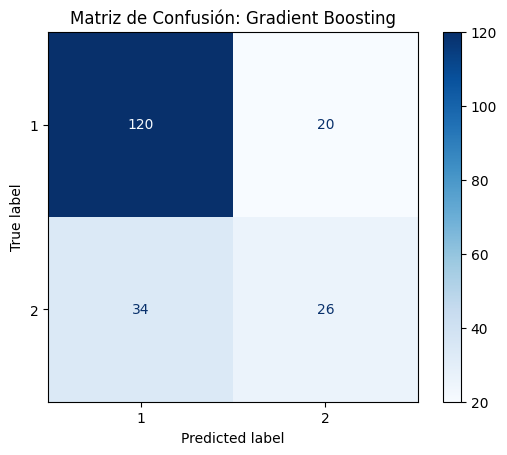

In [156]:

# Calcular probabilidades o puntajes de decisión para el ROC AUC
y_prob_svm = best_svm.decision_function(X_test_transformed)
y_prob_rf = best_rf.predict_proba(X_test_transformed)[:, 1]
y_prob_gb = best_gb.predict_proba(X_test_transformed)[:, 1]

# Calcular ROC AUC
roc_auc_svm = roc_auc_score(y_test, y_prob_svm)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
roc_auc_gb = roc_auc_score(y_test, y_prob_gb)

print("\nROC AUC Scores:")
print("SVM (RBF):", roc_auc_svm)
print("Random Forest:", roc_auc_rf)
print("Gradient Boosting:", roc_auc_gb)


# Obtener FPR, TPR y thresholds para cada modelo
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm, pos_label=2)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf, pos_label=2)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb, pos_label=2)

# Graficar las curvas ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, color="blue", lw=2, label=f"SVM (AUC = {roc_auc_svm:.4f})")
plt.plot(fpr_rf, tpr_rf, color="green", lw=2, label=f"Random Forest (AUC = {roc_auc_rf:.4f})")
plt.plot(fpr_gb, tpr_gb, color="red", lw=2, label=f"Gradient Boosting (AUC = {roc_auc_gb:.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Línea de referencia")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Graficar matrices de confusión
models = {'SVM': y_pred_svm, 'Random Forest': y_pred_rf, 'Gradient Boosting': y_pred_gb}
for model_name, y_pred in models.items():
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matriz de Confusión: {model_name}")
    plt.show()





# Análisis de Resultados

Los tres modelos (**SVM con kernel RBF**, **Random Forest**, y **Gradient Boosting**) presentan resultados variados en términos de desempeño global (**accuracy**) y en métricas específicas como **precision**, **recall** y **f1-score**. A continuación, el análisis detallado:

---

## **1. SVM (RBF)**

- **Accuracy**: **0.715** (bajo en comparación con Random Forest y Gradient Boosting).
- **Clase 1**:
  - **Precision**: **0.85** → Buen desempeño al evitar falsos positivos.
  - **Recall**: **0.72** → Identifica correctamente el 72% de los ejemplos de la clase 1.
  - **F1-score**: **0.78** → Balance razonable entre precision y recall.
- **Clase 2**:
  - **Precision**: **0.52** → Desempeño limitado en evitar falsos positivos.
  - **Recall**: **0.70** → Detecta el 70% de los ejemplos de la clase 2, mejor que otros modelos.
  - **F1-score**: **0.60** → Moderado, pero insuficiente.
- **Comentario**:
  - SVM muestra un mejor balance entre precision y recall para ambas clases en comparación con los otros modelos.
  - El **recall alto** en la clase 2 sugiere que SVM es mejor para detectar correctamente ejemplos de la clase minoritaria, aunque esto afecta su precision.


## **2. Random Forest**

- **Accuracy**: **0.745** (el mejor entre los tres modelos).
- **Clase 1**:
  - **Precision**: **0.76** → Adecuado para evitar falsos positivos.
  - **Recall**: **0.93** → Excelente desempeño al identificar casi todos los ejemplos de la clase 1.
  - **F1-score**: **0.84** → Muy bueno.
- **Clase 2**:
  - **Precision**: **0.66** → Mejor que otros modelos en evitar falsos positivos.
  - **Recall**: **0.32** → Muy bajo, detecta solo el 32% de los ejemplos de la clase 2.
  - **F1-score**: **0.43** → Débil debido al bajo recall.
- **Comentario**:
  - Random Forest tiene el mejor desempeño en la clase mayoritaria (**clase 1**), con un recall sobresaliente.
  - Sin embargo, está muy sesgado hacia la clase mayoritaria, con un desempeño pobre en la **clase minoritaria (clase 2)**.


## **3. Gradient Boosting**

- **Accuracy**: **0.73** (intermedio entre los otros dos modelos).
- **Clase 1**:
  - **Precision**: **0.78** → Adecuado para evitar falsos positivos.
  - **Recall**: **0.86** → Muy bueno, identifica correctamente la mayoría de los ejemplos de la clase 1.
  - **F1-score**: **0.82** → Balance sólido entre precision y recall.
- **Clase 2**:
  - **Precision**: **0.57** → Menos precisa que Random Forest.
  - **Recall**: **0.43** → Mejor que Random Forest, pero inferior a SVM.
  - **F1-score**: **0.49** → Moderado, pero no excelente.
- **Comentario**:
  - Gradient Boosting tiene un desempeño más balanceado que Random Forest, con un mejor recall en la **clase 2**, aunque sigue siendo limitado.
  - Es menos propenso al sesgo hacia la clase mayoritaria, pero su desempeño global sigue siendo menor que el de SVM en la clase minoritaria.


## **4. Análisis Global**

### **Clase mayoritaria (1 = "good"):**
- Todos los modelos manejan bien esta clase, con **Random Forest** sobresaliendo en el **recall** (0.93).
- **Gradient Boosting** ofrece un buen balance, mientras que **SVM** es competitivo pero ligeramente inferior.

### **Clase minoritaria (2 = "bad"):**
- **SVM** tiene el mejor **recall** (0.70), detectando la mayoría de los ejemplos de la clase minoritaria, aunque esto afecta su precision.
- **Random Forest** está muy sesgado hacia la clase mayoritaria, con un recall muy bajo (0.32) en la clase minoritaria.
- **Gradient Boosting** ofrece un desempeño intermedio con mejor balance entre precision y recall que Random Forest.

## **Modelo recomendado:**
- **SVM** es la mejor opción si priorizamos el desempeño en la **clase minoritaria** (clase "bad").
- **Random Forest** es ideal si nuestro objetivo es maximizar el desempeño en la **clase mayoritaria** (clase "good").
- **Gradient Boosting** ofrece el mejor balance general entre ambas clases, aunque su desempeño global no es superior en ninguna métrica específica.

